In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
from sklearn.model_selection import train_test_split

import torch
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Train with GPU support.")
else:
    device = torch.device('cpu')
    print("No GPU found, train with CPU support.")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# own utils # TODO resolve namespace pollution by restricitn g importis in init
from utils.configuration import *
from utils.tram_models import *
from utils.tram_model_helpers import *
from utils.tram_data import *
from utils.loss_continous import *
from utils.sampling_tram_data import *

Train with GPU support.


# 1. Experiments and Paths

In [2]:
experiment_name = "example"   ## <--- set experiment name
seed=42
np.random.seed(seed)

LOG_DIR="/home/bule/TramDag/dev_experiment_logs"
EXPERIMENT_DIR = os.path.join(LOG_DIR, experiment_name)
DATA_PATH = EXPERIMENT_DIR # <----------- change to different source if needed
CONF_DICT_PATH = os.path.join(EXPERIMENT_DIR, f"configuration.json")

os.makedirs(EXPERIMENT_DIR,exist_ok=True)
# check if configration dict already exists if not create:

if os.path.exists(CONF_DICT_PATH):
    configuration_dict=load_configuration_dict(CONF_DICT_PATH)
    print(f"Loaded existing configuration from {CONF_DICT_PATH}")
else:
    configuration_dict=create_and_write_new_configuration_dict(experiment_name,CONF_DICT_PATH,EXPERIMENT_DIR,DATA_PATH,LOG_DIR)
    print(f"Created new configuration file at {CONF_DICT_PATH}")

Created new configuration file at /home/bule/TramDag/dev_experiment_logs/example/configuration.json


# 2.  Data

         x1        x2  x3        x4  x5
0  0.799968 -0.403072   3  1.242346   1
1  0.236174 -0.299241   1 -0.633190   1
2  0.732982 -0.563851   3  1.412221   1
3  0.402303 -0.174495   2  0.379400   0
4  0.226585 -0.291049   3  1.762330   1


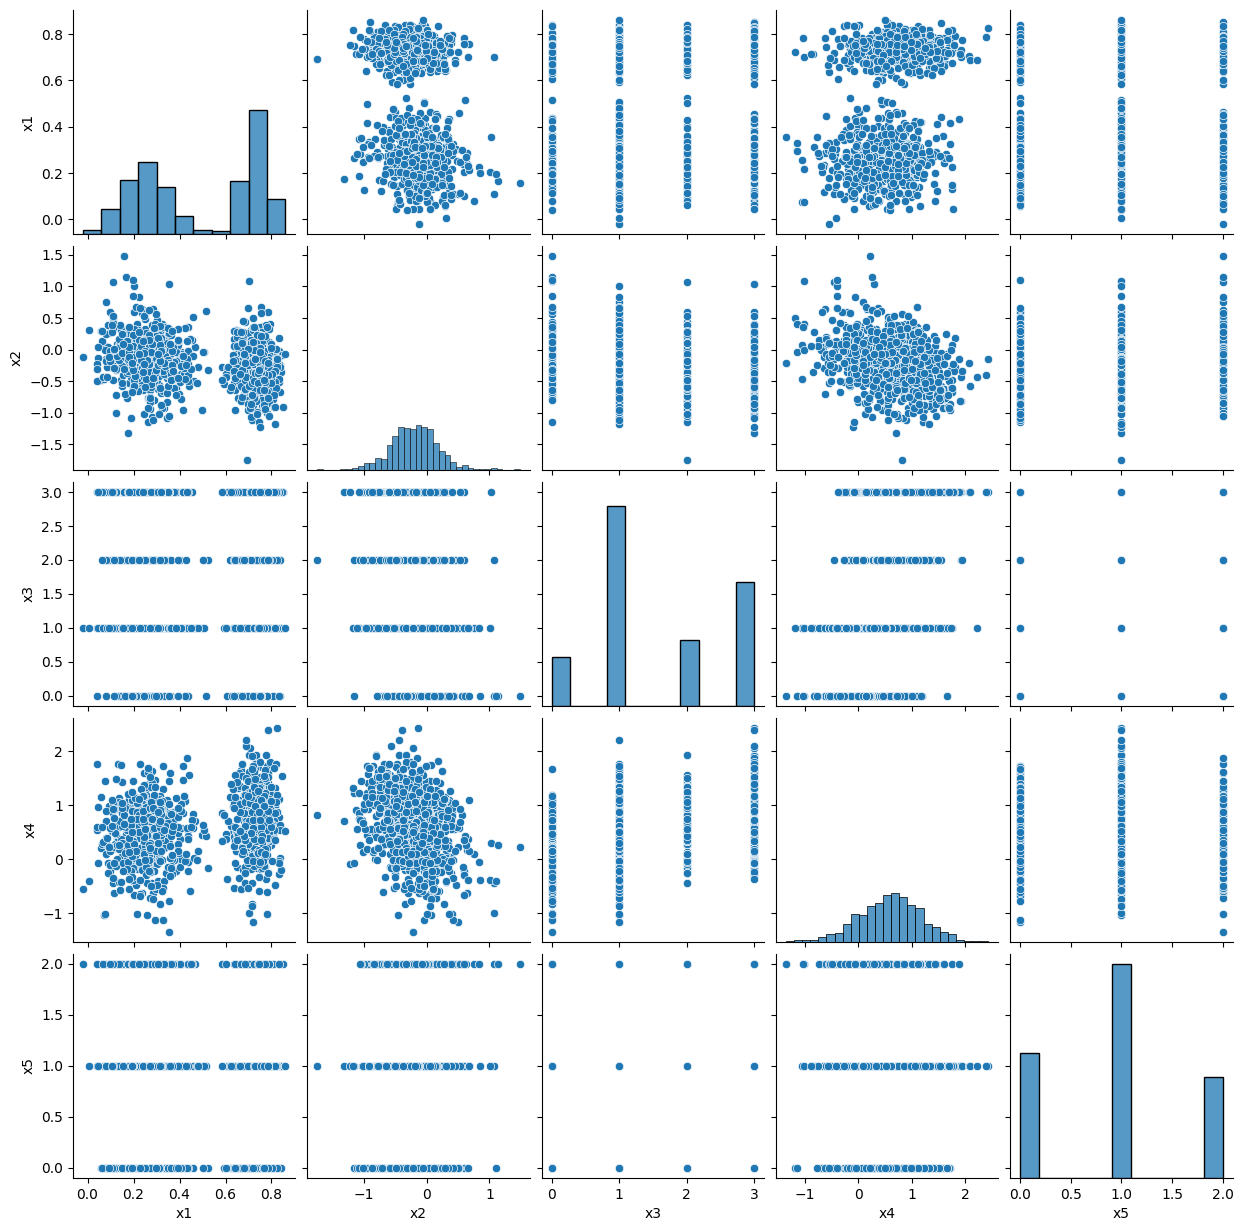

In [3]:

def dgp(n_obs, doX=[None, None, None, None, None], f=lambda x: x, seed=None):
    """
    Data-generating process with 5 variables:
      - x1, x2, x4: continuous
      - x3: ordered categorical with levels [0,1,2,3]
      - x5: nominal categorical with levels [0,1,2]

    Parameters
    ----------
    n_obs : int
        Number of observations.
    doX : list of length 5
        Fix values for x1..x5 (use None for random sampling).
    f : callable
        Function of x2 used in generating x3.
    seed : int or None
        Random seed.

    Returns
    -------
    pd.DataFrame
        Columns ['x1','x2','x3','x4','x5']
    """
    if seed is not None:
        np.random.seed(seed)

    # --- x1: GMM ---
    if doX[0] is None:
        X1_A = np.random.normal(loc=0.25, scale=0.10, size=n_obs)
        X1_B = np.random.normal(loc=0.73, scale=0.05, size=n_obs)
        mix = np.random.choice([0, 1], size=n_obs)
        x1 = np.where(mix == 0, X1_A, X1_B)
    else:
        x1 = np.full(n_obs, doX[0], dtype=float)

    # --- x2: shifted-logit ---
    if doX[1] is None:
        u2 = np.random.uniform(size=n_obs)
        z2 = np.log(u2 / (1 - u2))
        x2 = (z2 - 2 * x1) / 5.0
    else:
        x2 = np.full(n_obs, doX[1], dtype=float)

    # --- x3: ordered categorical ---
    if doX[2] is None:
        u3 = np.random.logistic(loc=0.0, scale=1.0, size=n_obs)
        theta = np.array([-2.0, 0.42, 1.02])
        h = theta + 0.2 * x1.reshape(-1, 1) + f(x2).reshape(-1, 1)
        x3 = np.zeros(n_obs, dtype=int)
        x3[u3 > h[:, 0]] = 1
        x3[u3 > h[:, 1]] = 2
        x3[u3 > h[:, 2]] = 3
    else:
        x3 = np.full(n_obs, int(doX[2]), dtype=int)

    # --- x4: continuous depending on x1,x2,x3 ---
    if doX[3] is None:
        mu4 = 0.5 * x1 - 0.3 * x2 + 0.2 * x3
        x4 = np.random.normal(loc=mu4, scale=0.5, size=n_obs)
    else:
        x4 = np.full(n_obs, doX[3], dtype=float)

    # --- x5: nominal categorical with 3 classes (0,1,2) ---
    if doX[4] is None:
        logits = np.zeros((n_obs, 3))
        logits[:, 1] = -0.2 + 0.8 * x1 + 0.2 * x2 + 0.3 * x4 + 0.15 * x3
        logits[:, 2] = 0.1 - 0.5 * x1 + 0.6 * x2 - 0.2 * x4 + 0.10 * x3
        exp_logits = np.exp(logits - logits.max(axis=1, keepdims=True))
        probs = exp_logits / exp_logits.sum(axis=1, keepdims=True)
        draws = [np.random.choice([0, 1, 2], p=p) for p in probs]
        x5 = np.array(draws, dtype=int)
    else:
        x5 = np.full(n_obs, int(doX[4]), dtype=int)

    return pd.DataFrame({'x1': x1, 'x2': x2, 'x3': x3, 'x4': x4, 'x5': x5})


EXP_DATA_PATH=os.path.join(DATA_PATH, f"{experiment_name}.csv")
if not os.path.exists(EXP_DATA_PATH):
    df = dgp(n_obs=1000, seed=42)
    print(df.head())
    df.to_csv(EXP_DATA_PATH, index=False)
else:
    df = pd.read_csv(EXP_DATA_PATH)
    print(f"Loaded data from {EXP_DATA_PATH}")

sns.pairplot(df)

In [4]:
data_type= {'x1':'continous','x2':'continous','x3':'ordinal_Xn_Yc','x4':'continous','x5':'ordinal_Xc_Yo'} 

write_data_type_to_configuration(data_type, CONF_DICT_PATH)

df.info()

Variable 'x1' is modeled as a continuous variable. for target and predictor.
Variable 'x2' is modeled as a continuous variable. for target and predictor.
Variable 'x3' is modeled as an ordinal   variable. As PREDICTOR: OneHot and TARGET: continous.
Variable 'x4' is modeled as a continuous variable. for target and predictor.
Variable 'x5' is modeled as an ordinal   variable. As PREDICTOR: continous and TARGET: OneHot.
Configuration updated successfully.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      1000 non-null   float64
 1   x2      1000 non-null   float64
 2   x3      1000 non-null   int64  
 3   x4      1000 non-null   float64
 4   x5      1000 non-null   int64  
dtypes: float64(3), int64(2)
memory usage: 39.2 KB


## 2.1 train test split

In [5]:
# 1. Split the data
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# 2. Compute quantiles from training data
quantiles = train_df.quantile([0.05, 0.95])
min_vals = quantiles.loc[0.05]
max_vals = quantiles.loc[0.95]

# # 3. Normalize all sets using training quantiles
# def normalize_with_quantiles(df, min_vals, max_vals):
#     return (df - min_vals) / (max_vals - min_vals)


# def normalize_with_quantiles(df, min_vals, max_vals, exclude_columns=None):
#     """
#     Normalize df using (df - min) / (max - min), but skip any columns in exclude_columns.
#     min_vals and max_vals should come from the training set.
#     """
#     exclude_columns = set() if exclude_columns is None else set(exclude_columns)
#     normalized = df.copy()

#     for col in df.columns:
#         if col in exclude_columns:
#             continue
#         if col not in min_vals.index or col not in max_vals.index:
#             continue
#         min_val = min_vals[col]
#         max_val = max_vals[col]
#         range_ = max_val - min_val
#         if range_ == 0 or pd.isna(range_):
#             normalized[col] = df[col].apply(lambda x: 0.0 if not pd.isna(x) else x)
#         else:
#             normalized[col] = (df[col] - min_val) / range_
#     return normalized


# train_df = normalize_with_quantiles(train_df, min_vals, max_vals,exclude_columns=['x3'])
# val_df = normalize_with_quantiles(val_df, min_vals, max_vals,exclude_columns=['x3'])
# test_df = normalize_with_quantiles(test_df, min_vals, max_vals,exclude_columns=['x3'])



print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}")

Train size: 800, Validation size: 100, Test size: 100


# 3. Define graph Structure

- define graph and which shift and intercept terms to use


In [6]:
interactive_adj_matrix(CONF_DICT_PATH,seed=10)

No matrix found. Please fill out the DAG and click 'Generate'.


# 4. Configuration for the Models

- all SI and LS model are generated outmatically since these are shallow NN's
- CI and CS have to be defined by the User and can be Passed for each model, -> generate default networks which are generated automaitcally

In [8]:
interactive_nn_names_matrix(CONF_DICT_PATH, seed=5)

*************
 Model has Complex intercepts and Complex shifts, please add your Model to the modelzoo 
*************


In [9]:
levels_dict=create_levels_dict(df,data_type)

write_nodes_information_to_configuration(CONF_DICT_PATH, min_vals, max_vals,levels_dict)

{'x1': {'Modelnr': 0, 'data_type': 'continous', 'node_type': 'source', 'parents': [], 'parents_datatype': {}, 'transformation_terms_in_h()': {}, 'min': 0.12854786353531034, 'max': 0.7945505419528904, 'transformation_term_nn_models_in_h()': {}}, 'x2': {'Modelnr': 1, 'data_type': 'continous', 'node_type': 'internal', 'parents': ['x1'], 'parents_datatype': {'x1': 'continous'}, 'transformation_terms_in_h()': {'x1': np.str_('ls')}, 'min': -0.809538789812, 'max': 0.36504416874660905, 'transformation_term_nn_models_in_h()': {'x1': np.str_('LinearShift')}}, 'x3': {'Modelnr': 2, 'data_type': 'ordinal_Xn_Yc', 'levels': 4, 'node_type': 'internal', 'parents': ['x1', 'x2'], 'parents_datatype': {'x1': 'continous', 'x2': 'continous'}, 'transformation_terms_in_h()': {'x1': np.str_('cs'), 'x2': np.str_('cs')}, 'min': 0.0, 'max': 3.0, 'transformation_term_nn_models_in_h()': {'x1': np.str_('ComplexShiftDefaultTabular'), 'x2': np.str_('ComplexShiftDefaultTabular')}}, 'x4': {'Modelnr': 3, 'data_type': 'con

### --------------------- 

In [11]:
train_list=['x1','x2','x3','x4','x5']#<-  set the nodes which have to be trained , useful if further training is required else lsit all vars

batch_size = 512#4112
epochs = 5# <- if you want a higher numbe rof epochs, set the number higher and it loads the old model and starts from there
learning_rate=0.01
use_scheduler =  False

In [12]:
# For each NODE 
configuration_dict = load_configuration_dict(CONF_DICT_PATH)
target_nodes = configuration_dict['nodes'] ## TODO rename target nodes to nodelist 

for node in target_nodes:
    
    print(f'\n----*----------*-------------*--------------- Node: {node} ------------*-----------------*-------------------*--')
    ########################## 0. Skip nodes ###############################
    if node not in train_list:# Skip if node is not in train_list
        print(f"Skipping node {node} as it's not in the training list.")
        continue
    if (target_nodes[node]['node_type'] == 'source') and (target_nodes[node]['node_type'] == 'other'):# Skip unsupported types
        print(f"Node type : other , is not supported yet")
        continue

    ########################## 1. Setup Paths ###############################
    NODE_DIR = os.path.join(EXPERIMENT_DIR, f'{node}')
    os.makedirs(NODE_DIR, exist_ok=True)
    
    # Check if training is complete
    if not check_if_training_complete(node, NODE_DIR, epochs):
        continue
    
    ########################## 2. Create Model ##############################
    tram_model= get_fully_specified_tram_model(node, target_nodes, verbose=True)

    ########################## 3. Create Dataloaders ########################
    train_loader, val_loader = get_dataloader(node, target_nodes, train_df, val_df, batch_size=batch_size,return_intercept_shift=True, verbose=False)

    ########################## 5. Optimizer & Scheduler ######################.
    optimizer =torch.optim.Adam(tram_model.parameters(), lr=learning_rate)
    
    if use_scheduler:
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
    else:
        scheduler = None

    ########################## 7. Training Loop ##############################
    
    train_val_loop(
                node,
                target_nodes,
                NODE_DIR,
                tram_model,
                train_loader,
                val_loader,
                epochs,
                optimizer,
                use_scheduler,
                scheduler,
                save_linear_shifts=False,
                verbose=1,
                device=device) # TODO startvalues for bernsteinpols



----*----------*-------------*--------------- Node: x1 ------------*-----------------*-------------------*--
No existing model found. Starting fresh...
Saved new best model.
Epoch 1/5  Train NLL: 1.1941  Val NLL: 1.1841  [Train: 0.55s  Val: 0.19s  Total: 0.74s]
Saved new best model.
Epoch 2/5  Train NLL: 1.1820  Val NLL: 1.1719  [Train: 0.24s  Val: 0.21s  Total: 0.45s]
Saved new best model.
Epoch 3/5  Train NLL: 1.1709  Val NLL: 1.1599  [Train: 0.25s  Val: 0.18s  Total: 0.43s]
Saved new best model.
Epoch 4/5  Train NLL: 1.1589  Val NLL: 1.1479  [Train: 0.25s  Val: 0.20s  Total: 0.45s]
Saved new best model.
Epoch 5/5  Train NLL: 1.1462  Val NLL: 1.1360  [Train: 0.24s  Val: 0.20s  Total: 0.44s]

----*----------*-------------*--------------- Node: x2 ------------*-----------------*-------------------*--
No existing model found. Starting fresh...
Saved new best model.
Epoch 1/5  Train NLL: 2.0577  Val NLL: 2.0626  [Train: 0.26s  Val: 0.20s  Total: 0.46s]
Saved new best model.
Epoch 2/5  T

In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 800 entries, 29 to 102
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      800 non-null    float64
 1   x2      800 non-null    float64
 2   x3      800 non-null    int64  
 3   x4      800 non-null    float64
 4   x5      800 non-null    int64  
dtypes: float64(3), int64(2)
memory usage: 37.5 KB


# 6 Inspect Training

## 6.1 Loss vs epochs

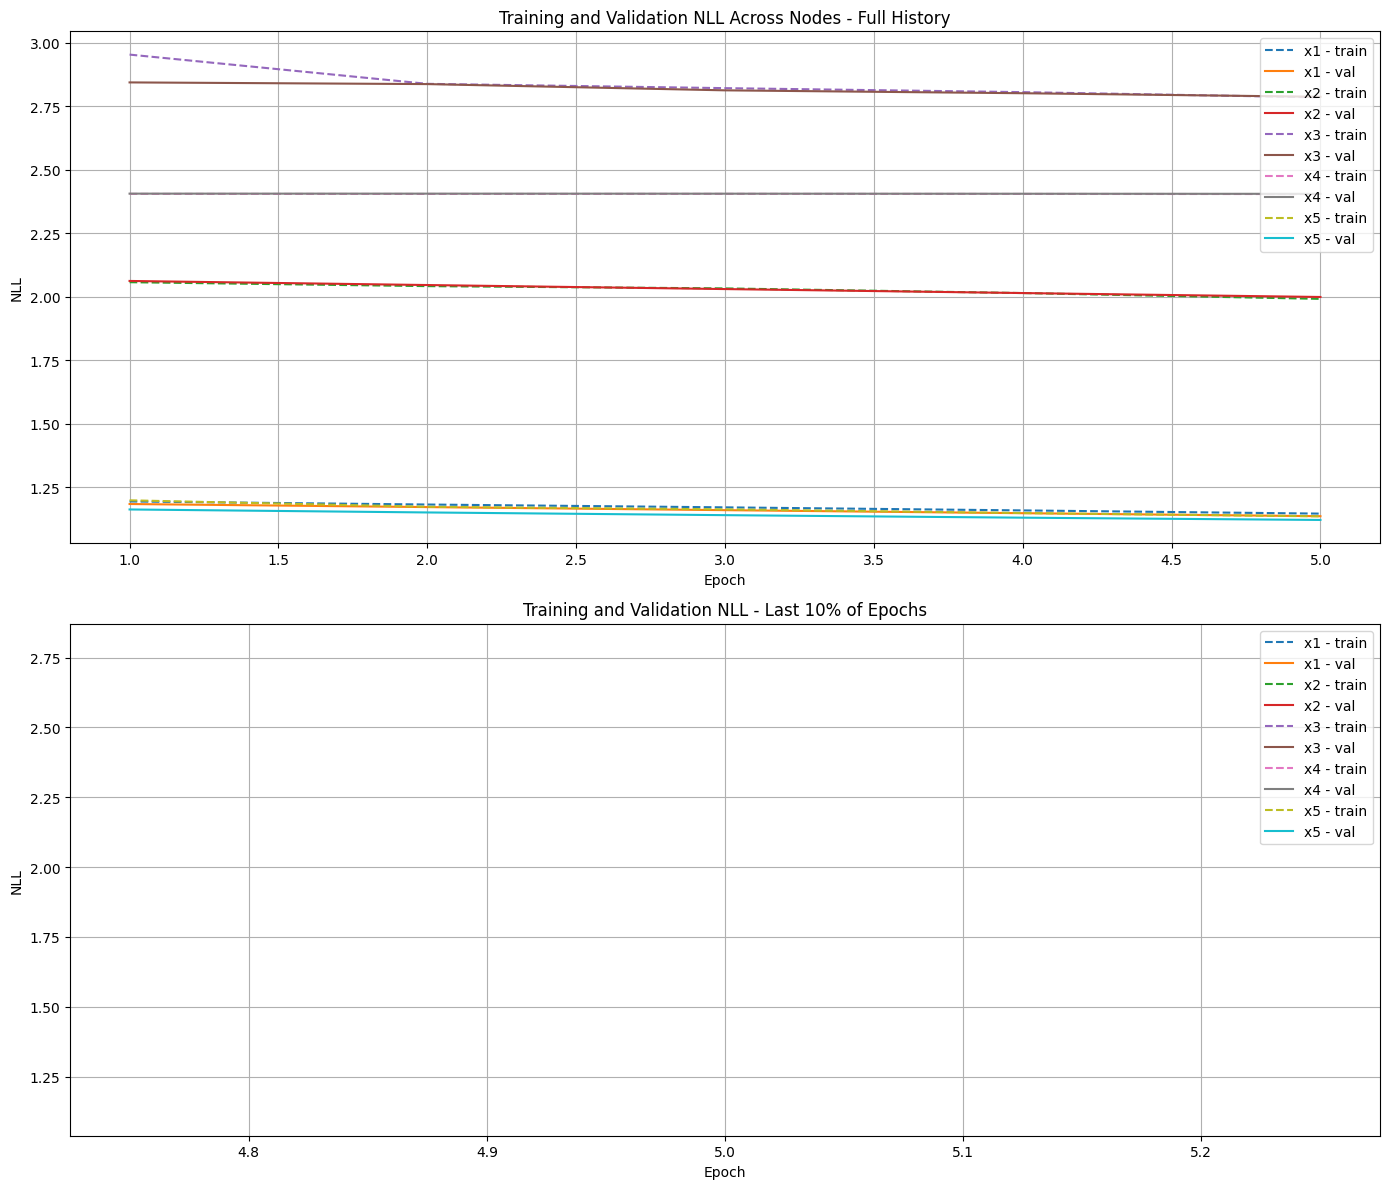

In [14]:
show_training_history(target_nodes,EXPERIMENT_DIR)

## 6.2 inspect transformation function for source nodes h()


----*----------*-------------*--------Inspect TRAFO Node: x1 ------------*-----------------*-------------------*--
[WARNING] target_col 'x1' not in DataFrame columns — is this intended for use as a Sampler?


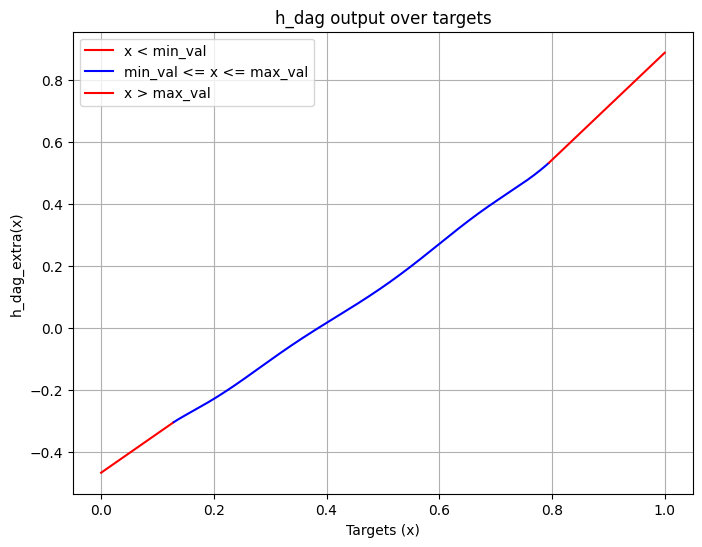


----*----------*-------------*--------Inspect TRAFO Node: x2 ------------*-----------------*-------------------*--
skipped.. since h does depend on parents and is different for every instance

----*----------*-------------*--------Inspect TRAFO Node: x3 ------------*-----------------*-------------------*--
skipped.. since h does depend on parents and is different for every instance

----*----------*-------------*--------Inspect TRAFO Node: x4 ------------*-----------------*-------------------*--
skipped.. since h does depend on parents and is different for every instance

----*----------*-------------*--------Inspect TRAFO Node: x5 ------------*-----------------*-------------------*--
skipped.. since h does depend on parents and is different for every instance


In [15]:
show_hdag_for_source_nodes(target_nodes,EXPERIMENT_DIR,device,xmin_plot=-0,xmax_plot=1)

----*----------*-------------*--------h(data) should be standard logistic: x1 ------------*-----------------*-------------------*--


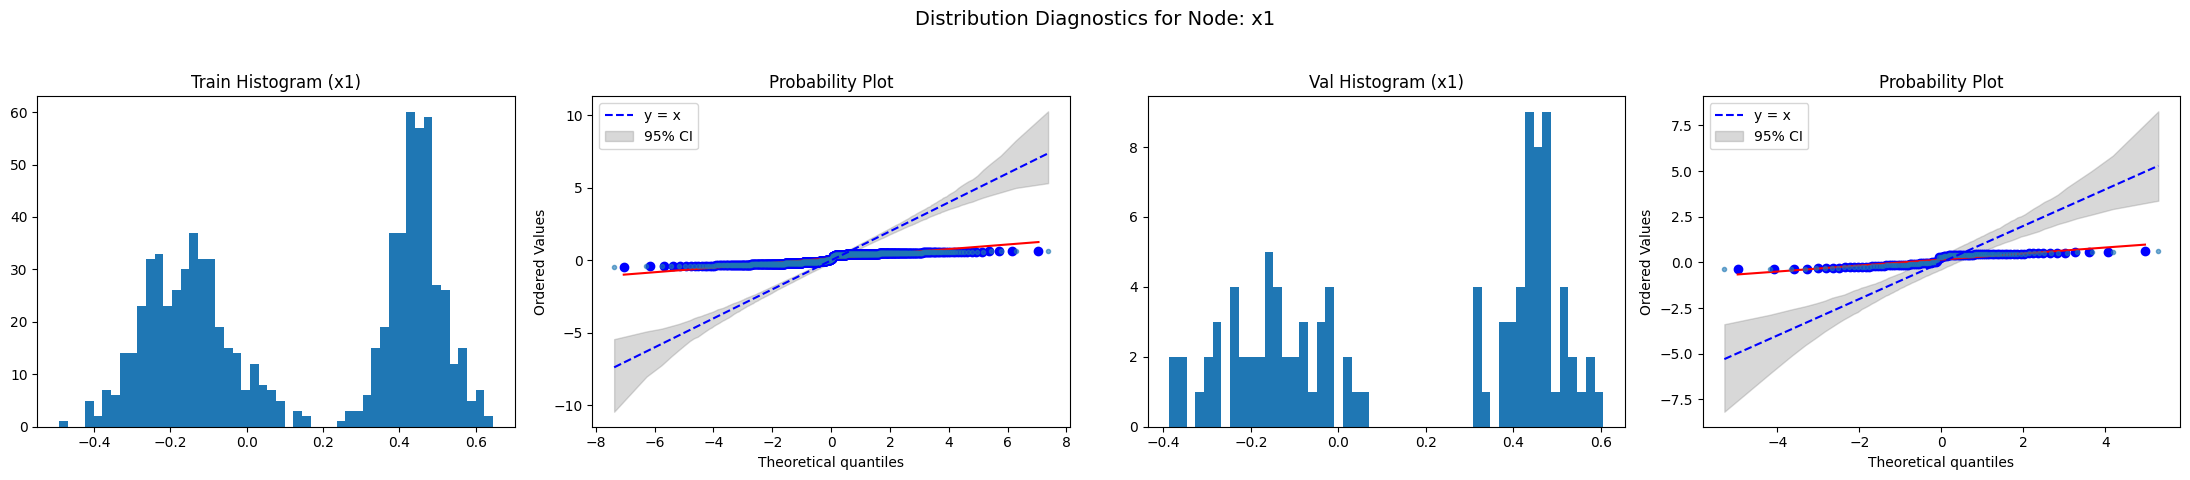

----*----------*-------------*--------h(data) should be standard logistic: x2 ------------*-----------------*-------------------*--


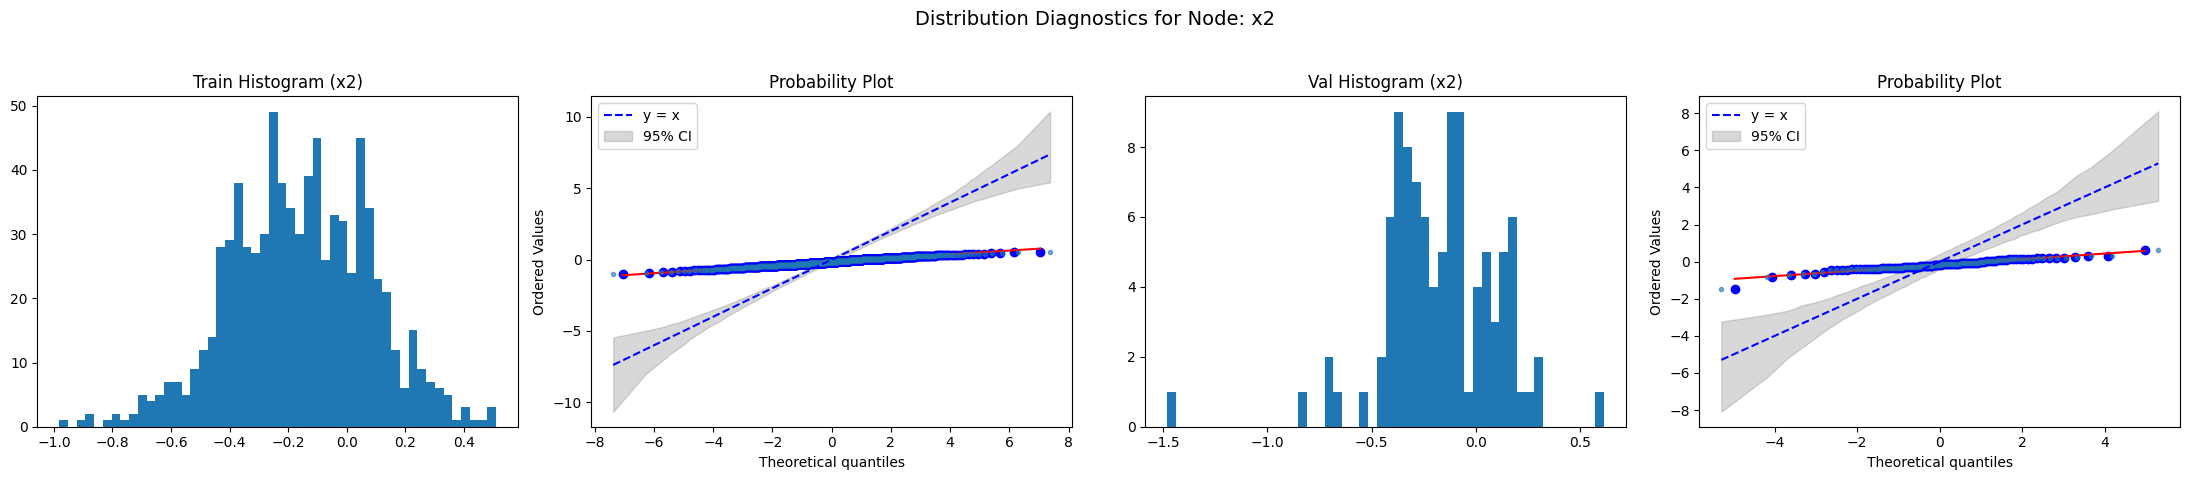

----*----------*-------------*--------h(data) should be standard logistic: x3 ------------*-----------------*-------------------*--


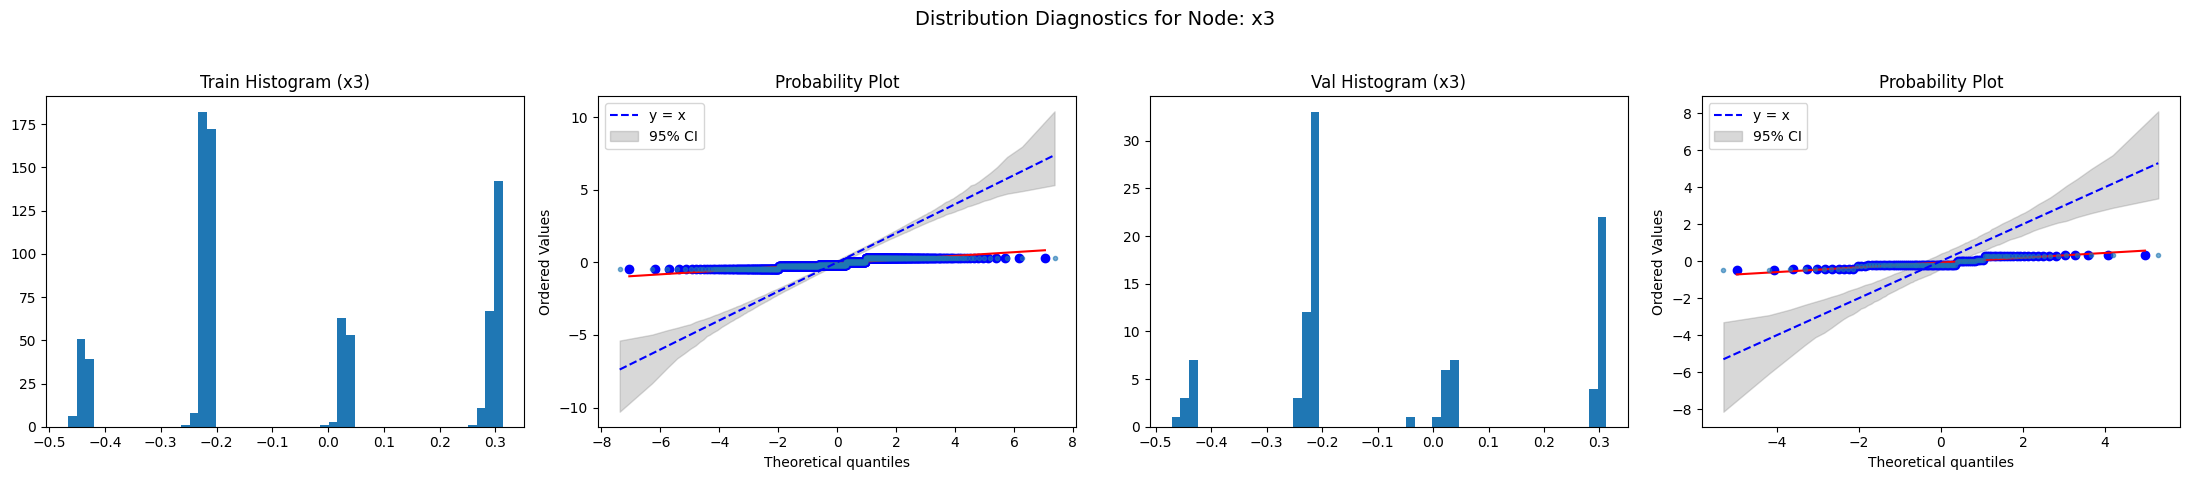

----*----------*-------------*--------h(data) should be standard logistic: x4 ------------*-----------------*-------------------*--


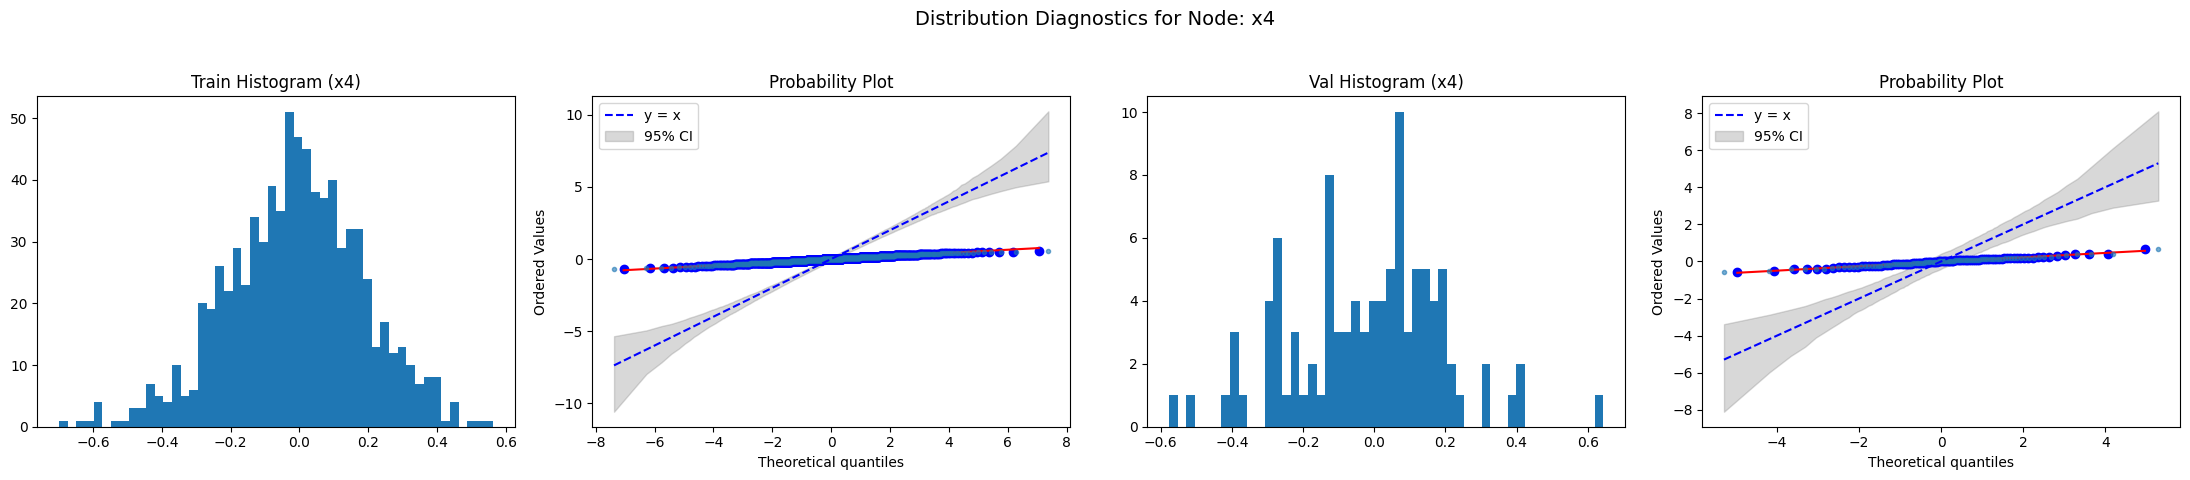

----*----------*-------------*--------h(data) should be standard logistic: x5 ------------*-----------------*-------------------*--
not defined for ordinal target variables


In [16]:
inspect_trafo_standart_logistic(target_nodes, EXPERIMENT_DIR, train_df, val_df, device, verbose=False)

# 7. Sample from Graph

In [17]:
sample_full_dag(target_nodes,
                            EXPERIMENT_DIR,
                            device,
                            do_interventions={},
                            number_of_samples= 10_000,
                            batch_size = 32,
                            delete_all_previously_sampled=True,
                            verbose=True,
                            debug=False)

[INFO] Deleting all previously sampled data.
Directory does not exist: /home/bule/TramDag/dev_experiment_logs/example/x1/sampling
Directory does not exist: /home/bule/TramDag/dev_experiment_logs/example/x2/sampling
Directory does not exist: /home/bule/TramDag/dev_experiment_logs/example/x3/sampling
Directory does not exist: /home/bule/TramDag/dev_experiment_logs/example/x4/sampling
Directory does not exist: /home/bule/TramDag/dev_experiment_logs/example/x5/sampling

----*----------*-------------*--------Sample Node: x1 ------------*-----------------*-------------------*--
[WARNING] target_col 'x1' not in DataFrame columns — is this intended for use as a Sampler?


Chandrupatla root finding: 100%|██████████| 10000/10000 [00:30<00:00, 328.42it/s]

[INFO] Completed sampling for node 'x1'

----*----------*-------------*--------Sample Node: x2 ------------*-----------------*-------------------*--
[WARNING] target_col 'x2' not in DataFrame columns — is this intended for use as a Sampler?



Chandrupatla root finding: 100%|██████████| 10000/10000 [00:30<00:00, 332.12it/s]

[INFO] Completed sampling for node 'x2'

----*----------*-------------*--------Sample Node: x3 ------------*-----------------*-------------------*--
[WARNING] target_col 'x3' not in DataFrame columns — is this intended for use as a Sampler?



Chandrupatla root finding: 100%|██████████| 10000/10000 [00:29<00:00, 343.43it/s]

[INFO] Completed sampling for node 'x3'

----*----------*-------------*--------Sample Node: x4 ------------*-----------------*-------------------*--
[WARNING] target_col 'x4' not in DataFrame columns — is this intended for use as a Sampler?



Chandrupatla root finding: 100%|██████████| 10000/10000 [00:29<00:00, 338.77it/s]


[INFO] Completed sampling for node 'x4'

----*----------*-------------*--------Sample Node: x5 ------------*-----------------*-------------------*--
[WARNING] target_col 'x5' not in DataFrame columns — is this intended for use as a Sampler?


ValueError: Ordinal predictor 'x3' must be zero‑indexed; got [np.float32(-17.19569), np.float32(-16.493092), np.float32(-16.484543), np.float32(-16.177437), np.float32(-15.918419), np.float32(-15.917408), np.float32(-15.176037), np.float32(-15.012218), np.float32(-14.871414), np.float32(-14.600449), np.float32(-13.803469), np.float32(-13.748671), np.float32(-13.708601), np.float32(-13.641867), np.float32(-13.623274), np.float32(-13.34701), np.float32(-13.179789), np.float32(-13.120468), np.float32(-13.108065), np.float32(-13.079466), np.float32(-12.981232), np.float32(-12.953613), np.float32(-12.685337), np.float32(-12.612959), np.float32(-12.464237), np.float32(-12.313286), np.float32(-12.157318), np.float32(-12.029745), np.float32(-12.016289), np.float32(-11.868954), np.float32(-11.848928), np.float32(-11.743269), np.float32(-11.67701), np.float32(-11.583105), np.float32(-11.388832), np.float32(-11.367207), np.float32(-11.346798), np.float32(-11.322489), np.float32(-11.133348), np.float32(-11.080318), np.float32(-11.077198), np.float32(-11.021969), np.float32(-10.942635), np.float32(-10.908722), np.float32(-10.893036), np.float32(-10.825529), np.float32(-10.811632), np.float32(-10.799263), np.float32(-10.789642), np.float32(-10.74547), np.float32(-10.687496), np.float32(-10.685589), np.float32(-10.665489), np.float32(-10.645977), np.float32(-10.626343), np.float32(-10.624102), np.float32(-10.623243), np.float32(-10.620007), np.float32(-10.616625), np.float32(-10.607761), np.float32(-10.479471), np.float32(-10.456257), np.float32(-10.416298), np.float32(-10.397198), np.float32(-10.379034), np.float32(-10.340662), np.float32(-10.3033905), np.float32(-10.225071), np.float32(-10.191557), np.float32(-10.091032), np.float32(-10.082315), np.float32(-10.044924), np.float32(-9.913527), np.float32(-9.910473), np.float32(-9.881798), np.float32(-9.834862), np.float32(-9.827339), np.float32(-9.819042), np.float32(-9.814165), np.float32(-9.785036), np.float32(-9.758841), np.float32(-9.733112), np.float32(-9.702677), np.float32(-9.699146), np.float32(-9.698944), np.float32(-9.668236), np.float32(-9.64596), np.float32(-9.61525), np.float32(-9.566402), np.float32(-9.509556), np.float32(-9.502827), np.float32(-9.473722), np.float32(-9.444653), np.float32(-9.368767), np.float32(-9.291092), np.float32(-9.228842), np.float32(-9.227299), np.float32(-9.219456), np.float32(-9.181631), np.float32(-9.17156), np.float32(-9.146492), np.float32(-9.13014), np.float32(-9.107323), np.float32(-9.060041), np.float32(-9.059757), np.float32(-9.043308), np.float32(-9.0392), np.float32(-9.038662), np.float32(-9.023483), np.float32(-8.997341), np.float32(-8.980692), np.float32(-8.979393), np.float32(-8.966364), np.float32(-8.952019), np.float32(-8.929514), np.float32(-8.9112835), np.float32(-8.908144), np.float32(-8.904291), np.float32(-8.893257), np.float32(-8.870655), np.float32(-8.85083), np.float32(-8.807186), np.float32(-8.786938), np.float32(-8.781618), np.float32(-8.763863), np.float32(-8.76322), np.float32(-8.737083), np.float32(-8.727335), np.float32(-8.688538), np.float32(-8.649557), np.float32(-8.621235), np.float32(-8.61367), np.float32(-8.594172), np.float32(-8.563469), np.float32(-8.533466), np.float32(-8.529081), np.float32(-8.505205), np.float32(-8.453106), np.float32(-8.414581), np.float32(-8.409964), np.float32(-8.402685), np.float32(-8.385004), np.float32(-8.378874), np.float32(-8.360542), np.float32(-8.357477), np.float32(-8.321558), np.float32(-8.319233), np.float32(-8.297897), np.float32(-8.292313), np.float32(-8.279345), np.float32(-8.207878), np.float32(-8.149012), np.float32(-8.148249), np.float32(-8.116613), np.float32(-8.110128), np.float32(-8.108364), np.float32(-8.107899), np.float32(-8.097134), np.float32(-8.091515), np.float32(-8.072842), np.float32(-8.066257), np.float32(-8.0643425), np.float32(-8.061708), np.float32(-8.048391), np.float32(-8.032726), np.float32(-8.00243), np.float32(-7.9776964), np.float32(-7.958499), np.float32(-7.946953), np.float32(-7.9132385), np.float32(-7.889454), np.float32(-7.83891), np.float32(-7.8382254), np.float32(-7.827677), np.float32(-7.8272877), np.float32(-7.8266563), np.float32(-7.8246975), np.float32(-7.8124266), np.float32(-7.8094664), np.float32(-7.7712317), np.float32(-7.7654905), np.float32(-7.745967), np.float32(-7.7424917), np.float32(-7.7412825), np.float32(-7.74032), np.float32(-7.7352104), np.float32(-7.7206955), np.float32(-7.7144594), np.float32(-7.713933), np.float32(-7.7115507), np.float32(-7.7079573), np.float32(-7.7013655), np.float32(-7.698575), np.float32(-7.689929), np.float32(-7.685894), np.float32(-7.6802616), np.float32(-7.6729326), np.float32(-7.6686563), np.float32(-7.663533), np.float32(-7.654708), np.float32(-7.6515446), np.float32(-7.649164), np.float32(-7.632615), np.float32(-7.6196003), np.float32(-7.610405), np.float32(-7.597891), np.float32(-7.595104), np.float32(-7.591346), np.float32(-7.5747213), np.float32(-7.5676126), np.float32(-7.5600653), np.float32(-7.5565367), np.float32(-7.556219), np.float32(-7.549548), np.float32(-7.5448895), np.float32(-7.5446453), np.float32(-7.5426884), np.float32(-7.535983), np.float32(-7.5344725), np.float32(-7.529331), np.float32(-7.51834), np.float32(-7.506546), np.float32(-7.4801874), np.float32(-7.479265), np.float32(-7.4736614), np.float32(-7.4698133), np.float32(-7.4556055), np.float32(-7.452979), np.float32(-7.4503574), np.float32(-7.448968), np.float32(-7.4471445), np.float32(-7.4441957), np.float32(-7.423704), np.float32(-7.423455), np.float32(-7.4196835), np.float32(-7.418401), np.float32(-7.4145384), np.float32(-7.4113855), np.float32(-7.4023523), np.float32(-7.392847), np.float32(-7.386051), np.float32(-7.382601), np.float32(-7.382411), np.float32(-7.3759413), np.float32(-7.3721447), np.float32(-7.371952), np.float32(-7.369484), np.float32(-7.367175), np.float32(-7.3590965), np.float32(-7.35474), np.float32(-7.346856), np.float32(-7.343299), np.float32(-7.338684), np.float32(-7.3357134), np.float32(-7.3245544), np.float32(-7.3198175), np.float32(-7.316674), np.float32(-7.312791), np.float32(-7.3050394), np.float32(-7.3045406), np.float32(-7.301708), np.float32(-7.3012733), np.float32(-7.2966623), np.float32(-7.2848988), np.float32(-7.282812), np.float32(-7.2818327), np.float32(-7.2767467), np.float32(-7.270108), np.float32(-7.2539387), np.float32(-7.2518816), np.float32(-7.2503014), np.float32(-7.2488165), np.float32(-7.244299), np.float32(-7.237768), np.float32(-7.2375374), np.float32(-7.237423), np.float32(-7.237261), np.float32(-7.234664), np.float32(-7.230464), np.float32(-7.2235317), np.float32(-7.2204466), np.float32(-7.2155313), np.float32(-7.2133226), np.float32(-7.2129383), np.float32(-7.210023), np.float32(-7.2071524), np.float32(-7.186184), np.float32(-7.179183), np.float32(-7.174944), np.float32(-7.170616), np.float32(-7.1567125), np.float32(-7.149482), np.float32(-7.1313095), np.float32(-7.126912), np.float32(-7.1236305), np.float32(-7.1143446), np.float32(-7.1125555), np.float32(-7.1023674), np.float32(-7.0959044), np.float32(-7.086563), np.float32(-7.064288), np.float32(-7.0589266), np.float32(-7.058716), np.float32(-7.030781), np.float32(-7.0290585), np.float32(-7.026105), np.float32(-7.019395), np.float32(-7.0093546), np.float32(-6.995427), np.float32(-6.9949913), np.float32(-6.994197), np.float32(-6.9870567), np.float32(-6.9864845), np.float32(-6.9850683), np.float32(-6.973016), np.float32(-6.9687986), np.float32(-6.9669495), np.float32(-6.9626865), np.float32(-6.9596834), np.float32(-6.9505987), np.float32(-6.9482536), np.float32(-6.9462194), np.float32(-6.9447536), np.float32(-6.940054), np.float32(-6.936676), np.float32(-6.9353685), np.float32(-6.9333735), np.float32(-6.9297037), np.float32(-6.929653), np.float32(-6.9249268), np.float32(-6.920783), np.float32(-6.9172506), np.float32(-6.9153986), np.float32(-6.910594), np.float32(-6.90522), np.float32(-6.8893795), np.float32(-6.880289), np.float32(-6.868787), np.float32(-6.866131), np.float32(-6.857545), np.float32(-6.8550606), np.float32(-6.847703), np.float32(-6.84525), np.float32(-6.8401117), np.float32(-6.8373175), np.float32(-6.828163), np.float32(-6.825431), np.float32(-6.8217974), np.float32(-6.819706), np.float32(-6.8196306), np.float32(-6.8152933), np.float32(-6.804201), np.float32(-6.79443), np.float32(-6.7816734), np.float32(-6.7808113), np.float32(-6.77236), np.float32(-6.7686434), np.float32(-6.766224), np.float32(-6.7653666), np.float32(-6.753791), np.float32(-6.742441), np.float32(-6.737444), np.float32(-6.7343664), np.float32(-6.7002707), np.float32(-6.6964626), np.float32(-6.6886854), np.float32(-6.6852703), np.float32(-6.6755133), np.float32(-6.674732), np.float32(-6.6732492), np.float32(-6.658552), np.float32(-6.657753), np.float32(-6.6525517), np.float32(-6.6368723), np.float32(-6.622074), np.float32(-6.620738), np.float32(-6.6089706), np.float32(-6.6063766), np.float32(-6.5903177), np.float32(-6.5901003), np.float32(-6.588027), np.float32(-6.585987), np.float32(-6.5832567), np.float32(-6.5823736), np.float32(-6.5751715), np.float32(-6.570878), np.float32(-6.566847), np.float32(-6.5595703), np.float32(-6.555579), np.float32(-6.551425), np.float32(-6.5479326), np.float32(-6.5465784), np.float32(-6.544656), np.float32(-6.542573), np.float32(-6.5422106), np.float32(-6.541135), np.float32(-6.5408), np.float32(-6.5311394), np.float32(-6.522188), np.float32(-6.515789), np.float32(-6.5042524), np.float32(-6.502886), np.float32(-6.500839), np.float32(-6.497612), np.float32(-6.495289), np.float32(-6.4835196), np.float32(-6.483019), np.float32(-6.4733534), np.float32(-6.4722204), np.float32(-6.462386), np.float32(-6.458787), np.float32(-6.448806), np.float32(-6.438773), np.float32(-6.4311867), np.float32(-6.427965), np.float32(-6.419017), np.float32(-6.4175186), np.float32(-6.41218), np.float32(-6.3840647), np.float32(-6.3820553), np.float32(-6.374957), np.float32(-6.37488), np.float32(-6.3743067), np.float32(-6.37236), np.float32(-6.348281), np.float32(-6.337778), np.float32(-6.3375416), np.float32(-6.3354807), np.float32(-6.3297577), np.float32(-6.326131), np.float32(-6.325922), np.float32(-6.3012056), np.float32(-6.298217), np.float32(-6.2860365), np.float32(-6.2708626), np.float32(-6.248419), np.float32(-6.2437735), np.float32(-6.2382936), np.float32(-6.231393), np.float32(-6.2254286), np.float32(-6.21789), np.float32(-6.212448), np.float32(-6.210881), np.float32(-6.200654), np.float32(-6.180481), np.float32(-6.175023), np.float32(-6.1651125), np.float32(-6.1623173), np.float32(-6.1602936), np.float32(-6.1584387), np.float32(-6.1576033), np.float32(-6.157386), np.float32(-6.155587), np.float32(-6.148696), np.float32(-6.1427183), np.float32(-6.1424303), np.float32(-6.139326), np.float32(-6.130744), np.float32(-6.1305256), np.float32(-6.1226625), np.float32(-6.1209793), np.float32(-6.1195917), np.float32(-6.1163626), np.float32(-6.1159477), np.float32(-6.115653), np.float32(-6.1119595), np.float32(-6.1047297), np.float32(-6.102829), np.float32(-6.098955), np.float32(-6.066471), np.float32(-6.0651455), np.float32(-6.063449), np.float32(-6.058463), np.float32(-6.0456924), np.float32(-6.040406), np.float32(-6.0374994), np.float32(-6.034931), np.float32(-6.0322266), np.float32(-6.029188), np.float32(-6.0232563), np.float32(-6.0188227), np.float32(-6.014846), np.float32(-6.0017605), np.float32(-6.001528), np.float32(-6.0014105), np.float32(-5.997139), np.float32(-5.9922), np.float32(-5.991061), np.float32(-5.9878454), np.float32(-5.9816275), np.float32(-5.973961), np.float32(-5.958493), np.float32(-5.942874), np.float32(-5.940668), np.float32(-5.935938), np.float32(-5.9351788), np.float32(-5.920287), np.float32(-5.9126654), np.float32(-5.9114103), np.float32(-5.9099865), np.float32(-5.9095745), np.float32(-5.9047575), np.float32(-5.8919983), np.float32(-5.8864117), np.float32(-5.8796625), np.float32(-5.8654795), np.float32(-5.8627033), np.float32(-5.858304), np.float32(-5.858156), np.float32(-5.8559866), np.float32(-5.8389225), np.float32(-5.8174086), np.float32(-5.814496), np.float32(-5.794758), np.float32(-5.7912903), np.float32(-5.7855415), np.float32(-5.769991), np.float32(-5.7683535), np.float32(-5.762845), np.float32(-5.7572126), np.float32(-5.74741), np.float32(-5.74259), np.float32(-5.741024), np.float32(-5.7246447), np.float32(-5.717699), np.float32(-5.7169895), np.float32(-5.71107), np.float32(-5.6890793), np.float32(-5.6888905), np.float32(-5.687682), np.float32(-5.6787977), np.float32(-5.6600885), np.float32(-5.65843), np.float32(-5.6522646), np.float32(-5.652073), np.float32(-5.6508036), np.float32(-5.644449), np.float32(-5.6414337), np.float32(-5.6343393), np.float32(-5.6187716), np.float32(-5.6112995), np.float32(-5.608015), np.float32(-5.6074085), np.float32(-5.601347), np.float32(-5.5993147), np.float32(-5.598692), np.float32(-5.5726013), np.float32(-5.5708838), np.float32(-5.5701914), np.float32(-5.5691156), np.float32(-5.5647774), np.float32(-5.558173), np.float32(-5.555561), np.float32(-5.555065), np.float32(-5.5403376), np.float32(-5.5323086), np.float32(-5.531953), np.float32(-5.5221167), np.float32(-5.5196495), np.float32(-5.511368), np.float32(-5.5053167), np.float32(-5.5015078), np.float32(-5.4814653), np.float32(-5.48127), np.float32(-5.47717), np.float32(-5.4742317), np.float32(-5.470934), np.float32(-5.4705324), np.float32(-5.4646616), np.float32(-5.4615717), np.float32(-5.451417), np.float32(-5.450987), np.float32(-5.448579), np.float32(-5.441886), np.float32(-5.4405575), np.float32(-5.440007), np.float32(-5.437582), np.float32(-5.4362545), np.float32(-5.43246), np.float32(-5.423483), np.float32(-5.4206095), np.float32(-5.412507), np.float32(-5.4092655), np.float32(-5.403142), np.float32(-5.397482), np.float32(-5.394882), np.float32(-5.37444), np.float32(-5.374131), np.float32(-5.369383), np.float32(-5.364064), np.float32(-5.363964), np.float32(-5.3636465), np.float32(-5.361307), np.float32(-5.359599), np.float32(-5.3546524), np.float32(-5.348154), np.float32(-5.3463774), np.float32(-5.334263), np.float32(-5.3339186), np.float32(-5.3337107), np.float32(-5.33239), np.float32(-5.330657), np.float32(-5.3288183), np.float32(-5.321409), np.float32(-5.315565), np.float32(-5.2951717), np.float32(-5.2883396), np.float32(-5.279127), np.float32(-5.278597), np.float32(-5.2742357), np.float32(-5.27129), np.float32(-5.2691126), np.float32(-5.2578487), np.float32(-5.257807), np.float32(-5.2569246), np.float32(-5.2553043), np.float32(-5.241), np.float32(-5.234208), np.float32(-5.23141), np.float32(-5.230736), np.float32(-5.2177773), np.float32(-5.2102995), np.float32(-5.2101145), np.float32(-5.2038536), np.float32(-5.195159), np.float32(-5.1943293), np.float32(-5.189905), np.float32(-5.159705), np.float32(-5.14795), np.float32(-5.140379), np.float32(-5.132354), np.float32(-5.1318455), np.float32(-5.1258516), np.float32(-5.121872), np.float32(-5.121128), np.float32(-5.119176), np.float32(-5.1180286), np.float32(-5.1176443), np.float32(-5.114955), np.float32(-5.11331), np.float32(-5.1124067), np.float32(-5.0978956), np.float32(-5.09138), np.float32(-5.0894833), np.float32(-5.088028), np.float32(-5.07572), np.float32(-5.0751762), np.float32(-5.0648623), np.float32(-5.057476), np.float32(-5.0564823), np.float32(-5.0532665), np.float32(-5.0497065), np.float32(-5.047447), np.float32(-5.038887), np.float32(-5.038641), np.float32(-5.034648), np.float32(-5.0270853), np.float32(-5.0070963), np.float32(-4.996003), np.float32(-4.994686), np.float32(-4.9944305), np.float32(-4.981226), np.float32(-4.9793863), np.float32(-4.9763384), np.float32(-4.976017), np.float32(-4.9681177), np.float32(-4.9679756), np.float32(-4.967472), np.float32(-4.9668493), np.float32(-4.9642267), np.float32(-4.96159), np.float32(-4.959463), np.float32(-4.959017), np.float32(-4.9579506), np.float32(-4.957799), np.float32(-4.9481754), np.float32(-4.9438276), np.float32(-4.9375753), np.float32(-4.9346933), np.float32(-4.919387), np.float32(-4.9150314), np.float32(-4.9125185), np.float32(-4.909563), np.float32(-4.90598), np.float32(-4.904683), np.float32(-4.8979597), np.float32(-4.893817), np.float32(-4.8930054), np.float32(-4.882223), np.float32(-4.871357), np.float32(-4.871336), np.float32(-4.868745), np.float32(-4.8669586), np.float32(-4.8656855), np.float32(-4.863821), np.float32(-4.8613205), np.float32(-4.857869), np.float32(-4.8536606), np.float32(-4.852562), np.float32(-4.8523464), np.float32(-4.850257), np.float32(-4.8469133), np.float32(-4.840023), np.float32(-4.8364534), np.float32(-4.8294163), np.float32(-4.8271475), np.float32(-4.825245), np.float32(-4.823509), np.float32(-4.811185), np.float32(-4.808627), np.float32(-4.808111), np.float32(-4.8079395), np.float32(-4.8061275), np.float32(-4.8017426), np.float32(-4.80044), np.float32(-4.798505), np.float32(-4.7942457), np.float32(-4.791173), np.float32(-4.786872), np.float32(-4.784562), np.float32(-4.7832623), np.float32(-4.7698727), np.float32(-4.76388), np.float32(-4.7583494), np.float32(-4.7557907), np.float32(-4.7551947), np.float32(-4.747712), np.float32(-4.7462883), np.float32(-4.745722), np.float32(-4.7420473), np.float32(-4.741728), np.float32(-4.7384644), np.float32(-4.727644), np.float32(-4.7156715), np.float32(-4.7124605), np.float32(-4.709964), np.float32(-4.7083063), np.float32(-4.707842), np.float32(-4.7075195), np.float32(-4.707487), np.float32(-4.691704), np.float32(-4.691244), np.float32(-4.688262), np.float32(-4.682233), np.float32(-4.68172), np.float32(-4.676738), np.float32(-4.6744776), np.float32(-4.673746), np.float32(-4.6725388), np.float32(-4.669895), np.float32(-4.653887), np.float32(-4.646845), np.float32(-4.6451473), np.float32(-4.6441755), np.float32(-4.6408987), np.float32(-4.6351213), np.float32(-4.6350994), np.float32(-4.6336727), np.float32(-4.620162), np.float32(-4.610094), np.float32(-4.607918), np.float32(-4.603297), np.float32(-4.6025724), np.float32(-4.598524), np.float32(-4.5913715), np.float32(-4.5890245), np.float32(-4.5849304), np.float32(-4.5788536), np.float32(-4.5734863), np.float32(-4.5666084), np.float32(-4.5660973), np.float32(-4.559574), np.float32(-4.5520334), np.float32(-4.5435343), np.float32(-4.5406723), np.float32(-4.5397224), np.float32(-4.5386677), np.float32(-4.533271), np.float32(-4.5284853), np.float32(-4.5154457), np.float32(-4.513462), np.float32(-4.511738), np.float32(-4.5107126), np.float32(-4.498461), np.float32(-4.498307), np.float32(-4.496275), np.float32(-4.494135), np.float32(-4.4927826), np.float32(-4.485588), np.float32(-4.484894), np.float32(-4.483716), np.float32(-4.482806), np.float32(-4.465865), np.float32(-4.4569235), np.float32(-4.4557867), np.float32(-4.4509115), np.float32(-4.444998), np.float32(-4.44403), np.float32(-4.44322), np.float32(-4.441674), np.float32(-4.439496), np.float32(-4.4377794), np.float32(-4.4377737), np.float32(-4.4375267), np.float32(-4.437237), np.float32(-4.4364376), np.float32(-4.435961), np.float32(-4.4315357), np.float32(-4.4306192), np.float32(-4.4273996), np.float32(-4.424511), np.float32(-4.422675), np.float32(-4.4202414), np.float32(-4.4180527), np.float32(-4.4179516), np.float32(-4.4175034), np.float32(-4.4168873), np.float32(-4.4163914), np.float32(-4.412115), np.float32(-4.4100666), np.float32(-4.40917), np.float32(-4.408828), np.float32(-4.402828), np.float32(-4.3963985), np.float32(-4.3929014), np.float32(-4.3916903), np.float32(-4.3914194), np.float32(-4.386573), np.float32(-4.3849754), np.float32(-4.384225), np.float32(-4.368717), np.float32(-4.3676624), np.float32(-4.367244), np.float32(-4.366847), np.float32(-4.364044), np.float32(-4.3639526), np.float32(-4.3634043), np.float32(-4.3621244), np.float32(-4.3572435), np.float32(-4.3556337), np.float32(-4.353793), np.float32(-4.3498554), np.float32(-4.342083), np.float32(-4.3403854), np.float32(-4.3393593), np.float32(-4.338007), np.float32(-4.3373737), np.float32(-4.334964), np.float32(-4.334713), np.float32(-4.3283014), np.float32(-4.32187), np.float32(-4.321781), np.float32(-4.3216105), np.float32(-4.3173866), np.float32(-4.316805), np.float32(-4.3152227), np.float32(-4.3147297), np.float32(-4.3103895), np.float32(-4.3100605), np.float32(-4.3066406), np.float32(-4.3048077), np.float32(-4.3028173), np.float32(-4.299839), np.float32(-4.2985973), np.float32(-4.297247), np.float32(-4.296071), np.float32(-4.292714), np.float32(-4.2912636), np.float32(-4.2909737), np.float32(-4.2845984), np.float32(-4.281434), np.float32(-4.2801085), np.float32(-4.2771997), np.float32(-4.275984), np.float32(-4.275072), np.float32(-4.272108), np.float32(-4.267477), np.float32(-4.26466), np.float32(-4.261795), np.float32(-4.261532), np.float32(-4.2602844), np.float32(-4.2584276), np.float32(-4.24736), np.float32(-4.247184), np.float32(-4.2445364), np.float32(-4.243844), np.float32(-4.242405), np.float32(-4.2302322), np.float32(-4.227254), np.float32(-4.225729), np.float32(-4.21539), np.float32(-4.2063856), np.float32(-4.204566), np.float32(-4.199046), np.float32(-4.1971254), np.float32(-4.194213), np.float32(-4.1912117), np.float32(-4.187972), np.float32(-4.1761713), np.float32(-4.1719694), np.float32(-4.1690474), np.float32(-4.1659937), np.float32(-4.165963), np.float32(-4.1644), np.float32(-4.158922), np.float32(-4.1520815), np.float32(-4.151719), np.float32(-4.151266), np.float32(-4.1501226), np.float32(-4.144681), np.float32(-4.144618), np.float32(-4.1400595), np.float32(-4.139187), np.float32(-4.133869), np.float32(-4.132456), np.float32(-4.1240387), np.float32(-4.122751), np.float32(-4.1213512), np.float32(-4.1137066), np.float32(-4.1126995), np.float32(-4.1124563), np.float32(-4.110382), np.float32(-4.1098347), np.float32(-4.104001), np.float32(-4.103512), np.float32(-4.1026144), np.float32(-4.09875), np.float32(-4.098667), np.float32(-4.09583), np.float32(-4.095685), np.float32(-4.0952797), np.float32(-4.094446), np.float32(-4.0905848), np.float32(-4.09054), np.float32(-4.089326), np.float32(-4.0892344), np.float32(-4.0699186), np.float32(-4.069742), np.float32(-4.0691395), np.float32(-4.0669556), np.float32(-4.064499), np.float32(-4.0618925), np.float32(-4.0614834), np.float32(-4.058077), np.float32(-4.0535603), np.float32(-4.0535526), np.float32(-4.0497427), np.float32(-4.0460644), np.float32(-4.0428085), np.float32(-4.0412617), np.float32(-4.0409756), np.float32(-4.04041), np.float32(-4.040209), np.float32(-4.0382843), np.float32(-4.0317936), np.float32(-4.0311346), np.float32(-4.0295467), np.float32(-4.028945), np.float32(-4.0280952), np.float32(-4.025099), np.float32(-4.021181), np.float32(-4.0111), np.float32(-4.0106306), np.float32(-4.006076), np.float32(-4.0052557), np.float32(-4.0025063), np.float32(-3.9971614), np.float32(-3.9968262), np.float32(-3.9914765), np.float32(-3.988533), np.float32(-3.9875093), np.float32(-3.9851737), np.float32(-3.980246), np.float32(-3.9789453), np.float32(-3.974248), np.float32(-3.9656157), np.float32(-3.957224), np.float32(-3.9547806), np.float32(-3.9494834), np.float32(-3.9403577), np.float32(-3.9395132), np.float32(-3.9394321), np.float32(-3.9380045), np.float32(-3.937994), np.float32(-3.9333248), np.float32(-3.9322162), np.float32(-3.9290123), np.float32(-3.9286442), np.float32(-3.9253478), np.float32(-3.9249449), np.float32(-3.92443), np.float32(-3.9229894), np.float32(-3.9218254), np.float32(-3.9195185), np.float32(-3.917121), np.float32(-3.9152699), np.float32(-3.909936), np.float32(-3.9091587), np.float32(-3.9056826), np.float32(-3.9018507), np.float32(-3.8956652), np.float32(-3.8950925), np.float32(-3.89325), np.float32(-3.8916063), np.float32(-3.8885636), np.float32(-3.88372), np.float32(-3.8836136), np.float32(-3.8798127), np.float32(-3.87641), np.float32(-3.8730922), np.float32(-3.8730168), np.float32(-3.8713946), np.float32(-3.8704038), np.float32(-3.870082), np.float32(-3.8695774), np.float32(-3.869566), np.float32(-3.8682003), np.float32(-3.8626695), np.float32(-3.8609123), np.float32(-3.8595548), np.float32(-3.8578548), np.float32(-3.8566303), np.float32(-3.8541512), np.float32(-3.8506851), np.float32(-3.8462052), np.float32(-3.8440366), np.float32(-3.8405442), np.float32(-3.8365884), np.float32(-3.8322773), np.float32(-3.8318477), np.float32(-3.8313036), np.float32(-3.8310094), np.float32(-3.8294063), np.float32(-3.8267531), np.float32(-3.8265715), np.float32(-3.8262868), np.float32(-3.8252897), np.float32(-3.8223338), np.float32(-3.820178), np.float32(-3.8193798), np.float32(-3.8174777), np.float32(-3.814701), np.float32(-3.8092656), np.float32(-3.8089976), np.float32(-3.8073597), np.float32(-3.806229), np.float32(-3.8051834), np.float32(-3.804203), np.float32(-3.8025918), np.float32(-3.8020191), np.float32(-3.7943487), np.float32(-3.7929382), np.float32(-3.7926378), np.float32(-3.791366), np.float32(-3.7886806), np.float32(-3.786407), np.float32(-3.7845812), np.float32(-3.7786121), np.float32(-3.7744675), np.float32(-3.7739196), np.float32(-3.773386), np.float32(-3.7725616), np.float32(-3.7708826), np.float32(-3.7665577), np.float32(-3.763341), np.float32(-3.7605624), np.float32(-3.7591848), np.float32(-3.7555566), np.float32(-3.7506475), np.float32(-3.7464194), np.float32(-3.7438679), np.float32(-3.741158), np.float32(-3.7391405), np.float32(-3.7389846), np.float32(-3.7332187), np.float32(-3.7326455), np.float32(-3.7313147), np.float32(-3.7297268), np.float32(-3.72782), np.float32(-3.723837), np.float32(-3.7226448), np.float32(-3.7215757), np.float32(-3.721561), np.float32(-3.720849), np.float32(-3.7174973), np.float32(-3.7171621), np.float32(-3.7116642), np.float32(-3.7062778), np.float32(-3.7047157), np.float32(-3.6990738), np.float32(-3.698708), np.float32(-3.698462), np.float32(-3.6960998), np.float32(-3.6900153), np.float32(-3.6889744), np.float32(-3.6874175), np.float32(-3.6855445), np.float32(-3.6834373), np.float32(-3.6815228), np.float32(-3.6760387), np.float32(-3.675929), np.float32(-3.6755185), np.float32(-3.6753573), np.float32(-3.6744227), np.float32(-3.674149), np.float32(-3.6728644), np.float32(-3.6727705), np.float32(-3.6727338), np.float32(-3.6726189), np.float32(-3.6716251), np.float32(-3.6708474), np.float32(-3.6665154), np.float32(-3.6650991), np.float32(-3.6627007), np.float32(-3.6624146), np.float32(-3.6623993), np.float32(-3.661716), np.float32(-3.6617079), np.float32(-3.6590214), np.float32(-3.6557865), np.float32(-3.6544938), np.float32(-3.6527786), np.float32(-3.6493368), np.float32(-3.6459036), np.float32(-3.643485), np.float32(-3.6433291), np.float32(-3.64213), np.float32(-3.6414313), np.float32(-3.6412477), np.float32(-3.6392393), np.float32(-3.638636), np.float32(-3.6272273), np.float32(-3.626215), np.float32(-3.6241422), np.float32(-3.6198783), np.float32(-3.6190772), np.float32(-3.6186728), np.float32(-3.6185136), np.float32(-3.6158876), np.float32(-3.614932), np.float32(-3.6137547), np.float32(-3.613081), np.float32(-3.6129217), np.float32(-3.6122851), np.float32(-3.611917), np.float32(-3.6080017), np.float32(-3.6067033), np.float32(-3.606595), np.float32(-3.5994), np.float32(-3.5993295), np.float32(-3.596147), np.float32(-3.5944204), np.float32(-3.593029), np.float32(-3.5930157), np.float32(-3.5915074), np.float32(-3.5912542), np.float32(-3.5890765), np.float32(-3.587709), np.float32(-3.5871077), np.float32(-3.586844), np.float32(-3.5844636), np.float32(-3.5828204), np.float32(-3.575869), np.float32(-3.5747757), np.float32(-3.5733786), np.float32(-3.56982), np.float32(-3.5682335), np.float32(-3.5677156), np.float32(-3.5633655), np.float32(-3.5624895), np.float32(-3.555778), np.float32(-3.5525932), np.float32(-3.552144), np.float32(-3.5516844), np.float32(-3.5436015), np.float32(-3.5435095), np.float32(-3.542541), np.float32(-3.5416875), np.float32(-3.5412598), np.float32(-3.5398927), np.float32(-3.5389562), np.float32(-3.5379386), np.float32(-3.5328975), np.float32(-3.5296855), np.float32(-3.5286727), np.float32(-3.522448), np.float32(-3.5199013), np.float32(-3.5176473), np.float32(-3.5170636), np.float32(-3.516397), np.float32(-3.5145593), np.float32(-3.5123448), np.float32(-3.5112267), np.float32(-3.5105228), np.float32(-3.5093203), np.float32(-3.5071597), np.float32(-3.5071235), np.float32(-3.5068269), np.float32(-3.5058198), np.float32(-3.505354), np.float32(-3.504685), np.float32(-3.5043993), np.float32(-3.5034723), np.float32(-3.4990177), np.float32(-3.498702), np.float32(-3.4967866), np.float32(-3.4965029), np.float32(-3.4914975), np.float32(-3.4881544), np.float32(-3.4827013), np.float32(-3.4826717), np.float32(-3.4803572), np.float32(-3.4796605), np.float32(-3.4792876), np.float32(-3.4782376), np.float32(-3.4759479), np.float32(-3.472879), np.float32(-3.4724822), np.float32(-3.472385), np.float32(-3.470059), np.float32(-3.4686236), np.float32(-3.466496), np.float32(-3.4655418), np.float32(-3.4627852), np.float32(-3.4593973), np.float32(-3.4565392), np.float32(-3.4551005), np.float32(-3.4537592), np.float32(-3.451685), np.float32(-3.450636), np.float32(-3.449431), np.float32(-3.443553), np.float32(-3.4420576), np.float32(-3.4417949), np.float32(-3.4415207), np.float32(-3.4382863), np.float32(-3.4372969), np.float32(-3.4330416), np.float32(-3.431531), np.float32(-3.4302597), np.float32(-3.4302526), np.float32(-3.428957), np.float32(-3.425787), np.float32(-3.4213967), np.float32(-3.4207993), np.float32(-3.4199576), np.float32(-3.4195151), np.float32(-3.415555), np.float32(-3.4142962), np.float32(-3.4124498), np.float32(-3.4113278), np.float32(-3.4113226), np.float32(-3.4071689), np.float32(-3.404934), np.float32(-3.40416), np.float32(-3.4037132), np.float32(-3.403625), np.float32(-3.403514), np.float32(-3.4011216), np.float32(-3.400311), np.float32(-3.3997393), np.float32(-3.3985796), np.float32(-3.3924599), np.float32(-3.3921332), np.float32(-3.3912773), np.float32(-3.3910074), np.float32(-3.3881688), np.float32(-3.3880038), np.float32(-3.3875313), np.float32(-3.3851757), np.float32(-3.3770375), np.float32(-3.3741045), np.float32(-3.3736415), np.float32(-3.372663), np.float32(-3.3699722), np.float32(-3.3699303), np.float32(-3.3694997), np.float32(-3.3694396), np.float32(-3.3692713), np.float32(-3.3682337), np.float32(-3.366105), np.float32(-3.360827), np.float32(-3.3597307), np.float32(-3.3593507), np.float32(-3.3585415), np.float32(-3.3550901), np.float32(-3.3535438), np.float32(-3.3505754), np.float32(-3.350357), np.float32(-3.3494458), np.float32(-3.3468685), np.float32(-3.3456087), np.float32(-3.3448591), np.float32(-3.3443956), np.float32(-3.3426628), np.float32(-3.3416796), np.float32(-3.341663), np.float32(-3.3367338), np.float32(-3.3341665), np.float32(-3.33384), np.float32(-3.3332672), np.float32(-3.3311024), np.float32(-3.329502), np.float32(-3.3292837), np.float32(-3.328308), np.float32(-3.3240037), np.float32(-3.3228889), np.float32(-3.3225565), np.float32(-3.3211846), np.float32(-3.32027), np.float32(-3.3196259), np.float32(-3.3164673), np.float32(-3.3159566), np.float32(-3.3155255), np.float32(-3.3130312), np.float32(-3.312745), np.float32(-3.3126636), np.float32(-3.3123055), np.float32(-3.3112493), np.float32(-3.3077998), np.float32(-3.3067918), np.float32(-3.3046079), np.float32(-3.304243), np.float32(-3.303638), np.float32(-3.3002176), np.float32(-3.2973504), np.float32(-3.29634), np.float32(-3.2936773), np.float32(-3.292983), np.float32(-3.2914987), np.float32(-3.2914), np.float32(-3.2901073), np.float32(-3.2893696), np.float32(-3.2885547), np.float32(-3.287479), np.float32(-3.285821), np.float32(-3.2857585), np.float32(-3.2840023), np.float32(-3.2789826), np.float32(-3.2780662), np.float32(-3.277976), np.float32(-3.277749), np.float32(-3.27676), np.float32(-3.274764), np.float32(-3.2722478), np.float32(-3.2720113), np.float32(-3.2717009), np.float32(-3.2685108), np.float32(-3.2680702), np.float32(-3.2677941), np.float32(-3.2674446), np.float32(-3.2667894), np.float32(-3.2652535), np.float32(-3.2648087), np.float32(-3.2641535), np.float32(-3.2606807), np.float32(-3.2601733), np.float32(-3.2550945), np.float32(-3.2524018), np.float32(-3.2507515), np.float32(-3.2496743), np.float32(-3.24927), np.float32(-3.2486687), np.float32(-3.2460375), np.float32(-3.2456803), np.float32(-3.2456741), np.float32(-3.23704), np.float32(-3.2366304), np.float32(-3.236106), np.float32(-3.232379), np.float32(-3.228355), np.float32(-3.226737), np.float32(-3.2262788), np.float32(-3.2251449), np.float32(-3.2249837), np.float32(-3.2237396), np.float32(-3.223414), np.float32(-3.222598), np.float32(-3.2219653), np.float32(-3.2211132), np.float32(-3.2207742), np.float32(-3.2183285), np.float32(-3.2178512), np.float32(-3.216178), np.float32(-3.2134213), np.float32(-3.2116966), np.float32(-3.2112708), np.float32(-3.2098985), np.float32(-3.2092323), np.float32(-3.2081904), np.float32(-3.2081008), np.float32(-3.207251), np.float32(-3.207027), np.float32(-3.2067819), np.float32(-3.203722), np.float32(-3.2036538), np.float32(-3.2033763), np.float32(-3.1973057), np.float32(-3.1939216), np.float32(-3.1936173), np.float32(-3.1929827), np.float32(-3.1876135), np.float32(-3.18681), np.float32(-3.1819754), np.float32(-3.1810184), np.float32(-3.1804376), np.float32(-3.1802897), np.float32(-3.1792912), np.float32(-3.1786175), np.float32(-3.177803), np.float32(-3.1774526), np.float32(-3.1756697), np.float32(-3.1728716), np.float32(-3.1723156), np.float32(-3.1710358), np.float32(-3.1688795), np.float32(-3.1672473), np.float32(-3.1666064), np.float32(-3.1642113), np.float32(-3.1604877), np.float32(-3.1536841), np.float32(-3.1531377), np.float32(-3.1527448), np.float32(-3.14997), np.float32(-3.1494412), np.float32(-3.149436), np.float32(-3.1458282), np.float32(-3.142508), np.float32(-3.1422973), np.float32(-3.137887), np.float32(-3.13771), np.float32(-3.1348376), np.float32(-3.1343026), np.float32(-3.1282778), np.float32(-3.1248622), np.float32(-3.1219316), np.float32(-3.121182), np.float32(-3.11241), np.float32(-3.1119204), np.float32(-3.108717), np.float32(-3.1074371), np.float32(-3.1066575), np.float32(-3.106605), np.float32(-3.1041455), np.float32(-3.1031165), np.float32(-3.103012), np.float32(-3.1006155), np.float32(-3.0998693), np.float32(-3.0976024), np.float32(-3.0972443), np.float32(-3.0955367), np.float32(-3.094935), np.float32(-3.092319), np.float32(-3.0913815), np.float32(-3.0909958), np.float32(-3.0899692), np.float32(-3.087635), np.float32(-3.085587), np.float32(-3.0832944), np.float32(-3.0832624), np.float32(-3.0819058), np.float32(-3.0807872), np.float32(-3.080295), np.float32(-3.077075), np.float32(-3.07628), np.float32(-3.0757203), np.float32(-3.0738387), np.float32(-3.0711665), np.float32(-3.06955), np.float32(-3.0683732), np.float32(-3.066988), np.float32(-3.065703), np.float32(-3.0652785), np.float32(-3.065133), np.float32(-3.0647902), np.float32(-3.0621705), np.float32(-3.0611677), np.float32(-3.0604577), np.float32(-3.0566382), np.float32(-3.0563464), np.float32(-3.0521111), np.float32(-3.0504627), np.float32(-3.0477076), np.float32(-3.0473175), np.float32(-3.0462394), np.float32(-3.0457764), np.float32(-3.044301), np.float32(-3.0419393), np.float32(-3.0404406), np.float32(-3.0399175), np.float32(-3.0384426), np.float32(-3.03659), np.float32(-3.0344791), np.float32(-3.0331516), np.float32(-3.0328531), np.float32(-3.0322223), np.float32(-3.0321808), np.float32(-3.0281467), np.float32(-3.023487), np.float32(-3.0234265), np.float32(-3.020512), np.float32(-3.0191793), np.float32(-3.0190945), np.float32(-3.018035), np.float32(-3.018015), np.float32(-3.016039), np.float32(-3.015973), np.float32(-3.0154133), np.float32(-3.0149407), np.float32(-3.0141478), np.float32(-3.0137858), np.float32(-3.013629), np.float32(-3.0115404), np.float32(-3.0105486), np.float32(-3.0092015), np.float32(-3.0065641), np.float32(-3.0039458), np.float32(-3.003765), np.float32(-3.0031004), np.float32(-3.0028715), np.float32(-3.0022054), np.float32(-2.9956288), np.float32(-2.9937148), np.float32(-2.993598), np.float32(-2.9914484), np.float32(-2.9914436), np.float32(-2.9892488), np.float32(-2.9873614), np.float32(-2.986803), np.float32(-2.9858098), np.float32(-2.9843764), np.float32(-2.9830937), np.float32(-2.9823847), np.float32(-2.981535), np.float32(-2.9754148), np.float32(-2.974184), np.float32(-2.9727492), np.float32(-2.9723377), np.float32(-2.9723291), np.float32(-2.9715452), np.float32(-2.9696078), np.float32(-2.9670887), np.float32(-2.966313), np.float32(-2.9640055), np.float32(-2.9632611), np.float32(-2.9622517), np.float32(-2.9615893), np.float32(-2.9555535), np.float32(-2.9555373), np.float32(-2.9552665), np.float32(-2.955008), np.float32(-2.9536705), np.float32(-2.9472075), np.float32(-2.9448109), np.float32(-2.9442067), np.float32(-2.9441333), np.float32(-2.942645), np.float32(-2.9355574), np.float32(-2.9287734), np.float32(-2.9286342), np.float32(-2.9281), np.float32(-2.9280019), np.float32(-2.9279475), np.float32(-2.9278412), np.float32(-2.9238858), np.float32(-2.9228148), np.float32(-2.921587), np.float32(-2.920031), np.float32(-2.918961), np.float32(-2.9187183), np.float32(-2.917008), np.float32(-2.9163365), np.float32(-2.912734), np.float32(-2.9118595), np.float32(-2.909625), np.float32(-2.9096136), np.float32(-2.907857), np.float32(-2.9073634), np.float32(-2.9054165), np.float32(-2.9046006), np.float32(-2.9038892), np.float32(-2.903585), np.float32(-2.90346), np.float32(-2.9027162), np.float32(-2.9021983), np.float32(-2.9004903), np.float32(-2.9000125), np.float32(-2.898705), np.float32(-2.8952785), np.float32(-2.895238), np.float32(-2.8932538), np.float32(-2.8923092), np.float32(-2.8913631), np.float32(-2.8904805), np.float32(-2.888461), np.float32(-2.8872037), np.float32(-2.884644), np.float32(-2.8842626), np.float32(-2.8825192), np.float32(-2.8823328), np.float32(-2.8823247), np.float32(-2.881753), np.float32(-2.881576), np.float32(-2.8798156), np.float32(-2.8777633), np.float32(-2.876217), np.float32(-2.8747907), np.float32(-2.874484), np.float32(-2.8744488), np.float32(-2.872118), np.float32(-2.8709087), np.float32(-2.8706064), np.float32(-2.8695421), np.float32(-2.8682556), np.float32(-2.8669138), np.float32(-2.8668766), np.float32(-2.8640752), np.float32(-2.8599095), np.float32(-2.858971), np.float32(-2.8584461), np.float32(-2.8580189), np.float32(-2.8572764), np.float32(-2.8570952), np.float32(-2.8565087), np.float32(-2.8564305), np.float32(-2.8558064), np.float32(-2.854981), np.float32(-2.8510294), np.float32(-2.847875), np.float32(-2.8470435), np.float32(-2.8434658), np.float32(-2.8386245), np.float32(-2.8345933), np.float32(-2.8345222), np.float32(-2.8330097), np.float32(-2.8309188), np.float32(-2.8287559), np.float32(-2.825872), np.float32(-2.8234696), np.float32(-2.823051), np.float32(-2.8204494), np.float32(-2.8200707), np.float32(-2.819044), np.float32(-2.8182702), np.float32(-2.8179169), np.float32(-2.8176131), np.float32(-2.8167043), np.float32(-2.8155088), np.float32(-2.8142095), np.float32(-2.8124146), np.float32(-2.8114228), np.float32(-2.809864), np.float32(-2.8098311), np.float32(-2.8069496), np.float32(-2.8062916), np.float32(-2.805869), np.float32(-2.8042607), np.float32(-2.803595), np.float32(-2.8018923), np.float32(-2.8011599), np.float32(-2.799313), np.float32(-2.7961946), np.float32(-2.7961006), np.float32(-2.7959003), np.float32(-2.7957177), np.float32(-2.7945352), np.float32(-2.7898574), np.float32(-2.7890043), np.float32(-2.7869453), np.float32(-2.7853622), np.float32(-2.7843494), np.float32(-2.78327), np.float32(-2.7828922), np.float32(-2.7820463), np.float32(-2.7791767), np.float32(-2.7777786), np.float32(-2.7768931), np.float32(-2.7752585), np.float32(-2.7740664), np.float32(-2.7733874), np.float32(-2.7733545), np.float32(-2.772768), np.float32(-2.7720895), np.float32(-2.771585), np.float32(-2.7713943), np.float32(-2.7712722), np.float32(-2.7695189), np.float32(-2.7693992), np.float32(-2.766756), np.float32(-2.7660046), np.float32(-2.7656903), np.float32(-2.7624717), np.float32(-2.7620645), np.float32(-2.7617192), np.float32(-2.7616825), np.float32(-2.7607913), np.float32(-2.7602582), np.float32(-2.7601237), np.float32(-2.7574787), np.float32(-2.756206), np.float32(-2.7550554), np.float32(-2.7544289), np.float32(-2.7518997), np.float32(-2.7497964), np.float32(-2.7495298), np.float32(-2.7493854), np.float32(-2.748303), np.float32(-2.7480702), np.float32(-2.7468042), np.float32(-2.744876), np.float32(-2.7442641), np.float32(-2.7436638), np.float32(-2.743411), np.float32(-2.74184), np.float32(-2.7408175), np.float32(-2.7404432), np.float32(-2.7398396), np.float32(-2.7386074), np.float32(-2.738604), np.float32(-2.7382421), np.float32(-2.7360177), np.float32(-2.732853), np.float32(-2.732623), np.float32(-2.7306447), np.float32(-2.7276645), np.float32(-2.7272553), np.float32(-2.7207603), np.float32(-2.7190127), np.float32(-2.7175493), np.float32(-2.7174048), np.float32(-2.715549), np.float32(-2.714004), np.float32(-2.7101483), np.float32(-2.709023), np.float32(-2.7082605), np.float32(-2.7043796), np.float32(-2.703281), np.float32(-2.7022095), np.float32(-2.7021928), np.float32(-2.7003212), np.float32(-2.6992874), np.float32(-2.6991444), np.float32(-2.6988397), np.float32(-2.698297), np.float32(-2.6982388), np.float32(-2.6968837), np.float32(-2.6943388), np.float32(-2.690876), np.float32(-2.6890888), np.float32(-2.6878161), np.float32(-2.6876092), np.float32(-2.6864133), np.float32(-2.6860533), np.float32(-2.6855588), np.float32(-2.6836553), np.float32(-2.6833334), np.float32(-2.6825686), np.float32(-2.68218), np.float32(-2.678843), np.float32(-2.6781187), np.float32(-2.677906), np.float32(-2.677031), np.float32(-2.6748743), np.float32(-2.6748376), np.float32(-2.6740246), np.float32(-2.6739383), np.float32(-2.672687), np.float32(-2.6717882), np.float32(-2.6687346), np.float32(-2.667066), np.float32(-2.6665068), np.float32(-2.6659074), np.float32(-2.665831), np.float32(-2.665585), np.float32(-2.663693), np.float32(-2.6631145), np.float32(-2.6618972), np.float32(-2.661728), np.float32(-2.6605864), np.float32(-2.6580868), np.float32(-2.6576076), np.float32(-2.6562653), np.float32(-2.655614), np.float32(-2.6540904), np.float32(-2.6534934), np.float32(-2.6531968), np.float32(-2.6531196), np.float32(-2.6530747), np.float32(-2.6524997), np.float32(-2.6519809), np.float32(-2.6516132), np.float32(-2.6507912), np.float32(-2.6501622), np.float32(-2.6483498), np.float32(-2.6474342), np.float32(-2.6473737), np.float32(-2.646222), np.float32(-2.6457858), np.float32(-2.6427927), np.float32(-2.641149), np.float32(-2.641026), np.float32(-2.6395473), np.float32(-2.639278), np.float32(-2.6368866), np.float32(-2.634429), np.float32(-2.632237), np.float32(-2.6315584), np.float32(-2.629056), np.float32(-2.62505), np.float32(-2.624528), np.float32(-2.6236463), np.float32(-2.6214647), np.float32(-2.6209908), np.float32(-2.619842), np.float32(-2.619515), np.float32(-2.617917), np.float32(-2.6168175), np.float32(-2.6163092), np.float32(-2.6158557), np.float32(-2.6152382), np.float32(-2.6146045), np.float32(-2.609603), np.float32(-2.6090035), np.float32(-2.608901), np.float32(-2.6079288), np.float32(-2.6073503), np.float32(-2.60703), np.float32(-2.604268), np.float32(-2.604084), np.float32(-2.602253), np.float32(-2.601962), np.float32(-2.598433), np.float32(-2.5948763), np.float32(-2.592681), np.float32(-2.5912633), np.float32(-2.5904808), np.float32(-2.5875945), np.float32(-2.5870404), np.float32(-2.5863113), np.float32(-2.585815), np.float32(-2.5831037), np.float32(-2.5827026), np.float32(-2.5816073), np.float32(-2.581345), np.float32(-2.5811958), np.float32(-2.5808296), np.float32(-2.5770307), np.float32(-2.5759468), np.float32(-2.574926), np.float32(-2.574439), np.float32(-2.5701838), np.float32(-2.569244), np.float32(-2.567401), np.float32(-2.5670867), np.float32(-2.566874), np.float32(-2.5652356), np.float32(-2.5638475), np.float32(-2.5629358), np.float32(-2.5619998), np.float32(-2.5615287), np.float32(-2.5592084), np.float32(-2.5563135), np.float32(-2.5562348), np.float32(-2.5550194), np.float32(-2.5544891), np.float32(-2.553688), np.float32(-2.552969), np.float32(-2.551732), np.float32(-2.5500493), np.float32(-2.548283), np.float32(-2.5465894), np.float32(-2.545034), np.float32(-2.5444684), np.float32(-2.5419812), np.float32(-2.5406847), np.float32(-2.5400758), np.float32(-2.5395355), np.float32(-2.5394335), np.float32(-2.5347486), np.float32(-2.5346742), np.float32(-2.5321655), np.float32(-2.5285401), np.float32(-2.527094), np.float32(-2.5266066), np.float32(-2.5260968), np.float32(-2.5260897), np.float32(-2.5248365), np.float32(-2.5238338), np.float32(-2.5235515), np.float32(-2.5219817), np.float32(-2.5205178), np.float32(-2.518724), np.float32(-2.5160303), np.float32(-2.5102181), np.float32(-2.510096), np.float32(-2.509503), np.float32(-2.5082545), np.float32(-2.5059004), np.float32(-2.5058503), np.float32(-2.5057778), np.float32(-2.5053906), np.float32(-2.5037723), np.float32(-2.5034223), np.float32(-2.502708), np.float32(-2.5013933), np.float32(-2.5012732), np.float32(-2.5000262), np.float32(-2.4999037), np.float32(-2.4984632), np.float32(-2.4936323), np.float32(-2.4910784), np.float32(-2.4907331), np.float32(-2.4903607), np.float32(-2.488689), np.float32(-2.487874), np.float32(-2.4869127), np.float32(-2.4866643), np.float32(-2.4836283), np.float32(-2.4815621), np.float32(-2.4808855), np.float32(-2.4799757), np.float32(-2.479207), np.float32(-2.4781237), np.float32(-2.4778671), np.float32(-2.4776812), np.float32(-2.477674), np.float32(-2.4776587), np.float32(-2.4761786), np.float32(-2.4754004), np.float32(-2.4732947), np.float32(-2.470067), np.float32(-2.4697313), np.float32(-2.467709), np.float32(-2.4659166), np.float32(-2.4658403), np.float32(-2.465541), np.float32(-2.4650774), np.float32(-2.4649491), np.float32(-2.4644752), np.float32(-2.4638257), np.float32(-2.4630175), np.float32(-2.4626427), np.float32(-2.4625044), np.float32(-2.4611473), np.float32(-2.4609504), np.float32(-2.459249), np.float32(-2.4582953), np.float32(-2.458003), np.float32(-2.4576225), np.float32(-2.4569068), np.float32(-2.4564605), np.float32(-2.4556422), np.float32(-2.4550133), np.float32(-2.4514594), np.float32(-2.4510474), np.float32(-2.4509692), np.float32(-2.4506135), np.float32(-2.4501944), np.float32(-2.4500995), np.float32(-2.4497514), np.float32(-2.4497457), np.float32(-2.449504), np.float32(-2.4489083), np.float32(-2.4474669), np.float32(-2.4466658), np.float32(-2.4462233), np.float32(-2.4455252), np.float32(-2.444972), np.float32(-2.4446058), np.float32(-2.4445171), np.float32(-2.4442225), np.float32(-2.442843), np.float32(-2.442256), np.float32(-2.4405813), np.float32(-2.4405293), np.float32(-2.4400473), np.float32(-2.4380636), np.float32(-2.437973), np.float32(-2.437931), np.float32(-2.437625), np.float32(-2.436492), np.float32(-2.4360495), np.float32(-2.435883), np.float32(-2.4352946), np.float32(-2.4327521), np.float32(-2.4309669), np.float32(-2.4304647), np.float32(-2.4302287), np.float32(-2.4299827), np.float32(-2.4289293), np.float32(-2.4277182), np.float32(-2.4274397), np.float32(-2.4270854), np.float32(-2.426765), np.float32(-2.4262505), np.float32(-2.4257622), np.float32(-2.4247246), np.float32(-2.4240222), np.float32(-2.4237132), np.float32(-2.4234233), np.float32(-2.4224205), np.float32(-2.4216456), np.float32(-2.421568), np.float32(-2.4210238), np.float32(-2.420824), np.float32(-2.4204907), np.float32(-2.4201555), np.float32(-2.4169555), np.float32(-2.416326), np.float32(-2.4139733), np.float32(-2.413704), np.float32(-2.412342), np.float32(-2.4120283), np.float32(-2.4104214), np.float32(-2.4084206), np.float32(-2.407474), np.float32(-2.4051652), np.float32(-2.4048862), np.float32(-2.401945), np.float32(-2.4007092), np.float32(-2.4004765), np.float32(-2.3977432), np.float32(-2.39718), np.float32(-2.3941932), np.float32(-2.3919435), np.float32(-2.3906298), np.float32(-2.390593), np.float32(-2.3904295), np.float32(-2.3890376), np.float32(-2.3884978), np.float32(-2.387741), np.float32(-2.3870325), np.float32(-2.3868022), np.float32(-2.3837886), np.float32(-2.3820353), np.float32(-2.3819394), np.float32(-2.380756), np.float32(-2.3789473), np.float32(-2.3742886), np.float32(-2.3737884), np.float32(-2.3722358), np.float32(-2.3677263), np.float32(-2.3671317), np.float32(-2.3669353), np.float32(-2.3656936), np.float32(-2.3646975), np.float32(-2.3642516), np.float32(-2.3619885), np.float32(-2.3613734), np.float32(-2.3571472), np.float32(-2.3467574), np.float32(-2.344849), np.float32(-2.3426666), np.float32(-2.3408184), np.float32(-2.3395762), np.float32(-2.338396), np.float32(-2.338262), np.float32(-2.3361397), np.float32(-2.3353658), np.float32(-2.331903), np.float32(-2.3292608), np.float32(-2.3287253), np.float32(-2.3277655), np.float32(-2.325173), np.float32(-2.3250766), np.float32(-2.3249846), np.float32(-2.3248453), np.float32(-2.3240938), np.float32(-2.3230753), np.float32(-2.3224), np.float32(-2.3219504), np.float32(-2.320271), np.float32(-2.3196278), np.float32(-2.3194818), np.float32(-2.3178592), np.float32(-2.3177633), np.float32(-2.3168817), np.float32(-2.314507), np.float32(-2.311717), np.float32(-2.3115306), np.float32(-2.3086495), np.float32(-2.3068776), np.float32(-2.3068104), np.float32(-2.304966), np.float32(-2.3026695), np.float32(-2.301909), np.float32(-2.30166), np.float32(-2.30051), np.float32(-2.2990847), np.float32(-2.2978163), np.float32(-2.2973566), np.float32(-2.2965431), np.float32(-2.2963982), np.float32(-2.2956553), np.float32(-2.2940655), np.float32(-2.2913094), np.float32(-2.2912726), np.float32(-2.2882547), np.float32(-2.2876773), np.float32(-2.287294), np.float32(-2.2863297), np.float32(-2.2858553), np.float32(-2.282424), np.float32(-2.2822986), np.float32(-2.282116), np.float32(-2.2808084), np.float32(-2.2801528), np.float32(-2.2788663), np.float32(-2.2780228), np.float32(-2.2776647), np.float32(-2.2765532), np.float32(-2.276435), np.float32(-2.276075), np.float32(-2.2737155), np.float32(-2.2721086), np.float32(-2.2712712), np.float32(-2.2683086), np.float32(-2.2677326), np.float32(-2.2674766), np.float32(-2.2669683), np.float32(-2.26694), np.float32(-2.2660704), np.float32(-2.2630181), np.float32(-2.2614346), np.float32(-2.2610154), np.float32(-2.2597194), np.float32(-2.2593598), np.float32(-2.2589636), np.float32(-2.256621), np.float32(-2.255052), np.float32(-2.2550101), np.float32(-2.250743), np.float32(-2.2487946), np.float32(-2.2481003), np.float32(-2.2468948), np.float32(-2.246088), np.float32(-2.2458448), np.float32(-2.2442222), np.float32(-2.2433915), np.float32(-2.2429924), np.float32(-2.2396655), np.float32(-2.2383938), np.float32(-2.2373066), np.float32(-2.2368917), np.float32(-2.2353277), np.float32(-2.234674), np.float32(-2.2334514), np.float32(-2.2309065), np.float32(-2.229857), np.float32(-2.2284646), np.float32(-2.227572), np.float32(-2.2252226), np.float32(-2.2251606), np.float32(-2.2231092), np.float32(-2.2220082), np.float32(-2.2175112), np.float32(-2.2170925), np.float32(-2.2161536), np.float32(-2.215365), np.float32(-2.2150426), np.float32(-2.2142425), np.float32(-2.2141948), np.float32(-2.2136583), np.float32(-2.2134275), np.float32(-2.2126703), np.float32(-2.2119899), np.float32(-2.2115045), np.float32(-2.2084427), np.float32(-2.207087), np.float32(-2.2067876), np.float32(-2.200426), np.float32(-2.1997142), np.float32(-2.199615), np.float32(-2.1993017), np.float32(-2.1985064), np.float32(-2.1984572), np.float32(-2.197609), np.float32(-2.1974497), np.float32(-2.1967063), np.float32(-2.1965919), np.float32(-2.1961741), np.float32(-2.1957297), np.float32(-2.193788), np.float32(-2.1935096), np.float32(-2.1930609), np.float32(-2.1912293), np.float32(-2.1907043), np.float32(-2.1883416), np.float32(-2.1858873), np.float32(-2.185564), np.float32(-2.184286), np.float32(-2.1836343), np.float32(-2.1831799), np.float32(-2.1810966), np.float32(-2.1808562), np.float32(-2.1801043), np.float32(-2.178865), np.float32(-2.1783042), np.float32(-2.1762872), np.float32(-2.1761818), np.float32(-2.1756816), np.float32(-2.1729097), np.float32(-2.170457), np.float32(-2.1673408), np.float32(-2.1665277), np.float32(-2.1654997), np.float32(-2.1619296), np.float32(-2.1613965), np.float32(-2.1611748), np.float32(-2.1571064), np.float32(-2.1537137), np.float32(-2.1536193), np.float32(-2.1526008), np.float32(-2.151505), np.float32(-2.150734), np.float32(-2.1501083), np.float32(-2.1494708), np.float32(-2.1492314), np.float32(-2.14892), np.float32(-2.1438255), np.float32(-2.143083), np.float32(-2.1374116), np.float32(-2.1361108), np.float32(-2.1356897), np.float32(-2.1354628), np.float32(-2.1340628), np.float32(-2.133566), np.float32(-2.1330533), np.float32(-2.13163), np.float32(-2.1229029), np.float32(-2.119524), np.float32(-2.1189709), np.float32(-2.115737), np.float32(-2.1152892), np.float32(-2.1151333), np.float32(-2.114655), np.float32(-2.1135502), np.float32(-2.1119103), np.float32(-2.1117086), np.float32(-2.1097116), np.float32(-2.1081715), np.float32(-2.1071458), np.float32(-2.1057496), np.float32(-2.1048684), np.float32(-2.103115), np.float32(-2.1023283), np.float32(-2.1016622), np.float32(-2.1015906), np.float32(-2.1002789), np.float32(-2.0972667), np.float32(-2.093099), np.float32(-2.0906582), np.float32(-2.0903835), np.float32(-2.0870724), np.float32(-2.082878), np.float32(-2.0820713), np.float32(-2.0795279), np.float32(-2.0787787), np.float32(-2.0787492), np.float32(-2.077321), np.float32(-2.0765676), np.float32(-2.07615), np.float32(-2.0743542), np.float32(-2.0728831), np.float32(-2.0726614), np.float32(-2.071612), np.float32(-2.070911), np.float32(-2.069889), np.float32(-2.069168), np.float32(-2.069108), np.float32(-2.0684705), np.float32(-2.0661125), np.float32(-2.0658655), np.float32(-2.0655894), np.float32(-2.0620852), np.float32(-2.0614777), np.float32(-2.061132), np.float32(-2.0606208), np.float32(-2.0605655), np.float32(-2.059452), np.float32(-2.0578184), np.float32(-2.0577984), np.float32(-2.0569825), np.float32(-2.0560374), np.float32(-2.055934), np.float32(-2.055429), np.float32(-2.054112), np.float32(-2.0529814), np.float32(-2.0481858), np.float32(-2.0467768), np.float32(-2.0464654), np.float32(-2.0457144), np.float32(-2.0443091), np.float32(-2.0432062), np.float32(-2.0424342), np.float32(-2.0421472), np.float32(-2.0386176), np.float32(-2.0300035), np.float32(-2.0295248), np.float32(-2.0272799), np.float32(-2.025002), np.float32(-2.0198379), np.float32(-2.0168228), np.float32(-2.0150752), np.float32(-2.0133314), np.float32(-2.0116644), np.float32(-2.0111604), np.float32(-2.0093265), np.float32(-2.007946), np.float32(-2.007362), np.float32(-2.00273), np.float32(-2.000031), np.float32(-1.9991975), np.float32(-1.9973106), np.float32(-1.994534), np.float32(-1.9935372), np.float32(-1.9931588), np.float32(-1.993146), np.float32(-1.9907281), np.float32(-1.9900088), np.float32(-1.988903), np.float32(-1.9864366), np.float32(-1.9856477), np.float32(-1.985218), np.float32(-1.9836867), np.float32(-1.9830351), np.float32(-1.9824152), np.float32(-1.9821515), np.float32(-1.9811802), np.float32(-1.9769385), np.float32(-1.9765275), np.float32(-1.97616), np.float32(-1.9760299), np.float32(-1.9756982), np.float32(-1.9754455), np.float32(-1.9748724), np.float32(-1.9745572), np.float32(-1.9740138), np.float32(-1.9735429), np.float32(-1.9723644), np.float32(-1.9707606), np.float32(-1.9694836), np.float32(-1.968615), np.float32(-1.9669356), np.float32(-1.9668922), np.float32(-1.9660118), np.float32(-1.9644437), np.float32(-1.963872), np.float32(-1.9635863), np.float32(-1.9616354), np.float32(-1.9587893), np.float32(-1.9585214), np.float32(-1.9584801), np.float32(-1.9584053), np.float32(-1.9583154), np.float32(-1.9534221), np.float32(-1.9519072), np.float32(-1.9512417), np.float32(-1.9509923), np.float32(-1.9494126), np.float32(-1.9468675), np.float32(-1.9439363), np.float32(-1.9433842), np.float32(-1.9425428), np.float32(-1.941534), np.float32(-1.9398677), np.float32(-1.9380937), np.float32(-1.9370723), np.float32(-1.9348812), np.float32(-1.9331386), np.float32(-1.927357), np.float32(-1.9208705), np.float32(-1.91804), np.float32(-1.9172583), np.float32(-1.9167669), np.float32(-1.9140103), np.float32(-1.9111061), np.float32(-1.9092278), np.float32(-1.9054792), np.float32(-1.9032061), np.float32(-1.9026744), np.float32(-1.9021151), np.float32(-1.9020567), np.float32(-1.9011669), np.float32(-1.9011359), np.float32(-1.8961115), np.float32(-1.89446), np.float32(-1.8918433), np.float32(-1.8914888), np.float32(-1.8901246), np.float32(-1.8882291), np.float32(-1.8873527), np.float32(-1.8862419), np.float32(-1.8842468), np.float32(-1.8838615), np.float32(-1.880827), np.float32(-1.8795722), np.float32(-1.8793871), np.float32(-1.8788702), np.float32(-1.876761), np.float32(-1.8758297), np.float32(-1.8736503), np.float32(-1.872796), np.float32(-1.8718269), np.float32(-1.8644283), np.float32(-1.8642187), np.float32(-1.8628266), np.float32(-1.8627906), np.float32(-1.8622882), np.float32(-1.8591478), np.float32(-1.8568492), np.float32(-1.8563919), np.float32(-1.856173), np.float32(-1.8559804), np.float32(-1.8557827), np.float32(-1.854034), np.float32(-1.8501542), np.float32(-1.8495), np.float32(-1.849163), np.float32(-1.8474483), np.float32(-1.845727), np.float32(-1.8456571), np.float32(-1.8448005), np.float32(-1.843668), np.float32(-1.8433979), np.float32(-1.8430669), np.float32(-1.8425698), np.float32(-1.8410704), np.float32(-1.8354003), np.float32(-1.8335037), np.float32(-1.8331301), np.float32(-1.8322835), np.float32(-1.8314195), np.float32(-1.8302076), np.float32(-1.8296108), np.float32(-1.8292248), np.float32(-1.8283637), np.float32(-1.8264043), np.float32(-1.8242183), np.float32(-1.8241129), np.float32(-1.8235619), np.float32(-1.8234491), np.float32(-1.8227344), np.float32(-1.8211792), np.float32(-1.8209848), np.float32(-1.8203795), np.float32(-1.8168952), np.float32(-1.8166924), np.float32(-1.8151724), np.float32(-1.8120334), np.float32(-1.8113403), np.float32(-1.8112371), np.float32(-1.8110411), np.float32(-1.8098805), np.float32(-1.8097653), np.float32(-1.8096983), np.float32(-1.8059137), np.float32(-1.8052588), np.float32(-1.8046498), np.float32(-1.8044901), np.float32(-1.8019404), np.float32(-1.8010824), np.float32(-1.7997837), np.float32(-1.7964075), np.float32(-1.7963657), np.float32(-1.796067), np.float32(-1.7951555), np.float32(-1.7939217), np.float32(-1.7933278), np.float32(-1.7930698), np.float32(-1.7912264), np.float32(-1.7879436), np.float32(-1.7877707), np.float32(-1.7846217), np.float32(-1.7815974), np.float32(-1.7803686), np.float32(-1.7796574), np.float32(-1.778832), np.float32(-1.7772992), np.float32(-1.7762382), np.float32(-1.7752006), np.float32(-1.7738872), np.float32(-1.770108), np.float32(-1.7697337), np.float32(-1.7695305), np.float32(-1.7671621), np.float32(-1.7668641), np.float32(-1.7666805), np.float32(-1.766473), np.float32(-1.7654276), np.float32(-1.7644749), np.float32(-1.7625124), np.float32(-1.7612998), np.float32(-1.7606361), np.float32(-1.7600124), np.float32(-1.7590501), np.float32(-1.7586358), np.float32(-1.754344), np.float32(-1.7526562), np.float32(-1.7523274), np.float32(-1.752111), np.float32(-1.7521057), np.float32(-1.7501049), np.float32(-1.7487366), np.float32(-1.7480965), np.float32(-1.7476456), np.float32(-1.7476428), np.float32(-1.746964), np.float32(-1.7399886), np.float32(-1.7397311), np.float32(-1.7393208), np.float32(-1.7349644), np.float32(-1.7346475), np.float32(-1.7340937), np.float32(-1.7330391), np.float32(-1.7323525), np.float32(-1.7318397), np.float32(-1.730665), np.float32(-1.7295036), np.float32(-1.7287202), np.float32(-1.725431), np.float32(-1.7240634), np.float32(-1.7230926), np.float32(-1.7206881), np.float32(-1.7204843), np.float32(-1.7186201), np.float32(-1.7184966), np.float32(-1.717412), np.float32(-1.7167737), np.float32(-1.7165256), np.float32(-1.7160382), np.float32(-1.715172), np.float32(-1.7132494), np.float32(-1.7129407), np.float32(-1.7101223), np.float32(-1.7100849), np.float32(-1.7091994), np.float32(-1.7081776), np.float32(-1.7053485), np.float32(-1.7052562), np.float32(-1.7041042), np.float32(-1.703675), np.float32(-1.7031093), np.float32(-1.7023585), np.float32(-1.7015738), np.float32(-1.7000706), np.float32(-1.6984994), np.float32(-1.697835), np.float32(-1.6962996), np.float32(-1.6941655), np.float32(-1.6937203), np.float32(-1.6936567), np.float32(-1.6917367), np.float32(-1.6913917), np.float32(-1.6906879), np.float32(-1.6898408), np.float32(-1.686245), np.float32(-1.6831551), np.float32(-1.681864), np.float32(-1.6816862), np.float32(-1.6816087), np.float32(-1.6806793), np.float32(-1.676693), np.float32(-1.6741004), np.float32(-1.673759), np.float32(-1.6714625), np.float32(-1.6711605), np.float32(-1.6683943), np.float32(-1.6683893), np.float32(-1.6676137), np.float32(-1.6662815), np.float32(-1.6640098), np.float32(-1.6601849), np.float32(-1.6590383), np.float32(-1.658257), np.float32(-1.6580803), np.float32(-1.6575065), np.float32(-1.6574976), np.float32(-1.657449), np.float32(-1.6574483), np.float32(-1.6573622), np.float32(-1.6545875), np.float32(-1.6542337), np.float32(-1.6533303), np.float32(-1.6519382), np.float32(-1.649615), np.float32(-1.6486602), np.float32(-1.646097), np.float32(-1.6456566), np.float32(-1.6454093), np.float32(-1.644356), np.float32(-1.6439834), np.float32(-1.6405699), np.float32(-1.63941), np.float32(-1.6383386), np.float32(-1.6348727), np.float32(-1.6328814), np.float32(-1.6298611), np.float32(-1.626858), np.float32(-1.6268435), np.float32(-1.6264031), np.float32(-1.6263409), np.float32(-1.6240697), np.float32(-1.6221821), np.float32(-1.6210713), np.float32(-1.6200643), np.float32(-1.6198976), np.float32(-1.6188743), np.float32(-1.6183612), np.float32(-1.6176262), np.float32(-1.6159501), np.float32(-1.6155758), np.float32(-1.6149151), np.float32(-1.6078176), np.float32(-1.6052384), np.float32(-1.6048076), np.float32(-1.6022737), np.float32(-1.5988829), np.float32(-1.5985641), np.float32(-1.5972464), np.float32(-1.5964735), np.float32(-1.5950999), np.float32(-1.5946643), np.float32(-1.5943882), np.float32(-1.5934906), np.float32(-1.5923529), np.float32(-1.5920291), np.float32(-1.5919499), np.float32(-1.5905969), np.float32(-1.5904303), np.float32(-1.5890846), np.float32(-1.5860043), np.float32(-1.5848005), np.float32(-1.5835826), np.float32(-1.5834544), np.float32(-1.5813129), np.float32(-1.58096), np.float32(-1.5808179), np.float32(-1.5789785), np.float32(-1.5774), np.float32(-1.576479), np.float32(-1.5755799), np.float32(-1.5749111), np.float32(-1.5739644), np.float32(-1.5723102), np.float32(-1.5703514), np.float32(-1.5701795), np.float32(-1.5682747), np.float32(-1.5674312), np.float32(-1.5659008), np.float32(-1.5590508), np.float32(-1.5559978), np.float32(-1.5550122), np.float32(-1.5548553), np.float32(-1.5538096), np.float32(-1.5532627), np.float32(-1.5497801), np.float32(-1.5485044), np.float32(-1.5473053), np.float32(-1.5453942), np.float32(-1.5453267), np.float32(-1.5428419), np.float32(-1.542417), np.float32(-1.5416529), np.float32(-1.5407097), np.float32(-1.5401859), np.float32(-1.5399303), np.float32(-1.538131), np.float32(-1.5371592), np.float32(-1.5363457), np.float32(-1.5338244), np.float32(-1.5328715), np.float32(-1.5321307), np.float32(-1.5298593), np.float32(-1.5295768), np.float32(-1.5253298), np.float32(-1.5247989), np.float32(-1.5246053), np.float32(-1.52372), np.float32(-1.520823), np.float32(-1.5195682), np.float32(-1.5189004), np.float32(-1.5167115), np.float32(-1.5151169), np.float32(-1.5142231), np.float32(-1.5136476), np.float32(-1.5135784), np.float32(-1.5126936), np.float32(-1.5123746), np.float32(-1.5101602), np.float32(-1.509907), np.float32(-1.5095913), np.float32(-1.5082159), np.float32(-1.5076716), np.float32(-1.5064418), np.float32(-1.5063727), np.float32(-1.4997597), np.float32(-1.4996114), np.float32(-1.498492), np.float32(-1.4980509), np.float32(-1.4977026), np.float32(-1.4970512), np.float32(-1.49583), np.float32(-1.4952381), np.float32(-1.4947014), np.float32(-1.4934466), np.float32(-1.491462), np.float32(-1.4889426), np.float32(-1.4876442), np.float32(-1.4875047), np.float32(-1.4849293), np.float32(-1.4846559), np.float32(-1.483263), np.float32(-1.4825549), np.float32(-1.479886), np.float32(-1.4781325), np.float32(-1.4737525), np.float32(-1.4736302), np.float32(-1.470387), np.float32(-1.4699955), np.float32(-1.4691725), np.float32(-1.4686527), np.float32(-1.4674728), np.float32(-1.4660182), np.float32(-1.464855), np.float32(-1.4634264), np.float32(-1.4614587), np.float32(-1.4613438), np.float32(-1.460542), np.float32(-1.459635), np.float32(-1.4590354), np.float32(-1.456224), np.float32(-1.4551225), np.float32(-1.4548156), np.float32(-1.4536357), np.float32(-1.4536257), np.float32(-1.4515395), np.float32(-1.4500668), np.float32(-1.4494784), np.float32(-1.4452999), np.float32(-1.4450355), np.float32(-1.444565), np.float32(-1.4431002), np.float32(-1.4428546), np.float32(-1.4425073), np.float32(-1.4407027), np.float32(-1.4394686), np.float32(-1.438216), np.float32(-1.4329686), np.float32(-1.4324987), np.float32(-1.4309745), np.float32(-1.4307806), np.float32(-1.4301939), np.float32(-1.429373), np.float32(-1.4285975), np.float32(-1.4273038), np.float32(-1.4270396), np.float32(-1.4256296), np.float32(-1.4246416), np.float32(-1.4241807), np.float32(-1.423739), np.float32(-1.422689), np.float32(-1.4223073), np.float32(-1.4202781), np.float32(-1.4191685), np.float32(-1.4185722), np.float32(-1.4152176), np.float32(-1.4150379), np.float32(-1.4096043), np.float32(-1.408833), np.float32(-1.4053924), np.float32(-1.4049284), np.float32(-1.4040802), np.float32(-1.4029942), np.float32(-1.4025462), np.float32(-1.4022462), np.float32(-1.397924), np.float32(-1.3978882), np.float32(-1.3959188), np.float32(-1.3946171), np.float32(-1.3934255), np.float32(-1.3926167), np.float32(-1.3903267), np.float32(-1.3899372), np.float32(-1.3898013), np.float32(-1.3881881), np.float32(-1.387815), np.float32(-1.3852372), np.float32(-1.3827608), np.float32(-1.3808675), np.float32(-1.3799098), np.float32(-1.379267), np.float32(-1.3790019), np.float32(-1.3789687), np.float32(-1.378803), np.float32(-1.3778079), np.float32(-1.3767424), np.float32(-1.3762894), np.float32(-1.3740067), np.float32(-1.3737113), np.float32(-1.3734286), np.float32(-1.3713593), np.float32(-1.3704941), np.float32(-1.3702712), np.float32(-1.3686535), np.float32(-1.3669105), np.float32(-1.3668258), np.float32(-1.3667758), np.float32(-1.3627994), np.float32(-1.3616934), np.float32(-1.3612256), np.float32(-1.3611977), np.float32(-1.3602304), np.float32(-1.3594863), np.float32(-1.3587005), np.float32(-1.3579745), np.float32(-1.3570907), np.float32(-1.35425), np.float32(-1.3527987), np.float32(-1.3526266), np.float32(-1.3514183), np.float32(-1.3511374), np.float32(-1.3502462), np.float32(-1.3498218), np.float32(-1.3492575), np.float32(-1.3475444), np.float32(-1.3473127), np.float32(-1.3460271), np.float32(-1.3455977), np.float32(-1.3439381), np.float32(-1.3436005), np.float32(-1.3420255), np.float32(-1.3413155), np.float32(-1.3385963), np.float32(-1.3384585), np.float32(-1.336724), np.float32(-1.3336022), np.float32(-1.3316548), np.float32(-1.3309195), np.float32(-1.3297565), np.float32(-1.3291891), np.float32(-1.3282969), np.float32(-1.3273478), np.float32(-1.326236), np.float32(-1.3259752), np.float32(-1.3254387), np.float32(-1.3250823), np.float32(-1.3242807), np.float32(-1.3219783), np.float32(-1.3217311), np.float32(-1.3217165), np.float32(-1.3213761), np.float32(-1.3197875), np.float32(-1.3196259), np.float32(-1.3195913), np.float32(-1.3189855), np.float32(-1.3183651), np.float32(-1.3178151), np.float32(-1.3140326), np.float32(-1.3131213), np.float32(-1.3112836), np.float32(-1.3074615), np.float32(-1.3050776), np.float32(-1.304595), np.float32(-1.3042581), np.float32(-1.3016562), np.float32(-1.2993262), np.float32(-1.2987239), np.float32(-1.2986567), np.float32(-1.2978749), np.float32(-1.2976854), np.float32(-1.2968409), np.float32(-1.2935965), np.float32(-1.2898495), np.float32(-1.2889533), np.float32(-1.2884836), np.float32(-1.2881823), np.float32(-1.2877474), np.float32(-1.2874703), np.float32(-1.2873607), np.float32(-1.2863362), np.float32(-1.284802), np.float32(-1.2847056), np.float32(-1.2827744), np.float32(-1.2822852), np.float32(-1.2821474), np.float32(-1.2786024), np.float32(-1.2757294), np.float32(-1.2724106), np.float32(-1.271812), np.float32(-1.2694681), np.float32(-1.2687957), np.float32(-1.2681935), np.float32(-1.2673678), np.float32(-1.2670357), np.float32(-1.2661474), np.float32(-1.2651255), np.float32(-1.2640367), np.float32(-1.2628772), np.float32(-1.262672), np.float32(-1.2616019), np.float32(-1.2602682), np.float32(-1.2588978), np.float32(-1.2575886), np.float32(-1.2564766), np.float32(-1.2548048), np.float32(-1.2530162), np.float32(-1.2523408), np.float32(-1.2512076), np.float32(-1.2511454), np.float32(-1.2510142), np.float32(-1.2497876), np.float32(-1.249618), np.float32(-1.2447011), np.float32(-1.2445018), np.float32(-1.2439222), np.float32(-1.2435589), np.float32(-1.2423751), np.float32(-1.241951), np.float32(-1.2417955), np.float32(-1.2374196), np.float32(-1.236398), np.float32(-1.2334962), np.float32(-1.2328308), np.float32(-1.232522), np.float32(-1.2322819), np.float32(-1.2296269), np.float32(-1.2289617), np.float32(-1.2270398), np.float32(-1.2270372), np.float32(-1.2260561), np.float32(-1.2260487), np.float32(-1.2239075), np.float32(-1.2222757), np.float32(-1.2212262), np.float32(-1.2209752), np.float32(-1.2194161), np.float32(-1.2192523), np.float32(-1.2174249), np.float32(-1.2145162), np.float32(-1.2143617), np.float32(-1.213393), np.float32(-1.2131295), np.float32(-1.2126758), np.float32(-1.2120867), np.float32(-1.2115524), np.float32(-1.2112007), np.float32(-1.2109683), np.float32(-1.2101991), np.float32(-1.2096646), np.float32(-1.2096145), np.float32(-1.2091146), np.float32(-1.2085378), np.float32(-1.208483), np.float32(-1.207669), np.float32(-1.2067657), np.float32(-1.2057829), np.float32(-1.2044501), np.float32(-1.2042756), np.float32(-1.2040577), np.float32(-1.1980937), np.float32(-1.196249), np.float32(-1.1941621), np.float32(-1.1938024), np.float32(-1.193778), np.float32(-1.1935582), np.float32(-1.1924648), np.float32(-1.1919863), np.float32(-1.1912189), np.float32(-1.187474), np.float32(-1.1865792), np.float32(-1.185209), np.float32(-1.1833162), np.float32(-1.182287), np.float32(-1.1818631), np.float32(-1.1817102), np.float32(-1.1796579), np.float32(-1.1786413), np.float32(-1.1770642), np.float32(-1.1768401), np.float32(-1.176039), np.float32(-1.1750417), np.float32(-1.1749883), np.float32(-1.1747684), np.float32(-1.1738188), np.float32(-1.1734734), np.float32(-1.1731188), np.float32(-1.1721387), np.float32(-1.172138), np.float32(-1.1714144), np.float32(-1.1699445), np.float32(-1.1694057), np.float32(-1.1686554), np.float32(-1.1657739), np.float32(-1.1645522), np.float32(-1.1630805), np.float32(-1.162637), np.float32(-1.1590083), np.float32(-1.158983), np.float32(-1.1555521), np.float32(-1.1539836), np.float32(-1.1511273), np.float32(-1.1494937), np.float32(-1.1479104), np.float32(-1.1470733), np.float32(-1.146919), np.float32(-1.1464689), np.float32(-1.1457784), np.float32(-1.1454046), np.float32(-1.144552), np.float32(-1.1438298), np.float32(-1.1427832), np.float32(-1.1419828), np.float32(-1.1378102), np.float32(-1.1355052), np.float32(-1.1353998), np.float32(-1.1344953), np.float32(-1.13414), np.float32(-1.1316621), np.float32(-1.131495), np.float32(-1.1285992), np.float32(-1.1278086), np.float32(-1.1267712), np.float32(-1.1262212), np.float32(-1.1261339), np.float32(-1.1248217), np.float32(-1.1244769), np.float32(-1.1235516), np.float32(-1.122256), np.float32(-1.1220255), np.float32(-1.1216989), np.float32(-1.1212986), np.float32(-1.121146), np.float32(-1.1207352), np.float32(-1.1204362), np.float32(-1.1193984), np.float32(-1.1192026), np.float32(-1.1191483), np.float32(-1.1153953), np.float32(-1.1138885), np.float32(-1.1129963), np.float32(-1.1124942), np.float32(-1.1123598), np.float32(-1.1119301), np.float32(-1.1103036), np.float32(-1.1088905), np.float32(-1.1079223), np.float32(-1.1052389), np.float32(-1.1043522), np.float32(-1.1038265), np.float32(-1.1035178), np.float32(-1.1032767), np.float32(-1.102741), np.float32(-1.1020391), np.float32(-1.1002653), np.float32(-1.099786), np.float32(-1.0977271), np.float32(-1.0963717), np.float32(-1.0961804), np.float32(-1.0953939), np.float32(-1.0947692), np.float32(-1.0915256), np.float32(-1.0914924), np.float32(-1.0901423), np.float32(-1.089854), np.float32(-1.0893667), np.float32(-1.0892069), np.float32(-1.0876236), np.float32(-1.084933), np.float32(-1.0834563), np.float32(-1.0831976), np.float32(-1.0825434), np.float32(-1.0824642), np.float32(-1.0811608), np.float32(-1.0801995), np.float32(-1.0792191), np.float32(-1.0789549), np.float32(-1.0773382), np.float32(-1.0754023), np.float32(-1.0753224), np.float32(-1.0747998), np.float32(-1.0736253), np.float32(-1.0735083), np.float32(-1.0723267), np.float32(-1.0713272), np.float32(-1.0705717), np.float32(-1.0700853), np.float32(-1.0698609), np.float32(-1.0692279), np.float32(-1.0674815), np.float32(-1.0658743), np.float32(-1.064776), np.float32(-1.0613134), np.float32(-1.0593853), np.float32(-1.0589564), np.float32(-1.058294), np.float32(-1.0573277), np.float32(-1.0542862), np.float32(-1.054266), np.float32(-1.0484595), np.float32(-1.0466163), np.float32(-1.0451982), np.float32(-1.045161), np.float32(-1.0445583), np.float32(-1.0431249), np.float32(-1.0426254), np.float32(-1.039603), np.float32(-1.0386045), np.float32(-1.0377731), np.float32(-1.0375156), np.float32(-1.0374773), np.float32(-1.0361886), np.float32(-1.0347016), np.float32(-1.0315485), np.float32(-1.030679), np.float32(-1.0304847), np.float32(-1.0300188), np.float32(-1.024256), np.float32(-1.0231779), np.float32(-1.022481), np.float32(-1.0223856), np.float32(-1.0199735), np.float32(-1.0196257), np.float32(-1.0184026), np.float32(-1.017288), np.float32(-1.0160048), np.float32(-1.0103056), np.float32(-1.0094976), np.float32(-1.0082662), np.float32(-1.0082507), np.float32(-1.0057893), np.float32(-1.001946), np.float32(-1.001096), np.float32(-1.0005667), np.float32(-0.9994484), np.float32(-0.99919724), np.float32(-0.9976764), np.float32(-0.9966669), np.float32(-0.99664164), np.float32(-0.9962667), np.float32(-0.99463916), np.float32(-0.9943683), np.float32(-0.9931669), np.float32(-0.9928545), np.float32(-0.99201536), np.float32(-0.991017), np.float32(-0.9888035), np.float32(-0.98862827), np.float32(-0.9885057), np.float32(-0.986452), np.float32(-0.98538196), np.float32(-0.9824189), np.float32(-0.98227656), np.float32(-0.98200905), np.float32(-0.9809102), np.float32(-0.9808091), np.float32(-0.98033655), np.float32(-0.9796587), np.float32(-0.97882915), np.float32(-0.9771805), np.float32(-0.9754915), np.float32(-0.97465694), np.float32(-0.97413886), np.float32(-0.9737499), np.float32(-0.97296166), np.float32(-0.9712169), np.float32(-0.9710486), np.float32(-0.9709712), np.float32(-0.97093785), np.float32(-0.970806), np.float32(-0.97054744), np.float32(-0.97022927), np.float32(-0.9692532), np.float32(-0.9678545), np.float32(-0.96483886), np.float32(-0.9619645), np.float32(-0.9618064), np.float32(-0.96102226), np.float32(-0.9609332), np.float32(-0.9607333), np.float32(-0.95877767), np.float32(-0.95799184), np.float32(-0.95723665), np.float32(-0.956498), np.float32(-0.9558556), np.float32(-0.95539594), np.float32(-0.9533695), np.float32(-0.95196784), np.float32(-0.951473), np.float32(-0.9509522), np.float32(-0.9506475), np.float32(-0.94661427), np.float32(-0.9454508), np.float32(-0.94266546), np.float32(-0.94170237), np.float32(-0.9408152), np.float32(-0.93981326), np.float32(-0.93738806), np.float32(-0.9366746), np.float32(-0.93506956), np.float32(-0.9347472), np.float32(-0.9338224), np.float32(-0.9336442), np.float32(-0.9335253), np.float32(-0.93317974), np.float32(-0.9331459), np.float32(-0.9326185), np.float32(-0.9326116), np.float32(-0.9318385), np.float32(-0.9306593), np.float32(-0.9286194), np.float32(-0.92611134), np.float32(-0.9248024), np.float32(-0.92447555), np.float32(-0.9242871), np.float32(-0.92377794), np.float32(-0.9234996), np.float32(-0.9226482), np.float32(-0.9221581), np.float32(-0.9220308), np.float32(-0.92091846), np.float32(-0.92024064), np.float32(-0.9199619), np.float32(-0.9191756), np.float32(-0.91873896), np.float32(-0.9181545), np.float32(-0.9180447), np.float32(-0.9176594), np.float32(-0.9169667), np.float32(-0.9167396), np.float32(-0.9164872), np.float32(-0.9163332), np.float32(-0.91466546), np.float32(-0.9146588), np.float32(-0.914477), np.float32(-0.91335154), np.float32(-0.9128301), np.float32(-0.91268027), np.float32(-0.9121313), np.float32(-0.91124225), np.float32(-0.910663), np.float32(-0.9087528), np.float32(-0.9085343), np.float32(-0.90741706), np.float32(-0.9073731), np.float32(-0.9068103), np.float32(-0.9060191), np.float32(-0.9053645), np.float32(-0.90522933), np.float32(-0.9052175), np.float32(-0.9051008), np.float32(-0.904904), np.float32(-0.90047765), np.float32(-0.8999052), np.float32(-0.8996687), np.float32(-0.89895046), np.float32(-0.8989351), np.float32(-0.8983576), np.float32(-0.89799225), np.float32(-0.89551294), np.float32(-0.89417577), np.float32(-0.8936963), np.float32(-0.8919581), np.float32(-0.8917427), np.float32(-0.8916627), np.float32(-0.8916067), np.float32(-0.89121354), np.float32(-0.890995), np.float32(-0.89066565), np.float32(-0.88929904), np.float32(-0.88881075), np.float32(-0.88782644), np.float32(-0.887576), np.float32(-0.886763), np.float32(-0.886199), np.float32(-0.885772), np.float32(-0.88503885), np.float32(-0.8846848), np.float32(-0.8839469), np.float32(-0.8831085), np.float32(-0.8827367), np.float32(-0.88220036), np.float32(-0.88201797), np.float32(-0.8818296), np.float32(-0.88130796), np.float32(-0.8802115), np.float32(-0.8799782), np.float32(-0.8792001), np.float32(-0.8789183), np.float32(-0.8774307), np.float32(-0.8772112), np.float32(-0.8770566), np.float32(-0.87594295), np.float32(-0.8744782), np.float32(-0.8727443), np.float32(-0.87252176), np.float32(-0.8717568), np.float32(-0.87124705), np.float32(-0.87050664), np.float32(-0.86940444), np.float32(-0.867942), np.float32(-0.8677486), np.float32(-0.8677243), np.float32(-0.86618555), np.float32(-0.86592937), np.float32(-0.8649428), np.float32(-0.86488056), np.float32(-0.8642943), np.float32(-0.8629782), np.float32(-0.86295724), np.float32(-0.86263716), np.float32(-0.8624824), np.float32(-0.8611145), np.float32(-0.8610029), np.float32(-0.86041915), np.float32(-0.86021125), np.float32(-0.8598013), np.float32(-0.8597938), np.float32(-0.8589585), np.float32(-0.8585509), np.float32(-0.85675347), np.float32(-0.8567163), np.float32(-0.85418737), np.float32(-0.8528464), np.float32(-0.8526685), np.float32(-0.85256684), np.float32(-0.85220253), np.float32(-0.8501924), np.float32(-0.8487036), np.float32(-0.84775877), np.float32(-0.8472167), np.float32(-0.8452641), np.float32(-0.84517086), np.float32(-0.8449671), np.float32(-0.84485304), np.float32(-0.84456074), np.float32(-0.84412456), np.float32(-0.84260416), np.float32(-0.8422687), np.float32(-0.841074), np.float32(-0.84074557), np.float32(-0.84017694), np.float32(-0.83882856), np.float32(-0.8367226), np.float32(-0.8366318), np.float32(-0.83610725), np.float32(-0.8359653), np.float32(-0.8339727), np.float32(-0.8338733), np.float32(-0.83327556), np.float32(-0.8328799), np.float32(-0.83198214), np.float32(-0.830551), np.float32(-0.8301259), np.float32(-0.8300338), np.float32(-0.8295367), np.float32(-0.8289437), np.float32(-0.8285637), np.float32(-0.82853353), np.float32(-0.8278818), np.float32(-0.82745075), np.float32(-0.8273052), np.float32(-0.82438004), np.float32(-0.8219516), np.float32(-0.820264), np.float32(-0.81909525), np.float32(-0.8187932), np.float32(-0.8158796), np.float32(-0.8157798), np.float32(-0.81561387), np.float32(-0.81421435), np.float32(-0.81382823), np.float32(-0.81313217), np.float32(-0.81298804), np.float32(-0.8123704), np.float32(-0.8111651), np.float32(-0.81111944), np.float32(-0.81055), np.float32(-0.80955696), np.float32(-0.8091285), np.float32(-0.808825), np.float32(-0.80871046), np.float32(-0.8041049), np.float32(-0.8040223), np.float32(-0.8039278), np.float32(-0.80285954), np.float32(-0.8009269), np.float32(-0.80002356), np.float32(-0.7992238), np.float32(-0.7979659), np.float32(-0.7973442), np.float32(-0.7970853), np.float32(-0.796404), np.float32(-0.7962129), np.float32(-0.79577994), np.float32(-0.795771), np.float32(-0.7956587), np.float32(-0.79219353), np.float32(-0.79034233), np.float32(-0.7898462), np.float32(-0.7892488), np.float32(-0.7875705), np.float32(-0.78734124), np.float32(-0.78401256), np.float32(-0.7838024), np.float32(-0.7832123), np.float32(-0.78320324), np.float32(-0.78306806), np.float32(-0.7828319), np.float32(-0.7790346), np.float32(-0.7777152), np.float32(-0.7711679), np.float32(-0.770638), np.float32(-0.76990926), np.float32(-0.7691283), np.float32(-0.7676928), np.float32(-0.760293), np.float32(-0.757476), np.float32(-0.7569697), np.float32(-0.7565142), np.float32(-0.75537753), np.float32(-0.755043), np.float32(-0.7548429), np.float32(-0.75412977), np.float32(-0.7532846), np.float32(-0.7514763), np.float32(-0.75079703), np.float32(-0.74957347), np.float32(-0.7490324), np.float32(-0.7480428), np.float32(-0.7476485), np.float32(-0.74629843), np.float32(-0.74437785), np.float32(-0.74431276), np.float32(-0.7432548), np.float32(-0.7407508), np.float32(-0.74065685), np.float32(-0.7403116), np.float32(-0.74030507), np.float32(-0.7381916), np.float32(-0.73684907), np.float32(-0.73616767), np.float32(-0.736132), np.float32(-0.73517835), np.float32(-0.73426104), np.float32(-0.7331109), np.float32(-0.7318363), np.float32(-0.731066), np.float32(-0.72890496), np.float32(-0.72814953), np.float32(-0.7276293), np.float32(-0.72652733), np.float32(-0.7252202), np.float32(-0.72459245), np.float32(-0.7244581), np.float32(-0.7241597), np.float32(-0.7221354), np.float32(-0.7220341), np.float32(-0.71991634), np.float32(-0.71949553), np.float32(-0.7185756), np.float32(-0.7178122), np.float32(-0.71755373), np.float32(-0.7164929), np.float32(-0.71638775), np.float32(-0.7144666), np.float32(-0.7134044), np.float32(-0.71245205), np.float32(-0.7117926), np.float32(-0.70973337), np.float32(-0.7089977), np.float32(-0.70877707), np.float32(-0.705739), np.float32(-0.7031783), np.float32(-0.702914), np.float32(-0.7026402), np.float32(-0.7023431), np.float32(-0.7017044), np.float32(-0.7012119), np.float32(-0.70080876), np.float32(-0.699041), np.float32(-0.6989678), np.float32(-0.6989355), np.float32(-0.6988777), np.float32(-0.69746745), np.float32(-0.69741905), np.float32(-0.69725776), np.float32(-0.6962726), np.float32(-0.69609594), np.float32(-0.6957557), np.float32(-0.69345963), np.float32(-0.6929877), np.float32(-0.6927841), np.float32(-0.6924639), np.float32(-0.69241047), np.float32(-0.6910069), np.float32(-0.6907052), np.float32(-0.6905726), np.float32(-0.69004035), np.float32(-0.68996346), np.float32(-0.6895101), np.float32(-0.6891953), np.float32(-0.6883464), np.float32(-0.6882396), np.float32(-0.6851305), np.float32(-0.6849499), np.float32(-0.6845678), np.float32(-0.68399835), np.float32(-0.6828501), np.float32(-0.68260956), np.float32(-0.6811875), np.float32(-0.6809069), np.float32(-0.6785618), np.float32(-0.6779516), np.float32(-0.6776477), np.float32(-0.6761174), np.float32(-0.6749817), np.float32(-0.6746354), np.float32(-0.6744541), np.float32(-0.6738286), np.float32(-0.6713886), np.float32(-0.6640781), np.float32(-0.6627568), np.float32(-0.6622795), np.float32(-0.66116667), np.float32(-0.6606729), np.float32(-0.66053426), np.float32(-0.6599649), np.float32(-0.6595696), np.float32(-0.6577296), np.float32(-0.6559516), np.float32(-0.6547097), np.float32(-0.65319073), np.float32(-0.6506268), np.float32(-0.64705586), np.float32(-0.64672685), np.float32(-0.6466955), np.float32(-0.64479256), np.float32(-0.6443771), np.float32(-0.6441245), np.float32(-0.643427), np.float32(-0.64298797), np.float32(-0.6428642), np.float32(-0.6418121), np.float32(-0.6409254), np.float32(-0.6407714), np.float32(-0.640627), np.float32(-0.64061475), np.float32(-0.6402353), np.float32(-0.6401193), np.float32(-0.6400546), np.float32(-0.6386119), np.float32(-0.638211), np.float32(-0.63804555), np.float32(-0.6362475), np.float32(-0.6353333), np.float32(-0.63501966), np.float32(-0.63362944), np.float32(-0.6310438), np.float32(-0.6299447), np.float32(-0.62886417), np.float32(-0.6281223), np.float32(-0.6280987), np.float32(-0.6261612), np.float32(-0.6259711), np.float32(-0.62462854), np.float32(-0.6238593), np.float32(-0.6219325), np.float32(-0.6194804), np.float32(-0.6183239), np.float32(-0.6165644), np.float32(-0.61652315), np.float32(-0.61355424), np.float32(-0.6135404), np.float32(-0.6047214), np.float32(-0.60463727), np.float32(-0.6025057), np.float32(-0.6023978), np.float32(-0.60072744), np.float32(-0.59392273), np.float32(-0.59297967), np.float32(-0.5908985), np.float32(-0.5889113), np.float32(-0.5872855), np.float32(-0.58679295), np.float32(-0.58659565), np.float32(-0.5859765), np.float32(-0.585873), np.float32(-0.5856228), np.float32(-0.58547103), np.float32(-0.5853884), np.float32(-0.5841515), np.float32(-0.58341694), np.float32(-0.57876694), np.float32(-0.5776205), np.float32(-0.5768883), np.float32(-0.5736333), np.float32(-0.56949496), np.float32(-0.56612575), np.float32(-0.5625677), np.float32(-0.56230676), np.float32(-0.56021106), np.float32(-0.55869365), np.float32(-0.5580884), np.float32(-0.5551367), np.float32(-0.55482626), np.float32(-0.55415463), np.float32(-0.55389535), np.float32(-0.5537728), np.float32(-0.5526278), np.float32(-0.55173445), np.float32(-0.55141497), np.float32(-0.54914176), np.float32(-0.5476841), np.float32(-0.5474266), np.float32(-0.54598844), np.float32(-0.5450777), np.float32(-0.54489064), np.float32(-0.54447174), np.float32(-0.5427488), np.float32(-0.5426911), np.float32(-0.5426117), np.float32(-0.54061747), np.float32(-0.53960884), np.float32(-0.53858197), np.float32(-0.53736925), np.float32(-0.53481424), np.float32(-0.53064966), np.float32(-0.52973056), np.float32(-0.528471), np.float32(-0.52825916), np.float32(-0.52765965), np.float32(-0.5272248), np.float32(-0.52721477), np.float32(-0.52708066), np.float32(-0.52697766), np.float32(-0.52655363), np.float32(-0.5261328), np.float32(-0.525368), np.float32(-0.5246947), np.float32(-0.5242282), np.float32(-0.52406204), np.float32(-0.52404165), np.float32(-0.52369916), np.float32(-0.52330494), np.float32(-0.5219277), np.float32(-0.52128184), np.float32(-0.520787), np.float32(-0.5205685), np.float32(-0.5200212), np.float32(-0.51988935), np.float32(-0.5188943), np.float32(-0.51797163), np.float32(-0.51763177), np.float32(-0.517357), np.float32(-0.5170201), np.float32(-0.51699185), np.float32(-0.516876), np.float32(-0.5167496), np.float32(-0.5154486), np.float32(-0.51475716), np.float32(-0.5131705), np.float32(-0.51294124), np.float32(-0.51258993), np.float32(-0.5124757), np.float32(-0.5121745), np.float32(-0.5121181), np.float32(-0.5113491), np.float32(-0.5111762), np.float32(-0.507622), np.float32(-0.5052146), np.float32(-0.50451374), np.float32(-0.50335014), np.float32(-0.50246334), np.float32(-0.5020592), np.float32(-0.5003296), np.float32(-0.49947262), np.float32(-0.49947107), np.float32(-0.49945825), np.float32(-0.49925953), np.float32(-0.49821395), np.float32(-0.49707806), np.float32(-0.49687856), np.float32(-0.49680966), np.float32(-0.49602544), np.float32(-0.49332035), np.float32(-0.49294293), np.float32(-0.49187416), np.float32(-0.48907292), np.float32(-0.48891896), np.float32(-0.48558837), np.float32(-0.48514277), np.float32(-0.4847538), np.float32(-0.48336822), np.float32(-0.48296028), np.float32(-0.482607), np.float32(-0.48236984), np.float32(-0.48217368), np.float32(-0.48195028), np.float32(-0.4810412), np.float32(-0.47937614), np.float32(-0.47847462), np.float32(-0.47832388), np.float32(-0.47727597), np.float32(-0.47712517), np.float32(-0.47699398), np.float32(-0.47698832), np.float32(-0.47656024), np.float32(-0.4761291), np.float32(-0.47409725), np.float32(-0.47387296), np.float32(-0.4729451), np.float32(-0.4716829), np.float32(-0.4696375), np.float32(-0.4692219), np.float32(-0.46657634), np.float32(-0.46589476), np.float32(-0.46527225), np.float32(-0.46436656), np.float32(-0.46190387), np.float32(-0.46148515), np.float32(-0.46067697), np.float32(-0.46030277), np.float32(-0.46029836), np.float32(-0.45982373), np.float32(-0.45529687), np.float32(-0.45498812), np.float32(-0.45466733), np.float32(-0.45383674), np.float32(-0.4537074), np.float32(-0.45369983), np.float32(-0.45362514), np.float32(-0.45317537), np.float32(-0.45316952), np.float32(-0.45173025), np.float32(-0.45168483), np.float32(-0.4514433), np.float32(-0.45050234), np.float32(-0.4501115), np.float32(-0.44716758), np.float32(-0.4460981), np.float32(-0.44292456), np.float32(-0.4411828), np.float32(-0.43939888), np.float32(-0.43831193), np.float32(-0.43823594), np.float32(-0.43792498), np.float32(-0.43741047), np.float32(-0.43399692), np.float32(-0.43130392), np.float32(-0.4309489), np.float32(-0.4308439), np.float32(-0.43078583), np.float32(-0.43031812), np.float32(-0.42832357), np.float32(-0.42699456), np.float32(-0.4266544), np.float32(-0.4259668), np.float32(-0.42560422), np.float32(-0.42560273), np.float32(-0.4252718), np.float32(-0.42330307), np.float32(-0.42239022), np.float32(-0.42101514), np.float32(-0.4209987), np.float32(-0.41922283), np.float32(-0.4170046), np.float32(-0.41617513), np.float32(-0.4157778), np.float32(-0.41212773), np.float32(-0.41197348), np.float32(-0.4112838), np.float32(-0.4109617), np.float32(-0.40996814), np.float32(-0.4085496), np.float32(-0.4084443), np.float32(-0.40761), np.float32(-0.40678704), np.float32(-0.40606344), np.float32(-0.40454733), np.float32(-0.40154016), np.float32(-0.40152448), np.float32(-0.40149212), np.float32(-0.4004146), np.float32(-0.39433163), np.float32(-0.39131922), np.float32(-0.39115262), np.float32(-0.388066), np.float32(-0.38718593), np.float32(-0.38631046), np.float32(-0.38607782), np.float32(-0.38585496), np.float32(-0.38535368), np.float32(-0.38443834), np.float32(-0.38437295), np.float32(-0.38268244), np.float32(-0.38222915), np.float32(-0.38208026), np.float32(-0.380709), np.float32(-0.38038224), np.float32(-0.37901276), np.float32(-0.37882435), np.float32(-0.37611252), np.float32(-0.3758905), np.float32(-0.3744806), np.float32(-0.3739035), np.float32(-0.37313873), np.float32(-0.3724413), np.float32(-0.37202406), np.float32(-0.3714195), np.float32(-0.37070978), np.float32(-0.3670329), np.float32(-0.36653852), np.float32(-0.36475664), np.float32(-0.36425), np.float32(-0.36307764), np.float32(-0.36256385), np.float32(-0.36203706), np.float32(-0.35839504), np.float32(-0.3576982), np.float32(-0.3574676), np.float32(-0.35741252), np.float32(-0.35470998), np.float32(-0.35428125), np.float32(-0.3538189), np.float32(-0.35267794), np.float32(-0.35256475), np.float32(-0.35188597), np.float32(-0.35173702), np.float32(-0.3503785), np.float32(-0.34917587), np.float32(-0.34858686), np.float32(-0.34573478), np.float32(-0.3446403), np.float32(-0.34385872), np.float32(-0.342941), np.float32(-0.34256196), np.float32(-0.34212083), np.float32(-0.34207946), np.float32(-0.34181505), np.float32(-0.3401841), np.float32(-0.3398837), np.float32(-0.33916563), np.float32(-0.33873594), np.float32(-0.33806098), np.float32(-0.33777416), np.float32(-0.33769238), np.float32(-0.33740503), np.float32(-0.33649558), np.float32(-0.33404607), np.float32(-0.3340212), np.float32(-0.33359265), np.float32(-0.33275366), np.float32(-0.33234662), np.float32(-0.33161265), np.float32(-0.33132315), np.float32(-0.33132076), np.float32(-0.331312), np.float32(-0.3307811), np.float32(-0.32891583), np.float32(-0.32804996), np.float32(-0.32795864), np.float32(-0.327124), np.float32(-0.32706302), np.float32(-0.32675642), np.float32(-0.325552), np.float32(-0.32501793), np.float32(-0.324955), np.float32(-0.32476026), np.float32(-0.32425457), np.float32(-0.32396674), np.float32(-0.32180798), np.float32(-0.3213272), np.float32(-0.31963235), np.float32(-0.31752205), np.float32(-0.31742144), np.float32(-0.31719726), np.float32(-0.3171186), np.float32(-0.31686896), np.float32(-0.31679636), np.float32(-0.3165291), np.float32(-0.3156867), np.float32(-0.3148446), np.float32(-0.3139953), np.float32(-0.3132484), np.float32(-0.3123601), np.float32(-0.31148016), np.float32(-0.31033987), np.float32(-0.30893117), np.float32(-0.3086539), np.float32(-0.30836207), np.float32(-0.30783808), np.float32(-0.3072235), np.float32(-0.30653137), np.float32(-0.3059618), np.float32(-0.3059284), np.float32(-0.30558228), np.float32(-0.30526054), np.float32(-0.3051178), np.float32(-0.3049823), np.float32(-0.30488014), np.float32(-0.3045175), np.float32(-0.30450803), np.float32(-0.30441296), np.float32(-0.30405724), np.float32(-0.30402458), np.float32(-0.30399138), np.float32(-0.3034408), np.float32(-0.30336016), np.float32(-0.3026362), np.float32(-0.30174184), np.float32(-0.30057794), np.float32(-0.29948282), np.float32(-0.29908705), np.float32(-0.29834437), np.float32(-0.297714), np.float32(-0.29704815), np.float32(-0.29651332), np.float32(-0.2960652), np.float32(-0.29572284), np.float32(-0.2949205), np.float32(-0.29350996), np.float32(-0.29265028), np.float32(-0.29126155), np.float32(-0.29061663), np.float32(-0.28953278), np.float32(-0.2893777), np.float32(-0.28900772), np.float32(-0.28759116), np.float32(-0.2871307), np.float32(-0.28590024), np.float32(-0.28407866), np.float32(-0.28204912), np.float32(-0.28054935), np.float32(-0.27630556), np.float32(-0.2738461), np.float32(-0.27336967), np.float32(-0.27303547), np.float32(-0.27068788), np.float32(-0.27016258), np.float32(-0.26701605), np.float32(-0.266968), np.float32(-0.2668578), np.float32(-0.2659241), np.float32(-0.26525956), np.float32(-0.2648629), np.float32(-0.26443368), np.float32(-0.26220095), np.float32(-0.2616529), np.float32(-0.26162928), np.float32(-0.25826573), np.float32(-0.25668025), np.float32(-0.25561607), np.float32(-0.2549023), np.float32(-0.25378716), np.float32(-0.25190252), np.float32(-0.25178903), np.float32(-0.2504269), np.float32(-0.24954677), np.float32(-0.24887925), np.float32(-0.248166), np.float32(-0.24559358), np.float32(-0.24504453), np.float32(-0.24477792), np.float32(-0.24372244), np.float32(-0.2423999), np.float32(-0.24212125), np.float32(-0.24113333), np.float32(-0.2408888), np.float32(-0.24027628), np.float32(-0.24013007), np.float32(-0.23686251), np.float32(-0.23640221), np.float32(-0.23521045), np.float32(-0.23515531), np.float32(-0.23511702), np.float32(-0.23434871), np.float32(-0.23418698), np.float32(-0.23303628), np.float32(-0.23243928), np.float32(-0.23229855), np.float32(-0.22799724), np.float32(-0.22741953), np.float32(-0.2264866), np.float32(-0.22515869), np.float32(-0.22488323), np.float32(-0.22405556), np.float32(-0.22078434), np.float32(-0.22066602), np.float32(-0.22011444), np.float32(-0.21914801), np.float32(-0.21904442), np.float32(-0.21739483), np.float32(-0.21732247), np.float32(-0.21686548), np.float32(-0.21451154), np.float32(-0.21237922), np.float32(-0.21183988), np.float32(-0.21179783), np.float32(-0.21176371), np.float32(-0.21170202), np.float32(-0.21120778), np.float32(-0.2111845), np.float32(-0.21083212), np.float32(-0.20996186), np.float32(-0.20651096), np.float32(-0.20624307), np.float32(-0.20604357), np.float32(-0.20403767), np.float32(-0.2023857), np.float32(-0.1997765), np.float32(-0.19848624), np.float32(-0.19619897), np.float32(-0.19471687), np.float32(-0.19443181), np.float32(-0.19315282), np.float32(-0.1919739), np.float32(-0.19138831), np.float32(-0.19052118), np.float32(-0.19010898), np.float32(-0.18943074), np.float32(-0.18934637), np.float32(-0.1883088), np.float32(-0.18640628), np.float32(-0.1848518), np.float32(-0.18302113), np.float32(-0.18254957), np.float32(-0.18195629), np.float32(-0.18101302), np.float32(-0.17997131), np.float32(-0.1786117), np.float32(-0.17855209), np.float32(-0.17842388), np.float32(-0.1773448), np.float32(-0.17725372), np.float32(-0.1763576), np.float32(-0.17553696), np.float32(-0.17345005), np.float32(-0.17106274), np.float32(-0.17005146), np.float32(-0.16944209), np.float32(-0.16906616), np.float32(-0.16892272), np.float32(-0.16887772), np.float32(-0.16773713), np.float32(-0.16725957), np.float32(-0.16713041), np.float32(-0.16428071), np.float32(-0.16391134), np.float32(-0.1637969), np.float32(-0.16099328), np.float32(-0.16017282), np.float32(-0.15976849), np.float32(-0.15793273), np.float32(-0.15643576), np.float32(-0.15634528), np.float32(-0.15488425), np.float32(-0.15484229), np.float32(-0.15469283), np.float32(-0.15134957), np.float32(-0.1491459), np.float32(-0.14897636), np.float32(-0.14896789), np.float32(-0.14757547), np.float32(-0.14724469), np.float32(-0.1466384), np.float32(-0.1455274), np.float32(-0.14311737), np.float32(-0.14214864), np.float32(-0.14042988), np.float32(-0.14011776), np.float32(-0.13966215), np.float32(-0.13927883), np.float32(-0.13879469), np.float32(-0.13867953), np.float32(-0.13738462), np.float32(-0.13715461), np.float32(-0.13617358), np.float32(-0.13612273), np.float32(-0.1359818), np.float32(-0.13504457), np.float32(-0.13469675), np.float32(-0.13378304), np.float32(-0.12996158), np.float32(-0.12968615), np.float32(-0.12926966), np.float32(-0.12807083), np.float32(-0.12793872), np.float32(-0.12727362), np.float32(-0.12660438), np.float32(-0.12657389), np.float32(-0.12634045), np.float32(-0.12617609), np.float32(-0.1255627), np.float32(-0.12547222), np.float32(-0.12542123), np.float32(-0.1253955), np.float32(-0.12495574), np.float32(-0.124873966), np.float32(-0.1247855), np.float32(-0.12381901), np.float32(-0.12380609), np.float32(-0.122809425), np.float32(-0.12162371), np.float32(-0.12130146), np.float32(-0.1202347), np.float32(-0.11940913), np.float32(-0.118864715), np.float32(-0.118329376), np.float32(-0.11772627), np.float32(-0.11379048), np.float32(-0.1133191), np.float32(-0.11050326), np.float32(-0.11018571), np.float32(-0.10951744), np.float32(-0.10886644), np.float32(-0.10621849), np.float32(-0.104741976), np.float32(-0.10390176), np.float32(-0.10370575), np.float32(-0.10259907), np.float32(-0.102541625), np.float32(-0.10211298), np.float32(-0.10131696), np.float32(-0.100235626), np.float32(-0.10005356), np.float32(-0.10004477), np.float32(-0.09945065), np.float32(-0.09860399), np.float32(-0.0985353), np.float32(-0.09853123), np.float32(-0.09842652), np.float32(-0.09813616), np.float32(-0.093677804), np.float32(-0.0929171), np.float32(-0.09089908), np.float32(-0.09078543), np.float32(-0.08985813), np.float32(-0.088542596), np.float32(-0.08782658), np.float32(-0.08717294), np.float32(-0.086281955), np.float32(-0.08360809), np.float32(-0.08271259), np.float32(-0.08241078), np.float32(-0.08230531), np.float32(-0.080694914), np.float32(-0.080580026), np.float32(-0.079659835), np.float32(-0.0780213), np.float32(-0.07746245), np.float32(-0.07734102), np.float32(-0.07553911), np.float32(-0.073436365), np.float32(-0.07259329), np.float32(-0.071095765), np.float32(-0.070040524), np.float32(-0.06990482), np.float32(-0.06781943), np.float32(-0.06701957), np.float32(-0.06584597), np.float32(-0.06554866), np.float32(-0.06528294), np.float32(-0.06429157), np.float32(-0.06285542), np.float32(-0.062210247), np.float32(-0.062207855), np.float32(-0.060433663), np.float32(-0.060228407), np.float32(-0.05792982), np.float32(-0.057326302), np.float32(-0.05699242), np.float32(-0.055050433), np.float32(-0.05494693), np.float32(-0.054608658), np.float32(-0.052162685), np.float32(-0.0518879), np.float32(-0.050482363), np.float32(-0.0501149), np.float32(-0.049965896), np.float32(-0.049301147), np.float32(-0.048669197), np.float32(-0.048275203), np.float32(-0.047531992), np.float32(-0.047450148), np.float32(-0.046111293), np.float32(-0.04563292), np.float32(-0.044154838), np.float32(-0.043370917), np.float32(-0.042809494), np.float32(-0.04237108), np.float32(-0.037853308), np.float32(-0.037290007), np.float32(-0.034641884), np.float32(-0.034386642), np.float32(-0.034223832), np.float32(-0.034176625), np.float32(-0.033366434), np.float32(-0.032978), np.float32(-0.03296315), np.float32(-0.032707863), np.float32(-0.032468617), np.float32(-0.03223642), np.float32(-0.031412855), np.float32(-0.030913468), np.float32(-0.030104022), np.float32(-0.0286462), np.float32(-0.025603976), np.float32(-0.025320556), np.float32(-0.025021609), np.float32(-0.024341878), np.float32(-0.022589404), np.float32(-0.022080377), np.float32(-0.020855285), np.float32(-0.01908413), np.float32(-0.01870348), np.float32(-0.018353648), np.float32(-0.017874636), np.float32(-0.017570239), np.float32(-0.016428642), np.float32(-0.01635889), np.float32(-0.015944637), np.float32(-0.015870992), np.float32(-0.015455326), np.float32(-0.014578894), np.float32(-0.014296608), np.float32(-0.014268454), np.float32(-0.013126299), np.float32(-0.0127791725), np.float32(-0.008317146), np.float32(-0.008013584), np.float32(-0.007486129), np.float32(-0.007324851), np.float32(-0.007250325), np.float32(-0.0071555953), np.float32(-0.0040730136), np.float32(-0.0024426235), np.float32(-0.0022171596), np.float32(-0.00053947873), np.float32(0.00057533383), np.float32(0.0024535954), np.float32(0.0033873618), np.float32(0.0051694214), np.float32(0.0051779207), np.float32(0.0057777464), np.float32(0.006462425), np.float32(0.008509308), np.float32(0.00918893), np.float32(0.009784967), np.float32(0.01104632), np.float32(0.011080474), np.float32(0.0126345195), np.float32(0.012636155), np.float32(0.012981426), np.float32(0.013515741), np.float32(0.013707787), np.float32(0.013853341), np.float32(0.014556974), np.float32(0.014936596), np.float32(0.0150146615), np.float32(0.016327053), np.float32(0.017441064), np.float32(0.01851198), np.float32(0.01860264), np.float32(0.01953891), np.float32(0.019818217), np.float32(0.020376474), np.float32(0.022320896), np.float32(0.02307263), np.float32(0.024421148), np.float32(0.02597496), np.float32(0.027477354), np.float32(0.029198695), np.float32(0.02994141), np.float32(0.03154841), np.float32(0.031689316), np.float32(0.03289756), np.float32(0.03399834), np.float32(0.035679728), np.float32(0.039551288), np.float32(0.040772527), np.float32(0.04584059), np.float32(0.045915574), np.float32(0.047546), np.float32(0.04932466), np.float32(0.05247608), np.float32(0.052576214), np.float32(0.05437953), np.float32(0.055667378), np.float32(0.05607391), np.float32(0.056102067), np.float32(0.059203595), np.float32(0.059232384), np.float32(0.062476605), np.float32(0.06336245), np.float32(0.063978106), np.float32(0.064717144), np.float32(0.068713635), np.float32(0.06936094), np.float32(0.06961951), np.float32(0.07044116), np.float32(0.07121739), np.float32(0.07293093), np.float32(0.07418153), np.float32(0.074551016), np.float32(0.077091426), np.float32(0.07715526), np.float32(0.078216836), np.float32(0.07866463), np.float32(0.08001074), np.float32(0.08045848), np.float32(0.080872774), np.float32(0.08247462), np.float32(0.0826368), np.float32(0.08373794), np.float32(0.084309965), np.float32(0.08518094), np.float32(0.08611402), np.float32(0.08830449), np.float32(0.09318325), np.float32(0.094534904), np.float32(0.09687111), np.float32(0.09691134), np.float32(0.09770027), np.float32(0.09845397), np.float32(0.10063192), np.float32(0.101964444), np.float32(0.1035659), np.float32(0.10410768), np.float32(0.10428527), np.float32(0.10596219), np.float32(0.10723087), np.float32(0.10751948), np.float32(0.10817698), np.float32(0.108456284), np.float32(0.10863848), np.float32(0.10939881), np.float32(0.110309154), np.float32(0.11130121), np.float32(0.11163953), np.float32(0.11292842), np.float32(0.115054876), np.float32(0.11532256), np.float32(0.115514785), np.float32(0.11568412), np.float32(0.11753082), np.float32(0.117925316), np.float32(0.119550794), np.float32(0.11963627), np.float32(0.120180756), np.float32(0.120601326), np.float32(0.12190434), np.float32(0.12219027), np.float32(0.12246665), np.float32(0.122721165), np.float32(0.12448177), np.float32(0.1251339), np.float32(0.12874663), np.float32(0.13064852), np.float32(0.13104352), np.float32(0.13213465), np.float32(0.13245687), np.float32(0.13324347), np.float32(0.13461336), np.float32(0.13599989), np.float32(0.1366851), np.float32(0.14142278), np.float32(0.1459938), np.float32(0.14707991), np.float32(0.14736459), np.float32(0.14739159), np.float32(0.1474193), np.float32(0.150938), np.float32(0.15145585), np.float32(0.15511045), np.float32(0.15893152), np.float32(0.16053343), np.float32(0.16093925), np.float32(0.16118816), np.float32(0.16140184), np.float32(0.16213211), np.float32(0.16236511), np.float32(0.16350898), np.float32(0.16434029), np.float32(0.1651318), np.float32(0.16796055), np.float32(0.16818509), np.float32(0.17443755), np.float32(0.17518875), np.float32(0.17583534), np.float32(0.17660889), np.float32(0.1775051), np.float32(0.17877075), np.float32(0.17898622), np.float32(0.17973384), np.float32(0.18074039), np.float32(0.18085143), np.float32(0.18131652), np.float32(0.18345425), np.float32(0.18371317), np.float32(0.18530658), np.float32(0.18554083), np.float32(0.18760166), np.float32(0.18843749), np.float32(0.18935296), np.float32(0.1895661), np.float32(0.19034848), np.float32(0.19274846), np.float32(0.19406345), np.float32(0.19498393), np.float32(0.19526437), np.float32(0.20230174), np.float32(0.20268193), np.float32(0.20346406), np.float32(0.20487887), np.float32(0.20969915), np.float32(0.21080205), np.float32(0.21199834), np.float32(0.2131885), np.float32(0.2144309), np.float32(0.21544442), np.float32(0.21727315), np.float32(0.21838519), np.float32(0.22038469), np.float32(0.22340915), np.float32(0.22362873), np.float32(0.22378427), np.float32(0.22482601), np.float32(0.22527865), np.float32(0.22657648), np.float32(0.22789541), np.float32(0.22808298), np.float32(0.23025253), np.float32(0.23035392), np.float32(0.23217961), np.float32(0.23221269), np.float32(0.23256424), np.float32(0.23345116), np.float32(0.23545888), np.float32(0.23572084), np.float32(0.23827842), np.float32(0.2388744), np.float32(0.23952115), np.float32(0.24249682), np.float32(0.24460062), np.float32(0.24660078), np.float32(0.24664405), np.float32(0.24670717), np.float32(0.25214994), np.float32(0.2529168), np.float32(0.25435734), np.float32(0.25515878), np.float32(0.25864983), np.float32(0.26185447), np.float32(0.2633016), np.float32(0.26459086), np.float32(0.26756883), np.float32(0.26775312), np.float32(0.2701683), np.float32(0.2751974), np.float32(0.27781844), np.float32(0.28089374), np.float32(0.28122544), np.float32(0.28212023), np.float32(0.28763843), np.float32(0.2877426), np.float32(0.2883594), np.float32(0.2890525), np.float32(0.289163), np.float32(0.29104567), np.float32(0.29144216), np.float32(0.29230475), np.float32(0.29476452), np.float32(0.29629827), np.float32(0.30035973), np.float32(0.3042171), np.float32(0.30445153), np.float32(0.305449), np.float32(0.30653334), np.float32(0.30741888), np.float32(0.30996227), np.float32(0.3100003), np.float32(0.3120582), np.float32(0.3133111), np.float32(0.31909835), np.float32(0.3202231), np.float32(0.3209629), np.float32(0.32202554), np.float32(0.32301617), np.float32(0.32439804), np.float32(0.32610536), np.float32(0.3275218), np.float32(0.3281169), np.float32(0.32896018), np.float32(0.33139324), np.float32(0.33801186), np.float32(0.33810627), np.float32(0.33863473), np.float32(0.33947194), np.float32(0.34058392), np.float32(0.34500015), np.float32(0.34521556), np.float32(0.34578276), np.float32(0.34600973), np.float32(0.34601688), np.float32(0.3464632), np.float32(0.34922373), np.float32(0.35015047), np.float32(0.35285115), np.float32(0.35692078), np.float32(0.3582306), np.float32(0.35859442), np.float32(0.35900497), np.float32(0.36122298), np.float32(0.36479807), np.float32(0.36626434), np.float32(0.37044752), np.float32(0.373855), np.float32(0.37621927), np.float32(0.38100398), np.float32(0.38100755), np.float32(0.38227367), np.float32(0.38283932), np.float32(0.38820887), np.float32(0.3898331), np.float32(0.39039493), np.float32(0.3914976), np.float32(0.3915558), np.float32(0.39770055), np.float32(0.39952117), np.float32(0.40003836), np.float32(0.40303397), np.float32(0.40524793), np.float32(0.40760803), np.float32(0.40887547), np.float32(0.41018784), np.float32(0.4145689), np.float32(0.41584027), np.float32(0.41820693), np.float32(0.4199096), np.float32(0.42220378), np.float32(0.42515892), np.float32(0.42914212), np.float32(0.43017447), np.float32(0.4357952), np.float32(0.43686473), np.float32(0.43984747), np.float32(0.44041896), np.float32(0.44319618), np.float32(0.44511664), np.float32(0.44579768), np.float32(0.4467311), np.float32(0.4469731), np.float32(0.4505502), np.float32(0.45128334), np.float32(0.45224023), np.float32(0.45378768), np.float32(0.45456672), np.float32(0.45506454), np.float32(0.45894873), np.float32(0.45895183), np.float32(0.46335042), np.float32(0.46443105), np.float32(0.4658206), np.float32(0.46676648), np.float32(0.46914065), np.float32(0.46952045), np.float32(0.47564912), np.float32(0.47660935), np.float32(0.480358), np.float32(0.48153067), np.float32(0.48156655), np.float32(0.48329043), np.float32(0.48462844), np.float32(0.4870199), np.float32(0.49319756), np.float32(0.49400628), np.float32(0.4946282), np.float32(0.49661124), np.float32(0.49687827), np.float32(0.5022578), np.float32(0.5055065), np.float32(0.5067235), np.float32(0.50674105), np.float32(0.5074825), np.float32(0.5104476), np.float32(0.511345), np.float32(0.5154611), np.float32(0.51693213), np.float32(0.52072203), np.float32(0.5218555), np.float32(0.52199733), np.float32(0.5245513), np.float32(0.5308298), np.float32(0.5308645), np.float32(0.53335357), np.float32(0.53672576), np.float32(0.53881156), np.float32(0.5423758), np.float32(0.5431286), np.float32(0.54340816), np.float32(0.5453681), np.float32(0.5473553), np.float32(0.55242085), np.float32(0.55301666), np.float32(0.55444574), np.float32(0.5570674), np.float32(0.5581088), np.float32(0.55974567), np.float32(0.55988836), np.float32(0.5606619), np.float32(0.56125605), np.float32(0.56278634), np.float32(0.56769407), np.float32(0.5697346), np.float32(0.5708183), np.float32(0.5709342), np.float32(0.57259643), np.float32(0.57306373), np.float32(0.57364845), np.float32(0.580045), np.float32(0.58410454), np.float32(0.5843258), np.float32(0.59342575), np.float32(0.59584177), np.float32(0.5958525), np.float32(0.59616923), np.float32(0.5993073), np.float32(0.60495067), np.float32(0.6058825), np.float32(0.6084281), np.float32(0.6140516), np.float32(0.6143286), np.float32(0.6145408), np.float32(0.61773574), np.float32(0.6180222), np.float32(0.6191807), np.float32(0.61995494), np.float32(0.6211318), np.float32(0.630358), np.float32(0.6310493), np.float32(0.6316712), np.float32(0.6329365), np.float32(0.63418555), np.float32(0.6346302), np.float32(0.6352421), np.float32(0.63578844), np.float32(0.6371379), np.float32(0.638461), np.float32(0.64101624), np.float32(0.64107776), np.float32(0.64219475), np.float32(0.6436348), np.float32(0.6512712), np.float32(0.6585537), np.float32(0.6603011), np.float32(0.66059864), np.float32(0.6621704), np.float32(0.6649387), np.float32(0.66646194), np.float32(0.6677716), np.float32(0.6718044), np.float32(0.67930794), np.float32(0.67950916), np.float32(0.6799998), np.float32(0.6859858), np.float32(0.68935406), np.float32(0.6904409), np.float32(0.690977), np.float32(0.69138813), np.float32(0.6931777), np.float32(0.6939539), np.float32(0.6984198), np.float32(0.7014264), np.float32(0.70657563), np.float32(0.7075659), np.float32(0.7078748), np.float32(0.7111857), np.float32(0.7141558), np.float32(0.7142731), np.float32(0.71659017), np.float32(0.7175989), np.float32(0.71806717), np.float32(0.72220826), np.float32(0.7233058), np.float32(0.72355354), np.float32(0.7253653), np.float32(0.72586894), np.float32(0.72769856), np.float32(0.73031485), np.float32(0.73771524), np.float32(0.7435415), np.float32(0.7445693), np.float32(0.74585843), np.float32(0.7458757), np.float32(0.75107205), np.float32(0.7514663), np.float32(0.7530607), np.float32(0.7544849), np.float32(0.7574221), np.float32(0.7581459), np.float32(0.759997), np.float32(0.76107275), np.float32(0.7632661), np.float32(0.76468575), np.float32(0.76684296), np.float32(0.7714082), np.float32(0.77216744), np.float32(0.7761159), np.float32(0.7763516), np.float32(0.7813662), np.float32(0.7880646), np.float32(0.79099417), np.float32(0.7913827), np.float32(0.79191494), np.float32(0.7939023), np.float32(0.80164695), np.float32(0.80165815), np.float32(0.8062171), np.float32(0.809896), np.float32(0.81020224), np.float32(0.81461823), np.float32(0.81955314), np.float32(0.8219123), np.float32(0.822183), np.float32(0.82260716), np.float32(0.8238785), np.float32(0.82535875), np.float32(0.8265002), np.float32(0.82785046), np.float32(0.83257973), np.float32(0.8327979), np.float32(0.834038), np.float32(0.83594716), np.float32(0.8368398), np.float32(0.8407904), np.float32(0.84259367), np.float32(0.84372544), np.float32(0.8441886), np.float32(0.8443556), np.float32(0.84443784), np.float32(0.84464276), np.float32(0.84464824), np.float32(0.84468365), np.float32(0.84518933), np.float32(0.84562314), np.float32(0.8474866), np.float32(0.84852135), np.float32(0.8564652), np.float32(0.85984313), np.float32(0.8609568), np.float32(0.8612797), np.float32(0.8620274), np.float32(0.8627784), np.float32(0.8646722), np.float32(0.8667878), np.float32(0.8705325), np.float32(0.87180686), np.float32(0.87597), np.float32(0.87656116), np.float32(0.8766452), np.float32(0.8767674), np.float32(0.87904906), np.float32(0.8801271), np.float32(0.88378775), np.float32(0.8842758), np.float32(0.885573), np.float32(0.88887286), np.float32(0.8912116), np.float32(0.8916925), np.float32(0.8944868), np.float32(0.8969352), np.float32(0.8970252), np.float32(0.8990034), np.float32(0.89983773), np.float32(0.90150213), np.float32(0.9016526), np.float32(0.9068589), np.float32(0.90858245), np.float32(0.9110812), np.float32(0.9126092), np.float32(0.9130666), np.float32(0.91978157), np.float32(0.9219161), np.float32(0.929991), np.float32(0.93822765), np.float32(0.9398254), np.float32(0.9424591), np.float32(0.94354177), np.float32(0.9459474), np.float32(0.94927144), np.float32(0.9496105), np.float32(0.95034075), np.float32(0.9522852), np.float32(0.9526013), np.float32(0.952749), np.float32(0.95382655), np.float32(0.9590448), np.float32(0.97084177), np.float32(0.9714731), np.float32(0.9742725), np.float32(0.981851), np.float32(0.98716295), np.float32(0.98743427), np.float32(0.989663), np.float32(0.99016476), np.float32(0.99171305), np.float32(0.9951978), np.float32(0.9983001), np.float32(1.0007606), np.float32(1.001015), np.float32(1.0053182), np.float32(1.0084043), np.float32(1.010917), np.float32(1.0109801), np.float32(1.0132031), np.float32(1.0135069), np.float32(1.0146792), np.float32(1.0149491), np.float32(1.016341), np.float32(1.0172751), np.float32(1.019222), np.float32(1.0203149), np.float32(1.0259368), np.float32(1.0264704), np.float32(1.0293899), np.float32(1.030849), np.float32(1.0335712), np.float32(1.0337775), np.float32(1.0341644), np.float32(1.0348897), np.float32(1.0384488), np.float32(1.0393429), np.float32(1.0415499), np.float32(1.0425773), np.float32(1.0429082), np.float32(1.0457907), np.float32(1.0530686), np.float32(1.0531306), np.float32(1.0550947), np.float32(1.057174), np.float32(1.059428), np.float32(1.0605857), np.float32(1.0617368), np.float32(1.0644267), np.float32(1.0655735), np.float32(1.0656629), np.float32(1.0666914), np.float32(1.0674458), np.float32(1.0703714), np.float32(1.0772243), np.float32(1.0792856), np.float32(1.0797126), np.float32(1.0801432), np.float32(1.0803542), np.float32(1.0836277), np.float32(1.0840149), np.float32(1.0855103), np.float32(1.093231), np.float32(1.0976667), np.float32(1.0983636), np.float32(1.1030071), np.float32(1.1030486), np.float32(1.1035585), np.float32(1.1057749), np.float32(1.1100044), np.float32(1.1114185), np.float32(1.1132545), np.float32(1.1138804), np.float32(1.1145263), np.float32(1.1164818), np.float32(1.1167355), np.float32(1.1189265), np.float32(1.1205964), np.float32(1.1216931), np.float32(1.1220565), np.float32(1.1229646), np.float32(1.1249797), np.float32(1.1255462), np.float32(1.1276338), np.float32(1.1279502), np.float32(1.1289706), np.float32(1.1291409), np.float32(1.1312866), np.float32(1.1334913), np.float32(1.1340547), np.float32(1.1342044), np.float32(1.1346662), np.float32(1.1349239), np.float32(1.1351063), np.float32(1.1381166), np.float32(1.1412809), np.float32(1.1427696), np.float32(1.1438851), np.float32(1.14659), np.float32(1.1490786), np.float32(1.1494379), np.float32(1.1501107), np.float32(1.1502512), np.float32(1.1505678), np.float32(1.1577427), np.float32(1.160861), np.float32(1.16942), np.float32(1.1695766), np.float32(1.1712294), np.float32(1.1713383), np.float32(1.1717923), np.float32(1.1719148), np.float32(1.1735425), np.float32(1.1744895), np.float32(1.174494), np.float32(1.1755676), np.float32(1.1763148), np.float32(1.1765516), np.float32(1.1781583), np.float32(1.1793425), np.float32(1.1823773), np.float32(1.1839366), np.float32(1.1906304), np.float32(1.1918683), np.float32(1.1941757), np.float32(1.1970766), np.float32(1.1981359), np.float32(1.1993132), np.float32(1.1995902), np.float32(1.2019556), np.float32(1.2061999), np.float32(1.2081208), np.float32(1.2085888), np.float32(1.2222123), np.float32(1.2241476), np.float32(1.2244289), np.float32(1.2257342), np.float32(1.2273915), np.float32(1.2289815), np.float32(1.2293935), np.float32(1.2298331), np.float32(1.2319863), np.float32(1.2329874), np.float32(1.2332478), np.float32(1.2333868), np.float32(1.2341719), np.float32(1.2349696), np.float32(1.2405198), np.float32(1.2414947), np.float32(1.2421734), np.float32(1.2436371), np.float32(1.245357), np.float32(1.2461152), np.float32(1.2466238), np.float32(1.2475603), np.float32(1.2500234), np.float32(1.2523422), np.float32(1.253886), np.float32(1.2546756), np.float32(1.2558923), np.float32(1.2572811), np.float32(1.2601907), np.float32(1.2627473), np.float32(1.2669744), np.float32(1.2691281), np.float32(1.2710307), np.float32(1.273345), np.float32(1.2739124), np.float32(1.2746856), np.float32(1.275157), np.float32(1.2782881), np.float32(1.2913525), np.float32(1.2943766), np.float32(1.297312), np.float32(1.2977145), np.float32(1.2977543), np.float32(1.2989984), np.float32(1.3013358), np.float32(1.3021879), np.float32(1.304147), np.float32(1.3049586), np.float32(1.3054094), np.float32(1.3097079), np.float32(1.3110185), np.float32(1.3122284), np.float32(1.3137963), np.float32(1.3185256), np.float32(1.3187809), np.float32(1.3188577), np.float32(1.3211985), np.float32(1.3230274), np.float32(1.3247375), np.float32(1.327919), np.float32(1.3329108), np.float32(1.3333836), np.float32(1.3396015), np.float32(1.3430598), np.float32(1.3434739), np.float32(1.345432), np.float32(1.3463149), np.float32(1.3469408), np.float32(1.3498311), np.float32(1.3524644), np.float32(1.353116), np.float32(1.3546576), np.float32(1.3570473), np.float32(1.3580658), np.float32(1.3589025), np.float32(1.3603919), np.float32(1.3632498), np.float32(1.3674121), np.float32(1.3675866), np.float32(1.3732965), np.float32(1.3745794), np.float32(1.3746884), np.float32(1.3752882), np.float32(1.376354), np.float32(1.3770542), np.float32(1.3782604), np.float32(1.37922), np.float32(1.3842599), np.float32(1.3891559), np.float32(1.3896322), np.float32(1.3964472), np.float32(1.3970191), np.float32(1.3974836), np.float32(1.397856), np.float32(1.3985214), np.float32(1.4032063), np.float32(1.411737), np.float32(1.4122179), np.float32(1.4123349), np.float32(1.413564), np.float32(1.414259), np.float32(1.4149048), np.float32(1.418092), np.float32(1.4193268), np.float32(1.4197853), np.float32(1.4205914), np.float32(1.4223678), np.float32(1.4262996), np.float32(1.4263604), np.float32(1.4270213), np.float32(1.431243), np.float32(1.4324243), np.float32(1.4346104), np.float32(1.4353204), np.float32(1.4362166), np.float32(1.4368153), np.float32(1.4371281), np.float32(1.4373491), np.float32(1.4386716), np.float32(1.4387736), np.float32(1.4437578), np.float32(1.4445202), np.float32(1.4447305), np.float32(1.4473081), np.float32(1.447864), np.float32(1.4494991), np.float32(1.450661), np.float32(1.4516606), np.float32(1.4543242), np.float32(1.4554484), np.float32(1.4574597), np.float32(1.4599938), np.float32(1.4603751), np.float32(1.4637854), np.float32(1.4654856), np.float32(1.469291), np.float32(1.4713416), np.float32(1.4722412), np.float32(1.4727685), np.float32(1.4730804), np.float32(1.47616), np.float32(1.4773588), np.float32(1.4786296), np.float32(1.4792345), np.float32(1.4836423), np.float32(1.4882503), np.float32(1.4892216), np.float32(1.4895787), np.float32(1.4958277), np.float32(1.4960234), np.float32(1.4974627), np.float32(1.4976363), np.float32(1.4990592), np.float32(1.500241), np.float32(1.5022435), np.float32(1.5081956), np.float32(1.5083458), np.float32(1.5088999), np.float32(1.5092268), np.float32(1.5093186), np.float32(1.5098093), np.float32(1.5124843), np.float32(1.5164671), np.float32(1.5233526), np.float32(1.5235848), np.float32(1.5237043), np.float32(1.5248995), np.float32(1.526129), np.float32(1.526535), np.float32(1.526608), np.float32(1.5292747), np.float32(1.5296938), np.float32(1.5320992), np.float32(1.5322785), np.float32(1.5345316), np.float32(1.5348675), np.float32(1.537024), np.float32(1.538482), np.float32(1.5399244), np.float32(1.541745), np.float32(1.5435247), np.float32(1.5468144), np.float32(1.5488977), np.float32(1.549407), np.float32(1.5515532), np.float32(1.5515974), np.float32(1.5517309), np.float32(1.5522912), np.float32(1.5527496), np.float32(1.5545287), np.float32(1.5582378), np.float32(1.5584104), np.float32(1.5591683), np.float32(1.5628018), np.float32(1.563173), np.float32(1.565124), np.float32(1.5658727), np.float32(1.5664718), np.float32(1.5669243), np.float32(1.5681725), np.float32(1.5702171), np.float32(1.57078), np.float32(1.5725284), np.float32(1.5741749), np.float32(1.5760007), np.float32(1.5774097), np.float32(1.5812643), np.float32(1.5859513), np.float32(1.5882797), np.float32(1.5892646), np.float32(1.5896974), np.float32(1.5939641), np.float32(1.5948844), np.float32(1.5954795), np.float32(1.5974829), np.float32(1.5975688), np.float32(1.5977836), np.float32(1.5988958), np.float32(1.5996203), np.float32(1.6017065), np.float32(1.6022387), np.float32(1.6031263), np.float32(1.6055787), np.float32(1.6061444), np.float32(1.607413), np.float32(1.6081572), np.float32(1.6084032), np.float32(1.6090736), np.float32(1.6118476), np.float32(1.6119719), np.float32(1.6123638), np.float32(1.6137989), np.float32(1.6145306), np.float32(1.614763), np.float32(1.6160767), np.float32(1.6161056), np.float32(1.616919), np.float32(1.6175983), np.float32(1.6177499), np.float32(1.6181214), np.float32(1.6183059), np.float32(1.6188672), np.float32(1.6189032), np.float32(1.6218226), np.float32(1.6231334), np.float32(1.6246793), np.float32(1.6294067), np.float32(1.6309059), np.float32(1.6315541), np.float32(1.6369207), np.float32(1.6375861), np.float32(1.6396348), np.float32(1.6400707), np.float32(1.6402268), np.float32(1.640614), np.float32(1.6412518), np.float32(1.6456094), np.float32(1.6457183), np.float32(1.6482658), np.float32(1.6502624), np.float32(1.650384), np.float32(1.6556177), np.float32(1.6570952), np.float32(1.6572607), np.float32(1.6574168), np.float32(1.6614044), np.float32(1.6614742), np.float32(1.6631384), np.float32(1.6644287), np.float32(1.6649864), np.float32(1.6652429), np.float32(1.6679256), np.float32(1.6683755), np.float32(1.6688402), np.float32(1.6689575), np.float32(1.6699529), np.float32(1.671726), np.float32(1.6736712), np.float32(1.674587), np.float32(1.6759207), np.float32(1.6770687), np.float32(1.677927), np.float32(1.6805425), np.float32(1.6829696), np.float32(1.6846929), np.float32(1.6895049), np.float32(1.6907034), np.float32(1.6914206), np.float32(1.6927564), np.float32(1.6934652), np.float32(1.6964912), np.float32(1.6991224), np.float32(1.6996806), np.float32(1.700793), np.float32(1.7033768), np.float32(1.7041366), np.float32(1.7057462), np.float32(1.7064121), np.float32(1.7081962), np.float32(1.7083056), np.float32(1.7088768), np.float32(1.7119327), np.float32(1.7133353), np.float32(1.7144156), np.float32(1.7165122), np.float32(1.7173321), np.float32(1.7187791), np.float32(1.7207632), np.float32(1.723654), np.float32(1.7252192), np.float32(1.7261403), np.float32(1.7308939), np.float32(1.7310655), np.float32(1.7369828), np.float32(1.7394803), np.float32(1.741797), np.float32(1.7440209), np.float32(1.7454917), np.float32(1.7468283), np.float32(1.7468953), np.float32(1.750062), np.float32(1.7502253), np.float32(1.7502854), np.float32(1.7502987), np.float32(1.7521012), np.float32(1.7524896), np.float32(1.7555122), np.float32(1.7561283), np.float32(1.7570219), np.float32(1.7573974), np.float32(1.757715), np.float32(1.7591865), np.float32(1.759841), np.float32(1.7600005), np.float32(1.7609448), np.float32(1.7619205), np.float32(1.7637918), np.float32(1.7648048), np.float32(1.7658551), np.float32(1.767493), np.float32(1.7679484), np.float32(1.7687495), np.float32(1.7712536), np.float32(1.771548), np.float32(1.7720902), np.float32(1.7740002), np.float32(1.7769663), np.float32(1.7790654), np.float32(1.7832687), np.float32(1.7847397), np.float32(1.7858269), np.float32(1.7865813), np.float32(1.7873313), np.float32(1.7880335), np.float32(1.7893753), np.float32(1.7917957), np.float32(1.7949004), np.float32(1.7974105), np.float32(1.8002801), np.float32(1.8005428), np.float32(1.8006427), np.float32(1.8044991), np.float32(1.8058519), np.float32(1.8098521), np.float32(1.8115771), np.float32(1.8127012), np.float32(1.8147962), np.float32(1.8162615), np.float32(1.8188596), np.float32(1.8192468), np.float32(1.8195179), np.float32(1.8203206), np.float32(1.8226361), np.float32(1.8265884), np.float32(1.828125), np.float32(1.8287058), np.float32(1.8290994), np.float32(1.8293247), np.float32(1.8299956), np.float32(1.8329594), np.float32(1.833087), np.float32(1.8331206), np.float32(1.8335326), np.float32(1.8357775), np.float32(1.8357835), np.float32(1.8359241), np.float32(1.8365967), np.float32(1.8367915), np.float32(1.8390648), np.float32(1.8390877), np.float32(1.8393683), np.float32(1.8393807), np.float32(1.8416328), np.float32(1.8423529), np.float32(1.8429658), np.float32(1.8444047), np.float32(1.845356), np.float32(1.8459775), np.float32(1.8468189), np.float32(1.8469839), np.float32(1.8473756), np.float32(1.8477056), np.float32(1.8477445), np.float32(1.8503318), np.float32(1.8503644), np.float32(1.8510046), np.float32(1.8512616), np.float32(1.8529758), np.float32(1.8530126), np.float32(1.8573351), np.float32(1.8609138), np.float32(1.8609931), np.float32(1.8630044), np.float32(1.864183), np.float32(1.865552), np.float32(1.8671346), np.float32(1.8714387), np.float32(1.8722916), np.float32(1.8732362), np.float32(1.8735352), np.float32(1.8748245), np.float32(1.8750739), np.float32(1.8778102), np.float32(1.8789854), np.float32(1.8814938), np.float32(1.881551), np.float32(1.8820508), np.float32(1.8829057), np.float32(1.8839653), np.float32(1.8843186), np.float32(1.8858316), np.float32(1.8889401), np.float32(1.8918889), np.float32(1.8919885), np.float32(1.8927212), np.float32(1.8932326), np.float32(1.8955965), np.float32(1.8964684), np.float32(1.89726), np.float32(1.897723), np.float32(1.8989751), np.float32(1.8999813), np.float32(1.906831), np.float32(1.9087214), np.float32(1.9090598), np.float32(1.9104488), np.float32(1.9119132), np.float32(1.913068), np.float32(1.9145973), np.float32(1.9170034), np.float32(1.9170928), np.float32(1.9181635), np.float32(1.9211807), np.float32(1.921432), np.float32(1.9227469), np.float32(1.9275327), np.float32(1.9287875), np.float32(1.9293132), np.float32(1.9313877), np.float32(1.9336061), np.float32(1.9338634), np.float32(1.935998), np.float32(1.9362419), np.float32(1.9378674), np.float32(1.9382339), np.float32(1.9395475), np.float32(1.9404738), np.float32(1.940557), np.float32(1.9407997), np.float32(1.9435544), np.float32(1.9438643), np.float32(1.9442053), np.float32(1.9446349), np.float32(1.9476821), np.float32(1.9488745), np.float32(1.9536724), np.float32(1.9587703), np.float32(1.9598744), np.float32(1.9602377), np.float32(1.960746), np.float32(1.9618642), np.float32(1.9646215), np.float32(1.9654939), np.float32(1.9660807), np.float32(1.9664505), np.float32(1.9670942), np.float32(1.9681237), np.float32(1.9682727), np.float32(1.9694345), np.float32(1.9731333), np.float32(1.9741461), np.float32(1.974587), np.float32(1.9753175), np.float32(1.9759171), np.float32(1.9783645), np.float32(1.9788642), np.float32(1.9801531), np.float32(1.9823561), np.float32(1.9832964), np.float32(1.9838419), np.float32(1.9842479), np.float32(1.9848375), np.float32(1.9851646), np.float32(1.9873152), np.float32(1.9875495), np.float32(1.9875994), np.float32(1.9891417), np.float32(1.989161), np.float32(1.9899662), np.float32(1.9930413), np.float32(1.9938011), np.float32(1.9941185), np.float32(1.9943173), np.float32(1.9946561), np.float32(1.995966), np.float32(1.9968624), np.float32(1.9992249), np.float32(2.000134), np.float32(2.001227), np.float32(2.0077434), np.float32(2.009519), np.float32(2.011302), np.float32(2.0146418), np.float32(2.014975), np.float32(2.0158105), np.float32(2.0170035), np.float32(2.0171165), np.float32(2.0181036), np.float32(2.0187898), np.float32(2.0190773), np.float32(2.0209293), np.float32(2.0213633), np.float32(2.0222611), np.float32(2.0226798), np.float32(2.0246572), np.float32(2.0257301), np.float32(2.0261989), np.float32(2.028811), np.float32(2.031271), np.float32(2.0315056), np.float32(2.0334082), np.float32(2.0340338), np.float32(2.0355182), np.float32(2.0385613), np.float32(2.043551), np.float32(2.0456605), np.float32(2.045681), np.float32(2.053615), np.float32(2.0621452), np.float32(2.063118), np.float32(2.064097), np.float32(2.0661569), np.float32(2.0666032), np.float32(2.067872), np.float32(2.0681634), np.float32(2.0712447), np.float32(2.071941), np.float32(2.0731401), np.float32(2.0741253), np.float32(2.080615), np.float32(2.0810323), np.float32(2.0820522), np.float32(2.0822535), np.float32(2.0839596), np.float32(2.0846648), np.float32(2.0857854), np.float32(2.089418), np.float32(2.092618), np.float32(2.0928946), np.float32(2.0931416), np.float32(2.0947075), np.float32(2.094945), np.float32(2.0952368), np.float32(2.0956516), np.float32(2.0977159), np.float32(2.098977), np.float32(2.0993462), np.float32(2.099999), np.float32(2.1001048), np.float32(2.1014643), np.float32(2.101678), np.float32(2.1019106), np.float32(2.1019177), np.float32(2.1033015), np.float32(2.1036482), np.float32(2.1049447), np.float32(2.1064653), np.float32(2.1081357), np.float32(2.108149), np.float32(2.1084657), np.float32(2.1095486), np.float32(2.1105223), np.float32(2.1152878), np.float32(2.1173248), np.float32(2.118565), np.float32(2.1193953), np.float32(2.1201458), np.float32(2.1223726), np.float32(2.1224751), np.float32(2.1247582), np.float32(2.1254644), np.float32(2.127121), np.float32(2.1288595), np.float32(2.1302276), np.float32(2.1311936), np.float32(2.1335073), np.float32(2.1347518), np.float32(2.135169), np.float32(2.1365108), np.float32(2.1381598), np.float32(2.1397338), np.float32(2.1403189), np.float32(2.1407714), np.float32(2.141231), np.float32(2.142949), np.float32(2.1433902), np.float32(2.1448627), np.float32(2.1470327), np.float32(2.1472917), np.float32(2.1481185), np.float32(2.1492705), np.float32(2.1499605), np.float32(2.1520777), np.float32(2.1533742), np.float32(2.154704), np.float32(2.157261), np.float32(2.1586342), np.float32(2.1587377), np.float32(2.1589088), np.float32(2.1617498), np.float32(2.1640038), np.float32(2.1668391), np.float32(2.1668906), np.float32(2.1670756), np.float32(2.1676807), np.float32(2.1729145), np.float32(2.1751585), np.float32(2.1753578), np.float32(2.176096), np.float32(2.176746), np.float32(2.177446), np.float32(2.1801243), np.float32(2.1817608), np.float32(2.1834245), np.float32(2.1854372), np.float32(2.1859035), np.float32(2.1866293), np.float32(2.18671), np.float32(2.1901069), np.float32(2.190236), np.float32(2.1910572), np.float32(2.191534), np.float32(2.1917324), np.float32(2.1918063), np.float32(2.1959128), np.float32(2.1968236), np.float32(2.1969142), np.float32(2.1982179), np.float32(2.1988254), np.float32(2.2004824), np.float32(2.2017126), np.float32(2.2027955), np.float32(2.2035947), np.float32(2.2051668), np.float32(2.2076402), np.float32(2.208146), np.float32(2.2106314), np.float32(2.2123246), np.float32(2.2128415), np.float32(2.2138562), np.float32(2.2158184), np.float32(2.2175698), np.float32(2.2178245), np.float32(2.218093), np.float32(2.2228084), np.float32(2.2241373), np.float32(2.2258267), np.float32(2.2274761), np.float32(2.227766), np.float32(2.230524), np.float32(2.231677), np.float32(2.233745), np.float32(2.2340217), np.float32(2.2347217), np.float32(2.235599), np.float32(2.2356591), np.float32(2.236423), np.float32(2.2370038), np.float32(2.2393136), np.float32(2.2394629), np.float32(2.2411118), np.float32(2.241136), np.float32(2.2450304), np.float32(2.2452092), np.float32(2.2470574), np.float32(2.2474885), np.float32(2.2477484), np.float32(2.2479582), np.float32(2.2509112), np.float32(2.2518864), np.float32(2.2523541), np.float32(2.2527986), np.float32(2.2557487), np.float32(2.2578053), np.float32(2.258408), np.float32(2.2585306), np.float32(2.2592287), np.float32(2.260932), np.float32(2.2618036), np.float32(2.2622085), np.float32(2.2639818), np.float32(2.2664738), np.float32(2.2675796), np.float32(2.2683945), np.float32(2.2686024), np.float32(2.2721887), np.float32(2.2723985), np.float32(2.2773657), np.float32(2.278954), np.float32(2.282422), np.float32(2.2830286), np.float32(2.283577), np.float32(2.2856016), np.float32(2.2868533), np.float32(2.287763), np.float32(2.2885098), np.float32(2.2889037), np.float32(2.289528), np.float32(2.292046), np.float32(2.2926683), np.float32(2.2927613), np.float32(2.2928786), np.float32(2.293581), np.float32(2.2944026), np.float32(2.2944603), np.float32(2.2953167), np.float32(2.2964144), np.float32(2.3030071), np.float32(2.3034763), np.float32(2.3042774), np.float32(2.3058534), np.float32(2.3075619), np.float32(2.3115788), np.float32(2.3146243), np.float32(2.3175669), np.float32(2.3179936), np.float32(2.3206615), np.float32(2.3213224), np.float32(2.3218403), np.float32(2.322051), np.float32(2.3230948), np.float32(2.323872), np.float32(2.326283), np.float32(2.327516), np.float32(2.3296618), np.float32(2.3316946), np.float32(2.3327603), np.float32(2.334765), np.float32(2.3349314), np.float32(2.3370132), np.float32(2.3384004), np.float32(2.339251), np.float32(2.3405633), np.float32(2.3440871), np.float32(2.3441648), np.float32(2.3475952), np.float32(2.3507843), np.float32(2.3516068), np.float32(2.352263), np.float32(2.3543067), np.float32(2.3548179), np.float32(2.3569722), np.float32(2.357781), np.float32(2.357903), np.float32(2.3583913), np.float32(2.3596997), np.float32(2.3642378), np.float32(2.3653092), np.float32(2.3696227), np.float32(2.370749), np.float32(2.3711019), np.float32(2.3744588), np.float32(2.3747673), np.float32(2.3750772), np.float32(2.3766332), np.float32(2.3772802), np.float32(2.378189), np.float32(2.380063), np.float32(2.3801928), np.float32(2.3809528), np.float32(2.3819041), np.float32(2.3865), np.float32(2.388626), np.float32(2.3899193), np.float32(2.390842), np.float32(2.396072), np.float32(2.3965545), np.float32(2.397554), np.float32(2.3982768), np.float32(2.4013143), np.float32(2.4032154), np.float32(2.4033957), np.float32(2.4044094), np.float32(2.4061742), np.float32(2.410091), np.float32(2.4119177), np.float32(2.4171424), np.float32(2.4177713), np.float32(2.4191275), np.float32(2.4196467), np.float32(2.4223266), np.float32(2.4232697), np.float32(2.423904), np.float32(2.4258728), np.float32(2.4277153), np.float32(2.4293752), np.float32(2.4295158), np.float32(2.43075), np.float32(2.4340878), np.float32(2.4352245), np.float32(2.4368262), np.float32(2.438148), np.float32(2.4445724), np.float32(2.4450316), np.float32(2.4470167), np.float32(2.4502974), np.float32(2.450777), np.float32(2.4514346), np.float32(2.4521756), np.float32(2.4525223), np.float32(2.4526486), np.float32(2.4531155), np.float32(2.4531183), np.float32(2.4612632), np.float32(2.4624543), np.float32(2.4638662), np.float32(2.463994), np.float32(2.4653358), np.float32(2.4657888), np.float32(2.4661417), np.float32(2.4668012), np.float32(2.4697552), np.float32(2.4721732), np.float32(2.4723163), np.float32(2.4733305), np.float32(2.4739032), np.float32(2.4764514), np.float32(2.4773579), np.float32(2.477796), np.float32(2.479599), np.float32(2.4803953), np.float32(2.4876766), np.float32(2.488513), np.float32(2.4902692), np.float32(2.4942608), np.float32(2.4947138), np.float32(2.4956346), np.float32(2.496838), np.float32(2.4977818), np.float32(2.4994287), np.float32(2.501957), np.float32(2.5024195), np.float32(2.5034418), np.float32(2.5037403), np.float32(2.505772), np.float32(2.505855), np.float32(2.5068212), np.float32(2.5075884), np.float32(2.5089679), np.float32(2.5092106), np.float32(2.5127282), np.float32(2.5173478), np.float32(2.5180316), np.float32(2.5194921), np.float32(2.5198627), np.float32(2.519971), np.float32(2.5277777), np.float32(2.5291324), np.float32(2.5292735), np.float32(2.5297437), np.float32(2.5307994), np.float32(2.531479), np.float32(2.5315661), np.float32(2.5321784), np.float32(2.5327926), np.float32(2.5358386), np.float32(2.5381885), np.float32(2.5394568), np.float32(2.5410137), np.float32(2.543632), np.float32(2.544016), np.float32(2.5441127), np.float32(2.5456214), np.float32(2.547607), np.float32(2.5483208), np.float32(2.5541053), np.float32(2.5617633), np.float32(2.564363), np.float32(2.5648894), np.float32(2.5661564), np.float32(2.5671792), np.float32(2.5677152), np.float32(2.5710077), np.float32(2.572701), np.float32(2.5734248), np.float32(2.5751696), np.float32(2.57694), np.float32(2.5771732), np.float32(2.5801806), np.float32(2.5806909), np.float32(2.5825791), np.float32(2.5842676), np.float32(2.5852385), np.float32(2.5870495), np.float32(2.5889282), np.float32(2.591704), np.float32(2.5940332), np.float32(2.5959668), np.float32(2.5966306), np.float32(2.597619), np.float32(2.5997772), np.float32(2.599907), np.float32(2.6000638), np.float32(2.6038966), np.float32(2.6067195), np.float32(2.6110077), np.float32(2.6122804), np.float32(2.613), np.float32(2.614204), np.float32(2.6149483), np.float32(2.6153655), np.float32(2.6178532), np.float32(2.617899), np.float32(2.6193576), np.float32(2.6194134), np.float32(2.6221943), np.float32(2.6262174), np.float32(2.6283383), np.float32(2.6297736), np.float32(2.6308403), np.float32(2.633781), np.float32(2.6346092), np.float32(2.6357956), np.float32(2.637432), np.float32(2.6414776), np.float32(2.6425357), np.float32(2.642922), np.float32(2.6470227), np.float32(2.647677), np.float32(2.6528587), np.float32(2.6529589), np.float32(2.6532102), np.float32(2.6546288), np.float32(2.6553702), np.float32(2.656026), np.float32(2.6569037), np.float32(2.657506), np.float32(2.6593895), np.float32(2.6639042), np.float32(2.6657662), np.float32(2.667458), np.float32(2.6676698), np.float32(2.6686044), np.float32(2.6744576), np.float32(2.6815796), np.float32(2.6842623), np.float32(2.6907778), np.float32(2.7020292), np.float32(2.7050061), np.float32(2.7118807), np.float32(2.712472), np.float32(2.714416), np.float32(2.7149482), np.float32(2.7164106), np.float32(2.7186122), np.float32(2.7190342), np.float32(2.7207613), np.float32(2.7220368), np.float32(2.7228103), np.float32(2.7230315), np.float32(2.7239552), np.float32(2.7274985), np.float32(2.7275887), np.float32(2.7325292), np.float32(2.733976), np.float32(2.7340922), np.float32(2.734676), np.float32(2.7348275), np.float32(2.735643), np.float32(2.736176), np.float32(2.7364874), np.float32(2.736794), np.float32(2.7449632), np.float32(2.7480874), np.float32(2.7516556), np.float32(2.7519655), np.float32(2.7525678), np.float32(2.752924), np.float32(2.7530866), np.float32(2.7561536), np.float32(2.7588768), np.float32(2.7628064), np.float32(2.7637935), np.float32(2.7640133), np.float32(2.764523), np.float32(2.772245), np.float32(2.7723422), np.float32(2.7743468), np.float32(2.779532), np.float32(2.780467), np.float32(2.7826657), np.float32(2.7882013), np.float32(2.795434), np.float32(2.7955608), np.float32(2.7970796), np.float32(2.7995744), np.float32(2.8008666), np.float32(2.8017488), np.float32(2.8035207), np.float32(2.8053193), np.float32(2.810101), np.float32(2.813293), np.float32(2.8186383), np.float32(2.8218822), np.float32(2.8239188), np.float32(2.8252091), np.float32(2.8306217), np.float32(2.8329582), np.float32(2.834766), np.float32(2.8380666), np.float32(2.840189), np.float32(2.8444986), np.float32(2.8448), np.float32(2.8498049), np.float32(2.8532085), np.float32(2.8532867), np.float32(2.8541222), np.float32(2.8550773), np.float32(2.8666964), np.float32(2.8667197), np.float32(2.867415), np.float32(2.8697495), np.float32(2.8737502), np.float32(2.8739815), np.float32(2.8779597), np.float32(2.8782907), np.float32(2.880653), np.float32(2.8826456), np.float32(2.8828883), np.float32(2.8866782), np.float32(2.8870788), np.float32(2.8897357), np.float32(2.8908515), np.float32(2.8955493), np.float32(2.8980227), np.float32(2.8991466), np.float32(2.9035554), np.float32(2.904582), np.float32(2.9077225), np.float32(2.9124346), np.float32(2.9134808), np.float32(2.9216928), np.float32(2.9223585), np.float32(2.925181), np.float32(2.9256434), np.float32(2.9267397), np.float32(2.9271894), np.float32(2.927433), np.float32(2.9295535), np.float32(2.9297523), np.float32(2.9350438), np.float32(2.93545), np.float32(2.9366493), np.float32(2.9366717), np.float32(2.9385715), np.float32(2.940967), np.float32(2.9464493), np.float32(2.9484177), np.float32(2.9484944), np.float32(2.9485016), np.float32(2.9487514), np.float32(2.949667), np.float32(2.9507337), np.float32(2.9516664), np.float32(2.9539056), np.float32(2.9540067), np.float32(2.9570823), np.float32(2.9575152), np.float32(2.9603815), np.float32(2.9616532), np.float32(2.9623575), np.float32(2.9660106), np.float32(2.9692402), np.float32(2.972043), np.float32(2.973073), np.float32(2.9737997), np.float32(2.9738355), np.float32(2.9751325), np.float32(2.9764938), np.float32(2.9781985), np.float32(2.9793901), np.float32(2.981153), np.float32(2.9863133), np.float32(2.993444), np.float32(2.9961162), np.float32(2.9995275), np.float32(2.9999638), np.float32(3.0001626), np.float32(3.0007644), np.float32(3.005608), np.float32(3.0059023), np.float32(3.0098734), np.float32(3.0201602), np.float32(3.0203357), np.float32(3.0207539), np.float32(3.0244412), np.float32(3.027341), np.float32(3.0277948), np.float32(3.0279422), np.float32(3.030291), np.float32(3.0376277), np.float32(3.038528), np.float32(3.0406356), np.float32(3.0410228), np.float32(3.0412326), np.float32(3.0418553), np.float32(3.0440917), np.float32(3.0458875), np.float32(3.046486), np.float32(3.0491695), np.float32(3.0492759), np.float32(3.0495195), np.float32(3.0498948), np.float32(3.053947), np.float32(3.0547948), np.float32(3.0559964), np.float32(3.0571618), np.float32(3.057476), np.float32(3.0588012), np.float32(3.0613127), np.float32(3.0620527), np.float32(3.0621786), np.float32(3.0642529), np.float32(3.0666738), np.float32(3.0673747), np.float32(3.0689611), np.float32(3.0710783), np.float32(3.0732107), np.float32(3.0738173), np.float32(3.0756583), np.float32(3.0761485), np.float32(3.0769582), np.float32(3.0782285), np.float32(3.0794358), np.float32(3.0795503), np.float32(3.0813737), np.float32(3.0850677), np.float32(3.0869622), np.float32(3.0890908), np.float32(3.0901632), np.float32(3.095891), np.float32(3.0998082), np.float32(3.1034684), np.float32(3.103725), np.float32(3.103881), np.float32(3.1071382), np.float32(3.107717), np.float32(3.1078086), np.float32(3.1138053), np.float32(3.1140342), np.float32(3.1152177), np.float32(3.1156116), np.float32(3.1160574), np.float32(3.1165886), np.float32(3.1166334), np.float32(3.1172338), np.float32(3.1200285), np.float32(3.126718), np.float32(3.1293135), np.float32(3.1351166), np.float32(3.137217), np.float32(3.140409), np.float32(3.1406126), np.float32(3.1413217), np.float32(3.1428914), np.float32(3.144958), np.float32(3.1452498), np.float32(3.145513), np.float32(3.1476603), np.float32(3.148076), np.float32(3.1517243), np.float32(3.151967), np.float32(3.1523752), np.float32(3.152749), np.float32(3.1554332), np.float32(3.1566062), np.float32(3.1582985), np.float32(3.162859), np.float32(3.1675043), np.float32(3.1685314), np.float32(3.1691098), np.float32(3.1694512), np.float32(3.170124), np.float32(3.1727557), np.float32(3.1752362), np.float32(3.1765728), np.float32(3.177771), np.float32(3.1790323), np.float32(3.180441), np.float32(3.181983), np.float32(3.1837945), np.float32(3.1842566), np.float32(3.1852384), np.float32(3.1856308), np.float32(3.1873565), np.float32(3.18749), np.float32(3.1877828), np.float32(3.1889071), np.float32(3.189189), np.float32(3.1894054), np.float32(3.1894283), np.float32(3.1896076), np.float32(3.1896238), np.float32(3.190021), np.float32(3.194923), np.float32(3.1955247), np.float32(3.1962576), np.float32(3.1970387), np.float32(3.197116), np.float32(3.1976852), np.float32(3.2004614), np.float32(3.2029338), np.float32(3.204636), np.float32(3.2092423), np.float32(3.2104573), np.float32(3.2148461), np.float32(3.2216177), np.float32(3.2221556), np.float32(3.2229238), np.float32(3.2265024), np.float32(3.227478), np.float32(3.2287693), np.float32(3.229055), np.float32(3.2299943), np.float32(3.2319174), np.float32(3.2347393), np.float32(3.235238), np.float32(3.2375336), np.float32(3.2392416), np.float32(3.239263), np.float32(3.2419572), np.float32(3.243176), np.float32(3.2437077), np.float32(3.2447553), np.float32(3.246592), np.float32(3.2466187), np.float32(3.2475471), np.float32(3.2485628), np.float32(3.2495837), np.float32(3.2510185), np.float32(3.2522082), np.float32(3.2537723), np.float32(3.2555242), np.float32(3.2577558), np.float32(3.2579675), np.float32(3.259429), np.float32(3.2597423), np.float32(3.2626057), np.float32(3.2632918), np.float32(3.265561), np.float32(3.2685647), np.float32(3.2696924), np.float32(3.2706609), np.float32(3.275382), np.float32(3.2784429), np.float32(3.2787046), np.float32(3.283471), np.float32(3.2842164), np.float32(3.286653), np.float32(3.2869368), np.float32(3.2881718), np.float32(3.2909517), np.float32(3.291462), np.float32(3.2928681), np.float32(3.2943492), np.float32(3.2986016), np.float32(3.2987208), np.float32(3.3010054), np.float32(3.3030176), np.float32(3.3040986), np.float32(3.3042812), np.float32(3.3058076), np.float32(3.3067203), np.float32(3.3094406), np.float32(3.3107214), np.float32(3.312015), np.float32(3.3128638), np.float32(3.312985), np.float32(3.3168921), np.float32(3.3177648), np.float32(3.3193545), np.float32(3.3203645), np.float32(3.3253856), np.float32(3.3268042), np.float32(3.3282218), np.float32(3.3292708), np.float32(3.3332171), np.float32(3.3410683), np.float32(3.3422227), np.float32(3.3425832), np.float32(3.3426533), np.float32(3.3441281), np.float32(3.3457465), np.float32(3.3468866), np.float32(3.3476086), np.float32(3.3479147), np.float32(3.3482108), np.float32(3.348703), np.float32(3.3487587), np.float32(3.34969), np.float32(3.34972), np.float32(3.350985), np.float32(3.352076), np.float32(3.3524804), np.float32(3.3545365), np.float32(3.3631172), np.float32(3.3655229), np.float32(3.3659925), np.float32(3.3679833), np.float32(3.3757868), np.float32(3.377923), np.float32(3.3789105), np.float32(3.3803353), np.float32(3.3809776), np.float32(3.3811226), np.float32(3.3812118), np.float32(3.3840284), np.float32(3.3845758), np.float32(3.3875408), np.float32(3.3889146), np.float32(3.3936), np.float32(3.398944), np.float32(3.4071279), np.float32(3.407362), np.float32(3.4080586), np.float32(3.4085994), np.float32(3.4092913), np.float32(3.4100142), np.float32(3.4108891), np.float32(3.415382), np.float32(3.4162283), np.float32(3.4203482), np.float32(3.4207778), np.float32(3.4211106), np.float32(3.4228897), np.float32(3.4236183), np.float32(3.4243302), np.float32(3.424992), np.float32(3.4252248), np.float32(3.4252882), np.float32(3.4269705), np.float32(3.4270415), np.float32(3.428339), np.float32(3.4287996), np.float32(3.4305158), np.float32(3.4309287), np.float32(3.4312882), np.float32(3.4359946), np.float32(3.4363751), np.float32(3.4461126), np.float32(3.4483075), np.float32(3.448691), np.float32(3.4554963), np.float32(3.4582253), np.float32(3.4584131), np.float32(3.4599762), np.float32(3.4621997), np.float32(3.4648528), np.float32(3.4649673), np.float32(3.4652405), np.float32(3.4669366), np.float32(3.4690356), np.float32(3.469226), np.float32(3.4701357), np.float32(3.4707704), np.float32(3.47118), np.float32(3.471417), np.float32(3.472633), np.float32(3.4743304), np.float32(3.4753494), np.float32(3.4781923), np.float32(3.478582), np.float32(3.4802256), np.float32(3.4819975), np.float32(3.4825978), np.float32(3.4832988), np.float32(3.4843373), np.float32(3.4862223), np.float32(3.487461), np.float32(3.4933553), np.float32(3.4935822), np.float32(3.4960642), np.float32(3.4962244), np.float32(3.5031567), np.float32(3.513937), np.float32(3.5159745), np.float32(3.5162191), np.float32(3.524108), np.float32(3.5244737), np.float32(3.5287786), np.float32(3.529698), np.float32(3.5297952), np.float32(3.5345607), np.float32(3.5345883), np.float32(3.535448), np.float32(3.5355115), np.float32(3.539091), np.float32(3.5420284), np.float32(3.5426593), np.float32(3.544848), np.float32(3.5470033), np.float32(3.547338), np.float32(3.547615), np.float32(3.549149), np.float32(3.549591), np.float32(3.5507321), np.float32(3.5520978), np.float32(3.5563183), np.float32(3.5566525), np.float32(3.558786), np.float32(3.5594888), np.float32(3.5628448), np.float32(3.5674438), np.float32(3.5683165), np.float32(3.5708313), np.float32(3.5713148), np.float32(3.5719757), np.float32(3.5752072), np.float32(3.5782094), np.float32(3.5787683), np.float32(3.5796728), np.float32(3.5828772), np.float32(3.5911527), np.float32(3.5915322), np.float32(3.5923615), np.float32(3.5924826), np.float32(3.5927696), np.float32(3.593523), np.float32(3.5969658), np.float32(3.597324), np.float32(3.5983276), np.float32(3.6029491), np.float32(3.6078916), np.float32(3.60814), np.float32(3.60987), np.float32(3.614542), np.float32(3.616696), np.float32(3.617423), np.float32(3.6174798), np.float32(3.6191974), np.float32(3.6211467), np.float32(3.62396), np.float32(3.6309576), np.float32(3.6314769), np.float32(3.6324239), np.float32(3.6331797), np.float32(3.6332197), np.float32(3.6343322), np.float32(3.6348662), np.float32(3.6372352), np.float32(3.6374435), np.float32(3.6394582), np.float32(3.6398869), np.float32(3.6407542), np.float32(3.6413822), np.float32(3.6433606), np.float32(3.6457338), np.float32(3.6476421), np.float32(3.649929), np.float32(3.6507115), np.float32(3.6514516), np.float32(3.6531706), np.float32(3.659072), np.float32(3.6592445), np.float32(3.6617246), np.float32(3.6656342), np.float32(3.667582), np.float32(3.66931), np.float32(3.6698413), np.float32(3.6700149), np.float32(3.6710134), np.float32(3.67205), np.float32(3.6731777), np.float32(3.6747699), np.float32(3.6752224), np.float32(3.676969), np.float32(3.6777258), np.float32(3.6794457), np.float32(3.6800957), np.float32(3.6803336), np.float32(3.682044), np.float32(3.682427), np.float32(3.6872797), np.float32(3.6880312), np.float32(3.6896539), np.float32(3.6905746), np.float32(3.6961756), np.float32(3.6964078), np.float32(3.7009735), np.float32(3.7048473), np.float32(3.707014), np.float32(3.7096443), np.float32(3.7115545), np.float32(3.7123785), np.float32(3.7166648), np.float32(3.7170548), np.float32(3.7190924), np.float32(3.7193346), np.float32(3.7203417), np.float32(3.7207289), np.float32(3.7208848), np.float32(3.7213564), np.float32(3.727089), np.float32(3.7272868), np.float32(3.7288356), np.float32(3.730753), np.float32(3.7352314), np.float32(3.7401958), np.float32(3.7417626), np.float32(3.7444239), np.float32(3.7469444), np.float32(3.7484884), np.float32(3.7489743), np.float32(3.7497535), np.float32(3.7539673), np.float32(3.7556415), np.float32(3.7575817), np.float32(3.7584243), np.float32(3.763185), np.float32(3.765182), np.float32(3.7666063), np.float32(3.7681322), np.float32(3.768207), np.float32(3.7710056), np.float32(3.7721934), np.float32(3.7739663), np.float32(3.77429), np.float32(3.7770267), np.float32(3.7805395), np.float32(3.7840638), np.float32(3.7843122), np.float32(3.787043), np.float32(3.787383), np.float32(3.7879567), np.float32(3.7901645), np.float32(3.7901802), np.float32(3.7908735), np.float32(3.7918324), np.float32(3.795755), np.float32(3.7964048), np.float32(3.7971282), np.float32(3.7980967), np.float32(3.798565), np.float32(3.7987452), np.float32(3.800364), np.float32(3.8004127), np.float32(3.8017373), np.float32(3.80195), np.float32(3.8039985), np.float32(3.8044448), np.float32(3.8056192), np.float32(3.805697), np.float32(3.8069487), np.float32(3.8114257), np.float32(3.8117166), np.float32(3.811823), np.float32(3.812333), np.float32(3.8162227), np.float32(3.8174682), np.float32(3.8188944), np.float32(3.8199353), np.float32(3.8206387), np.float32(3.8210545), np.float32(3.821065), np.float32(3.8253226), np.float32(3.8282752), np.float32(3.8291192), np.float32(3.8291764), np.float32(3.8297648), np.float32(3.832378), np.float32(3.8324509), np.float32(3.834464), np.float32(3.837225), np.float32(3.8384137), np.float32(3.8388352), np.float32(3.8390331), np.float32(3.8428802), np.float32(3.8431416), np.float32(3.8492165), np.float32(3.8501334), np.float32(3.8503237), np.float32(3.8522692), np.float32(3.8537507), np.float32(3.853879), np.float32(3.8545089), np.float32(3.856079), np.float32(3.8592067), np.float32(3.8614087), np.float32(3.8624673), np.float32(3.862526), np.float32(3.867156), np.float32(3.8680315), np.float32(3.8685837), np.float32(3.8700924), np.float32(3.8702397), np.float32(3.8710423), np.float32(3.8720665), np.float32(3.8782096), np.float32(3.8791962), np.float32(3.8831816), np.float32(3.8846369), np.float32(3.8847604), np.float32(3.8849673), np.float32(3.8861742), np.float32(3.886435), np.float32(3.8887854), np.float32(3.8913546), np.float32(3.8969784), np.float32(3.897901), np.float32(3.8979464), np.float32(3.899572), np.float32(3.900004), np.float32(3.9015403), np.float32(3.9047403), np.float32(3.904757), np.float32(3.9048758), np.float32(3.9059048), np.float32(3.907309), np.float32(3.9077492), np.float32(3.911097), np.float32(3.9116735), np.float32(3.9122238), np.float32(3.914927), np.float32(3.9163775), np.float32(3.9191608), np.float32(3.9199142), np.float32(3.9199939), np.float32(3.9219327), np.float32(3.9236312), np.float32(3.9263287), np.float32(3.927547), np.float32(3.9297132), np.float32(3.9298658), np.float32(3.930369), np.float32(3.9339333), np.float32(3.9350333), np.float32(3.937008), np.float32(3.9385595), np.float32(3.9394898), np.float32(3.9418077), np.float32(3.9499445), np.float32(3.9518957), np.float32(3.9524918), np.float32(3.9571342), np.float32(3.9625669), np.float32(3.9645734), np.float32(3.9653816), np.float32(3.9660544), np.float32(3.9698186), np.float32(3.9755816), np.float32(3.97578), np.float32(3.9768672), np.float32(3.9778605), np.float32(3.978284), np.float32(3.9793253), np.float32(3.9841971), np.float32(3.9854417), np.float32(3.9903846), np.float32(3.9911208), np.float32(3.991416), np.float32(3.993661), np.float32(3.9967651), np.float32(4.0001554), np.float32(4.001807), np.float32(4.006998), np.float32(4.0118876), np.float32(4.0131435), np.float32(4.016218), np.float32(4.0172625), np.float32(4.0201254), np.float32(4.0223103), np.float32(4.024102), np.float32(4.025488), np.float32(4.0305395), np.float32(4.0315123), np.float32(4.0333595), np.float32(4.0353794), np.float32(4.0376434), np.float32(4.039419), np.float32(4.041356), np.float32(4.042655), np.float32(4.047984), np.float32(4.0479965), np.float32(4.0493336), np.float32(4.052801), np.float32(4.054203), np.float32(4.05723), np.float32(4.058486), np.float32(4.058915), np.float32(4.0593567), np.float32(4.060837), np.float32(4.0608683), np.float32(4.0631523), np.float32(4.0656977), np.float32(4.066922), np.float32(4.0682373), np.float32(4.069953), np.float32(4.072378), np.float32(4.0725403), np.float32(4.073182), np.float32(4.07327), np.float32(4.0738754), np.float32(4.0739374), np.float32(4.078374), np.float32(4.0790606), np.float32(4.0825853), np.float32(4.0841722), np.float32(4.0843353), np.float32(4.08523), np.float32(4.085252), np.float32(4.0875826), np.float32(4.091484), np.float32(4.0967226), np.float32(4.0980415), np.float32(4.0981913), np.float32(4.1010027), np.float32(4.102092), np.float32(4.105027), np.float32(4.1061497), np.float32(4.108165), np.float32(4.111722), np.float32(4.1134386), np.float32(4.114048), np.float32(4.1162987), np.float32(4.116414), np.float32(4.117629), np.float32(4.1240883), np.float32(4.124654), np.float32(4.125519), np.float32(4.1262856), np.float32(4.1281567), np.float32(4.1290836), np.float32(4.1294527), np.float32(4.129672), np.float32(4.129689), np.float32(4.1312904), np.float32(4.1324654), np.float32(4.1340933), np.float32(4.135355), np.float32(4.1375484), np.float32(4.138298), np.float32(4.1388407), np.float32(4.147503), np.float32(4.1478558), np.float32(4.148119), np.float32(4.1503687), np.float32(4.150652), np.float32(4.152725), np.float32(4.152795), np.float32(4.154619), np.float32(4.155306), np.float32(4.1584396), np.float32(4.159149), np.float32(4.159786), np.float32(4.1602297), np.float32(4.160962), np.float32(4.167403), np.float32(4.170141), np.float32(4.170642), np.float32(4.174386), np.float32(4.1748962), np.float32(4.177148), np.float32(4.177764), np.float32(4.179281), np.float32(4.180894), np.float32(4.181053), np.float32(4.1827307), np.float32(4.185976), np.float32(4.1861477), np.float32(4.1910257), np.float32(4.192478), np.float32(4.1938047), np.float32(4.194315), np.float32(4.1943913), np.float32(4.1983614), np.float32(4.2021084), np.float32(4.2022753), np.float32(4.2043734), np.float32(4.204588), np.float32(4.207402), np.float32(4.2078686), np.float32(4.2080126), np.float32(4.209614), np.float32(4.2116013), np.float32(4.212263), np.float32(4.2139826), np.float32(4.2155075), np.float32(4.219306), np.float32(4.219701), np.float32(4.219965), np.float32(4.2211065), np.float32(4.223283), np.float32(4.223425), np.float32(4.2258377), np.float32(4.227749), np.float32(4.2397976), np.float32(4.249216), np.float32(4.251424), np.float32(4.2514343), np.float32(4.2539062), np.float32(4.254382), np.float32(4.2558327), np.float32(4.2564535), np.float32(4.2564983), np.float32(4.258791), np.float32(4.260726), np.float32(4.261533), np.float32(4.263274), np.float32(4.2712307), np.float32(4.271885), np.float32(4.277315), np.float32(4.277789), np.float32(4.2808294), np.float32(4.2809296), np.float32(4.284603), np.float32(4.2851133), np.float32(4.2862654), np.float32(4.287163), np.float32(4.2890596), np.float32(4.2915316), np.float32(4.2919674), np.float32(4.292076), np.float32(4.292137), np.float32(4.2929), np.float32(4.29294), np.float32(4.2939854), np.float32(4.2951384), np.float32(4.297488), np.float32(4.2989616), np.float32(4.2998056), np.float32(4.3001966), np.float32(4.3003845), np.float32(4.3010597), np.float32(4.3019667), np.float32(4.3050156), np.float32(4.307928), np.float32(4.3092756), np.float32(4.3127995), np.float32(4.315959), np.float32(4.317665), np.float32(4.3233156), np.float32(4.3235626), np.float32(4.329337), np.float32(4.329788), np.float32(4.3306694), np.float32(4.33552), np.float32(4.335864), np.float32(4.336033), np.float32(4.3362446), np.float32(4.3367357), np.float32(4.33797), np.float32(4.3386965), np.float32(4.339407), np.float32(4.339699), np.float32(4.340415), np.float32(4.341896), np.float32(4.348671), np.float32(4.350049), np.float32(4.350628), np.float32(4.350724), np.float32(4.351595), np.float32(4.3539963), np.float32(4.355426), np.float32(4.3576746), np.float32(4.3586617), np.float32(4.363406), np.float32(4.369994), np.float32(4.3700657), np.float32(4.3726625), np.float32(4.3741703), np.float32(4.3742065), np.float32(4.375903), np.float32(4.3764467), np.float32(4.379713), np.float32(4.3801327), np.float32(4.3814745), np.float32(4.3818073), np.float32(4.387992), np.float32(4.389679), np.float32(4.390216), np.float32(4.390767), np.float32(4.3922796), np.float32(4.3926353), np.float32(4.3942337), np.float32(4.39554), np.float32(4.395748), np.float32(4.3976774), np.float32(4.399289), np.float32(4.400072), np.float32(4.4012327), np.float32(4.4023237), np.float32(4.402383), np.float32(4.403041), np.float32(4.403919), np.float32(4.405183), np.float32(4.4058313), np.float32(4.4073067), np.float32(4.4087276), np.float32(4.408763), np.float32(4.409027), np.float32(4.4091263), np.float32(4.413168), np.float32(4.422571), np.float32(4.423686), np.float32(4.4258194), np.float32(4.4269333), np.float32(4.427223), np.float32(4.429758), np.float32(4.4298906), np.float32(4.4302673), np.float32(4.430372), np.float32(4.4314756), np.float32(4.4323273), np.float32(4.4349318), np.float32(4.435643), np.float32(4.4395037), np.float32(4.4402924), np.float32(4.4415703), np.float32(4.4433203), np.float32(4.443716), np.float32(4.4439316), np.float32(4.444192), np.float32(4.4443045), np.float32(4.4446087), np.float32(4.4449596), np.float32(4.447318), np.float32(4.451663), np.float32(4.459077), np.float32(4.460264), np.float32(4.461375), np.float32(4.463231), np.float32(4.465314), np.float32(4.4678144), np.float32(4.4696474), np.float32(4.470007), np.float32(4.4702473), np.float32(4.471919), np.float32(4.4764805), np.float32(4.478633), np.float32(4.4802465), np.float32(4.481327), np.float32(4.4821224), np.float32(4.482276), np.float32(4.483186), np.float32(4.4852686), np.float32(4.4852943), np.float32(4.4861984), np.float32(4.486288), np.float32(4.4885263), np.float32(4.4901905), np.float32(4.4903135), np.float32(4.490718), np.float32(4.4927235), np.float32(4.495035), np.float32(4.495804), np.float32(4.496316), np.float32(4.4974546), np.float32(4.497566), np.float32(4.502982), np.float32(4.5078382), np.float32(4.5081043), np.float32(4.5114546), np.float32(4.5136604), np.float32(4.5161953), np.float32(4.523775), np.float32(4.524337), np.float32(4.525837), np.float32(4.526952), np.float32(4.5289316), np.float32(4.5292616), np.float32(4.5307884), np.float32(4.5313473), np.float32(4.533187), np.float32(4.5347214), np.float32(4.538413), np.float32(4.53868), np.float32(4.5388784), np.float32(4.539298), np.float32(4.540476), np.float32(4.544256), np.float32(4.5446415), np.float32(4.546608), np.float32(4.5527), np.float32(4.553089), np.float32(4.553569), np.float32(4.5547514), np.float32(4.5560856), np.float32(4.556815), np.float32(4.5580826), np.float32(4.564456), np.float32(4.564927), np.float32(4.567335), np.float32(4.574544), np.float32(4.5801983), np.float32(4.580324), np.float32(4.5816517), np.float32(4.5817404), np.float32(4.582816), np.float32(4.5828285), np.float32(4.5840034), np.float32(4.586607), np.float32(4.5922165), np.float32(4.5950603), np.float32(4.5956144), np.float32(4.596568), np.float32(4.597768), np.float32(4.5996246), np.float32(4.6038437), np.float32(4.60907), np.float32(4.6106033), np.float32(4.611292), np.float32(4.61294), np.float32(4.6171627), np.float32(4.61932), np.float32(4.6215057), np.float32(4.6226425), np.float32(4.627963), np.float32(4.629608), np.float32(4.630129), np.float32(4.6332655), np.float32(4.6332846), np.float32(4.63513), np.float32(4.636261), np.float32(4.636505), np.float32(4.6369963), np.float32(4.6421566), np.float32(4.642337), np.float32(4.6428537), np.float32(4.646784), np.float32(4.647938), np.float32(4.649269), np.float32(4.651103), np.float32(4.6522055), np.float32(4.652301), np.float32(4.6538506), np.float32(4.6558313), np.float32(4.6568413), np.float32(4.6582165), np.float32(4.6588774), np.float32(4.6604414), np.float32(4.6615963), np.float32(4.6617393), np.float32(4.662241), np.float32(4.6662207), np.float32(4.670867), np.float32(4.671608), np.float32(4.677828), np.float32(4.6782627), np.float32(4.6798677), np.float32(4.683367), np.float32(4.6844244), np.float32(4.6915646), np.float32(4.6921024), np.float32(4.6922054), np.float32(4.694337), np.float32(4.699424), np.float32(4.699458), np.float32(4.7009315), np.float32(4.7035856), np.float32(4.7036514), np.float32(4.7038307), np.float32(4.704133), np.float32(4.707369), np.float32(4.708647), np.float32(4.7100334), np.float32(4.7108), np.float32(4.712676), np.float32(4.713583), np.float32(4.7148285), np.float32(4.7157507), np.float32(4.716939), np.float32(4.7191153), np.float32(4.7210045), np.float32(4.7225313), np.float32(4.723076), np.float32(4.725237), np.float32(4.7264643), np.float32(4.7277346), np.float32(4.7286406), np.float32(4.731784), np.float32(4.7318134), np.float32(4.7350683), np.float32(4.7396555), np.float32(4.739684), np.float32(4.740402), np.float32(4.740876), np.float32(4.7412252), np.float32(4.7429905), np.float32(4.743085), np.float32(4.745716), np.float32(4.746497), np.float32(4.7490215), np.float32(4.751667), np.float32(4.7521334), np.float32(4.753459), np.float32(4.7536755), np.float32(4.754589), np.float32(4.7557564), np.float32(4.755866), np.float32(4.760748), np.float32(4.7613745), np.float32(4.7663155), np.float32(4.766617), np.float32(4.7682886), np.float32(4.7686176), np.float32(4.772731), np.float32(4.7737083), np.float32(4.7740498), np.float32(4.775982), np.float32(4.7770967), np.float32(4.77726), np.float32(4.784808), np.float32(4.7851906), np.float32(4.7894373), np.float32(4.7907), np.float32(4.790887), np.float32(4.793647), np.float32(4.7991505), np.float32(4.803707), np.float32(4.8043966), np.float32(4.8059196), np.float32(4.8070383), np.float32(4.810714), np.float32(4.811672), np.float32(4.8118963), np.float32(4.8144827), np.float32(4.8145924), np.float32(4.8166523), np.float32(4.81705), np.float32(4.818413), np.float32(4.8205156), np.float32(4.8240004), np.float32(4.8247566), np.float32(4.8256865), np.float32(4.828003), np.float32(4.8328323), np.float32(4.835578), np.float32(4.8370275), np.float32(4.8375387), np.float32(4.839199), np.float32(4.840906), np.float32(4.8419333), np.float32(4.8429747), np.float32(4.8452244), np.float32(4.848751), np.float32(4.849498), np.float32(4.8510876), np.float32(4.8515434), np.float32(4.858431), np.float32(4.8620777), np.float32(4.8633223), np.float32(4.8644533), np.float32(4.865472), np.float32(4.8656855), np.float32(4.8663416), np.float32(4.8695793), np.float32(4.870122), np.float32(4.871317), np.float32(4.8722563), np.float32(4.8723373), np.float32(4.8748465), np.float32(4.8761015), np.float32(4.87673), np.float32(4.8793316), np.float32(4.8813467), np.float32(4.882086), np.float32(4.8868227), np.float32(4.8882465), np.float32(4.8914585), np.float32(4.8948736), np.float32(4.897046), np.float32(4.899867), np.float32(4.9004583), np.float32(4.9030056), np.float32(4.9041243), np.float32(4.908246), np.float32(4.911724), np.float32(4.9120245), np.float32(4.912798), np.float32(4.915084), np.float32(4.917675), np.float32(4.9191046), np.float32(4.924079), np.float32(4.924823), np.float32(4.9252367), np.float32(4.92537), np.float32(4.925434), np.float32(4.926193), np.float32(4.929552), np.float32(4.935631), np.float32(4.936964), np.float32(4.938758), np.float32(4.9394445), np.float32(4.942278), np.float32(4.9428387), np.float32(4.943391), np.float32(4.944064), np.float32(4.9447174), np.float32(4.947653), np.float32(4.9568634), np.float32(4.958563), np.float32(4.9586906), np.float32(4.958701), np.float32(4.9594927), np.float32(4.9615955), np.float32(4.964098), np.float32(4.9662676), np.float32(4.9663696), np.float32(4.9690084), np.float32(4.974928), np.float32(4.9773197), np.float32(4.977996), np.float32(4.978442), np.float32(4.978778), np.float32(4.979748), np.float32(4.980049), np.float32(4.982625), np.float32(4.984274), np.float32(4.9847536), np.float32(4.987612), np.float32(4.9892807), np.float32(4.9909096), np.float32(4.9919205), np.float32(4.9921465), np.float32(4.992221), np.float32(4.993452), np.float32(4.9958973), np.float32(4.9960775), np.float32(4.9969444), np.float32(4.9970036), np.float32(4.9974165), np.float32(4.997591), np.float32(5.001292), np.float32(5.004342), np.float32(5.0056105), np.float32(5.0073843), np.float32(5.0078325), np.float32(5.017269), np.float32(5.0182896), np.float32(5.01966), np.float32(5.019869), np.float32(5.0234365), np.float32(5.026392), np.float32(5.027315), np.float32(5.028574), np.float32(5.0291815), np.float32(5.0377693), np.float32(5.042452), np.float32(5.045517), np.float32(5.0458536), np.float32(5.046299), np.float32(5.0509224), np.float32(5.0509653), np.float32(5.0524445), np.float32(5.05285), np.float32(5.05882), np.float32(5.0653715), np.float32(5.072962), np.float32(5.0766125), np.float32(5.0772305), np.float32(5.0794706), np.float32(5.0799246), np.float32(5.0808687), np.float32(5.084112), np.float32(5.084179), np.float32(5.085225), np.float32(5.085347), np.float32(5.0857677), np.float32(5.0869513), np.float32(5.0890303), np.float32(5.091551), np.float32(5.09585), np.float32(5.095995), np.float32(5.096241), np.float32(5.097517), np.float32(5.098901), np.float32(5.102742), np.float32(5.108635), np.float32(5.109437), np.float32(5.1110964), np.float32(5.1130323), np.float32(5.1133966), np.float32(5.1137037), np.float32(5.121399), np.float32(5.124302), np.float32(5.1250353), np.float32(5.1256504), np.float32(5.126564), np.float32(5.128536), np.float32(5.133136), np.float32(5.133375), np.float32(5.1400414), np.float32(5.1401005), np.float32(5.1403837), np.float32(5.140521), np.float32(5.140893), np.float32(5.1418695), np.float32(5.142416), np.float32(5.142825), np.float32(5.1432753), np.float32(5.1439476), np.float32(5.1453123), np.float32(5.147753), np.float32(5.148816), np.float32(5.149328), np.float32(5.149769), np.float32(5.153925), np.float32(5.1549225), np.float32(5.1570807), np.float32(5.16064), np.float32(5.1618986), np.float32(5.1624775), np.float32(5.162547), np.float32(5.170376), np.float32(5.1709566), np.float32(5.1730547), np.float32(5.174505), np.float32(5.1751995), np.float32(5.1765776), np.float32(5.1792965), np.float32(5.183984), np.float32(5.1856585), np.float32(5.1889753), np.float32(5.1893883), np.float32(5.190853), np.float32(5.1924944), np.float32(5.1929874), np.float32(5.1951017), np.float32(5.1959267), np.float32(5.1963797), np.float32(5.1992197), np.float32(5.200572), np.float32(5.2042923), np.float32(5.20535), np.float32(5.207242), np.float32(5.209484), np.float32(5.2114086), np.float32(5.213006), np.float32(5.2154655), np.float32(5.216152), np.float32(5.21854), np.float32(5.219754), np.float32(5.221637), np.float32(5.2218533), np.float32(5.224969), np.float32(5.22589), np.float32(5.231696), np.float32(5.2351074), np.float32(5.237171), np.float32(5.2378016), np.float32(5.240965), np.float32(5.2415724), np.float32(5.242754), np.float32(5.245164), np.float32(5.2454863), np.float32(5.2485085), np.float32(5.2491207), np.float32(5.254507), np.float32(5.255641), np.float32(5.2563114), np.float32(5.259186), np.float32(5.2607737), np.float32(5.2645016), np.float32(5.2685413), np.float32(5.272686), np.float32(5.2733335), np.float32(5.275424), np.float32(5.2764864), np.float32(5.276572), np.float32(5.2784433), np.float32(5.281457), np.float32(5.281539), np.float32(5.285054), np.float32(5.286336), np.float32(5.2873926), np.float32(5.2881393), np.float32(5.292184), np.float32(5.2934847), np.float32(5.2968807), np.float32(5.299718), np.float32(5.300254), np.float32(5.3016663), np.float32(5.3034315), np.float32(5.304842), np.float32(5.3076773), np.float32(5.309082), np.float32(5.3116865), np.float32(5.3173876), np.float32(5.3190737), np.float32(5.319112), np.float32(5.319809), np.float32(5.3212843), np.float32(5.32273), np.float32(5.32603), np.float32(5.327276), np.float32(5.3279104), np.float32(5.3281803), np.float32(5.3301725), np.float32(5.3304834), np.float32(5.3305254), np.float32(5.3326254), np.float32(5.335844), np.float32(5.335945), np.float32(5.337858), np.float32(5.337863), np.float32(5.3423176), np.float32(5.34284), np.float32(5.343053), np.float32(5.344939), np.float32(5.347576), np.float32(5.3487463), np.float32(5.3493643), np.float32(5.353404), np.float32(5.3559065), np.float32(5.358426), np.float32(5.368891), np.float32(5.3702784), np.float32(5.370783), np.float32(5.3719463), np.float32(5.375305), np.float32(5.381076), np.float32(5.383012), np.float32(5.3847694), np.float32(5.3853807), np.float32(5.3878508), np.float32(5.388832), np.float32(5.3905334), np.float32(5.3922367), np.float32(5.3926115), np.float32(5.3940897), np.float32(5.3958826), np.float32(5.395899), np.float32(5.396269), np.float32(5.398096), np.float32(5.399125), np.float32(5.399626), np.float32(5.399949), np.float32(5.4006824), np.float32(5.402462), np.float32(5.4057693), np.float32(5.406597), np.float32(5.4080877), np.float32(5.4104443), np.float32(5.413151), np.float32(5.414976), np.float32(5.417223), np.float32(5.41796), np.float32(5.418048), np.float32(5.420637), np.float32(5.4222383), np.float32(5.422288), np.float32(5.424698), np.float32(5.43044), np.float32(5.430748), np.float32(5.433256), np.float32(5.435937), np.float32(5.436452), np.float32(5.442812), np.float32(5.4430857), np.float32(5.450533), np.float32(5.4523983), np.float32(5.4557095), np.float32(5.4566545), np.float32(5.460554), np.float32(5.4607096), np.float32(5.463154), np.float32(5.463464), np.float32(5.465225), np.float32(5.46669), np.float32(5.4669676), np.float32(5.4692593), np.float32(5.470731), np.float32(5.4726925), np.float32(5.4736433), np.float32(5.4741793), np.float32(5.4762745), np.float32(5.477291), np.float32(5.4788647), np.float32(5.4828367), np.float32(5.4828424), np.float32(5.4883327), np.float32(5.489007), np.float32(5.4897346), np.float32(5.491228), np.float32(5.491761), np.float32(5.4925756), np.float32(5.4950047), np.float32(5.4961386), np.float32(5.498255), np.float32(5.501568), np.float32(5.5039062), np.float32(5.5052977), np.float32(5.5062323), np.float32(5.5064983), np.float32(5.5121956), np.float32(5.5143147), np.float32(5.5151777), np.float32(5.516718), np.float32(5.5181456), np.float32(5.5186396), np.float32(5.521555), np.float32(5.522728), np.float32(5.5259933), np.float32(5.526641), np.float32(5.5291777), np.float32(5.531536), np.float32(5.531596), np.float32(5.5319853), np.float32(5.5326433), np.float32(5.534417), np.float32(5.536433), np.float32(5.53922), np.float32(5.5409346), np.float32(5.544421), np.float32(5.545582), np.float32(5.5481997), np.float32(5.549041), np.float32(5.5530634), np.float32(5.5547285), np.float32(5.5555525), np.float32(5.5577183), np.float32(5.5608463), np.float32(5.563657), np.float32(5.566324), np.float32(5.56913), np.float32(5.5692015), np.float32(5.5703135), np.float32(5.57312), np.float32(5.574195), np.float32(5.5826654), np.float32(5.584058), np.float32(5.585099), np.float32(5.5863314), np.float32(5.5866613), np.float32(5.5894613), np.float32(5.5923777), np.float32(5.593707), np.float32(5.605384), np.float32(5.6082926), np.float32(5.608349), np.float32(5.6108227), np.float32(5.6111507), np.float32(5.614936), np.float32(5.6158514), np.float32(5.6167736), np.float32(5.6178875), np.float32(5.6182013), np.float32(5.619563), np.float32(5.623502), np.float32(5.6288385), np.float32(5.62994), np.float32(5.6349154), np.float32(5.639369), np.float32(5.6424923), np.float32(5.6446896), np.float32(5.645211), np.float32(5.6459837), np.float32(5.6481085), np.float32(5.6495895), np.float32(5.6513443), np.float32(5.6537313), np.float32(5.6542196), np.float32(5.6613817), np.float32(5.661828), np.float32(5.664324), np.float32(5.665123), np.float32(5.667454), np.float32(5.6689453), np.float32(5.6707697), np.float32(5.6722336), np.float32(5.672411), np.float32(5.6727037), np.float32(5.675045), np.float32(5.675415), np.float32(5.6762896), np.float32(5.680168), np.float32(5.6828547), np.float32(5.683567), np.float32(5.6881895), np.float32(5.6908817), np.float32(5.6910458), np.float32(5.692069), np.float32(5.692857), np.float32(5.6946716), np.float32(5.6957474), np.float32(5.6979113), np.float32(5.6984186), np.float32(5.700033), np.float32(5.7001104), np.float32(5.704973), np.float32(5.7078915), np.float32(5.712472), np.float32(5.717369), np.float32(5.7178965), np.float32(5.7213154), np.float32(5.7217503), np.float32(5.729067), np.float32(5.7297945), np.float32(5.7313414), np.float32(5.732033), np.float32(5.7321014), np.float32(5.732648), np.float32(5.7330027), np.float32(5.733799), np.float32(5.73386), np.float32(5.7356644), np.float32(5.736665), np.float32(5.7367907), np.float32(5.7376766), np.float32(5.7392473), np.float32(5.740388), np.float32(5.7405853), np.float32(5.7427473), np.float32(5.744047), np.float32(5.7442427), np.float32(5.747489), np.float32(5.747875), np.float32(5.747884), np.float32(5.748683), np.float32(5.753083), np.float32(5.755316), np.float32(5.7583284), np.float32(5.7614927), np.float32(5.7619886), np.float32(5.762944), np.float32(5.7657623), np.float32(5.766391), np.float32(5.766567), np.float32(5.76705), np.float32(5.768008), np.float32(5.7683554), np.float32(5.7685766), np.float32(5.770218), np.float32(5.771902), np.float32(5.7774286), np.float32(5.7780304), np.float32(5.7785234), np.float32(5.778804), np.float32(5.783204), np.float32(5.7854013), np.float32(5.78559), np.float32(5.7885056), np.float32(5.7901506), np.float32(5.791355), np.float32(5.799139), np.float32(5.8004894), np.float32(5.8023825), np.float32(5.8039837), np.float32(5.810322), np.float32(5.813819), np.float32(5.8204737), np.float32(5.8213625), np.float32(5.8214083), np.float32(5.82738), np.float32(5.827382), np.float32(5.8297358), np.float32(5.8334846), np.float32(5.8343), np.float32(5.838114), np.float32(5.8409033), np.float32(5.8419476), np.float32(5.842143), np.float32(5.8479977), np.float32(5.8480606), np.float32(5.851818), np.float32(5.853161), np.float32(5.8549995), np.float32(5.857422), np.float32(5.861084), np.float32(5.862336), np.float32(5.8637753), np.float32(5.8639965), np.float32(5.865267), np.float32(5.865349), np.float32(5.8655987), np.float32(5.8732643), np.float32(5.873474), np.float32(5.8736744), np.float32(5.8759785), np.float32(5.8760195), np.float32(5.876295), np.float32(5.8765182), np.float32(5.878785), np.float32(5.8802357), np.float32(5.881896), np.float32(5.8853292), np.float32(5.8854322), np.float32(5.886588), np.float32(5.8875704), np.float32(5.888892), np.float32(5.889553), np.float32(5.8910503), np.float32(5.892706), np.float32(5.8955135), np.float32(5.8987684), np.float32(5.8993855), np.float32(5.903145), np.float32(5.905411), np.float32(5.9058475), np.float32(5.906842), np.float32(5.907097), np.float32(5.907893), np.float32(5.9125395), np.float32(5.9185743), np.float32(5.919751), np.float32(5.920086), np.float32(5.921015), np.float32(5.921872), np.float32(5.922372), np.float32(5.927006), np.float32(5.927984), np.float32(5.9294434), np.float32(5.930069), np.float32(5.9303846), np.float32(5.930458), np.float32(5.9346733), np.float32(5.935771), np.float32(5.9379206), np.float32(5.9380503), np.float32(5.9403048), np.float32(5.940361), np.float32(5.9432535), np.float32(5.9468336), np.float32(5.94728), np.float32(5.94769), np.float32(5.9481297), np.float32(5.949374), np.float32(5.9509916), np.float32(5.9512606), np.float32(5.9516773), np.float32(5.9530535), np.float32(5.95502), np.float32(5.9550695), np.float32(5.9569283), np.float32(5.9582167), np.float32(5.961478), np.float32(5.96259), np.float32(5.963811), np.float32(5.96548), np.float32(5.9679384), np.float32(5.968916), np.float32(5.9708357), np.float32(5.972349), np.float32(5.9732275), np.float32(5.9754543), np.float32(5.976433), np.float32(5.9768057), np.float32(5.977462), np.float32(5.9786577), np.float32(5.9819326), np.float32(5.9834986), np.float32(5.9847984), np.float32(5.986821), np.float32(5.9922733), np.float32(5.9952984), np.float32(6.00056), np.float32(6.000839), np.float32(6.0008516), np.float32(6.003004), np.float32(6.007375), np.float32(6.0079384), np.float32(6.010458), np.float32(6.0114927), np.float32(6.0128746), np.float32(6.01377), np.float32(6.0154476), np.float32(6.0159636), np.float32(6.01721), np.float32(6.0205297), np.float32(6.020994), np.float32(6.021696), np.float32(6.0264597), np.float32(6.026819), np.float32(6.0280085), np.float32(6.0318336), np.float32(6.032048), np.float32(6.04101), np.float32(6.0418806), np.float32(6.044512), np.float32(6.0485067), np.float32(6.051347), np.float32(6.0524645), np.float32(6.0548916), np.float32(6.05614), np.float32(6.0577183), np.float32(6.0581884), np.float32(6.059593), np.float32(6.062393), np.float32(6.0631237), np.float32(6.0734854), np.float32(6.0763826), np.float32(6.079713), np.float32(6.0837564), np.float32(6.097513), np.float32(6.1000357), np.float32(6.101721), np.float32(6.102274), np.float32(6.109706), np.float32(6.115237), np.float32(6.1174746), np.float32(6.119646), np.float32(6.120349), np.float32(6.1212397), np.float32(6.1227007), np.float32(6.125971), np.float32(6.128211), np.float32(6.1316843), np.float32(6.132663), np.float32(6.133622), np.float32(6.134388), np.float32(6.13593), np.float32(6.137253), np.float32(6.139889), np.float32(6.140688), np.float32(6.1412573), np.float32(6.1448565), np.float32(6.150275), np.float32(6.1544905), np.float32(6.154807), np.float32(6.1599817), np.float32(6.1612005), np.float32(6.162719), np.float32(6.163328), np.float32(6.164733), np.float32(6.1662083), np.float32(6.1705236), np.float32(6.1820116), np.float32(6.1918335), np.float32(6.198968), np.float32(6.1997385), np.float32(6.2044163), np.float32(6.2063026), np.float32(6.2065763), np.float32(6.208518), np.float32(6.211131), np.float32(6.214343), np.float32(6.218421), np.float32(6.2238064), np.float32(6.2256975), np.float32(6.230879), np.float32(6.2318687), np.float32(6.2397947), np.float32(6.2413216), np.float32(6.2421227), np.float32(6.2443047), np.float32(6.2483215), np.float32(6.2490835), np.float32(6.250889), np.float32(6.2597075), np.float32(6.2628193), np.float32(6.266428), np.float32(6.2693005), np.float32(6.271674), np.float32(6.2725058), np.float32(6.2731085), np.float32(6.2786436), np.float32(6.283119), np.float32(6.283778), np.float32(6.29062), np.float32(6.2912493), np.float32(6.291321), np.float32(6.2916183), np.float32(6.2923822), np.float32(6.2942047), np.float32(6.2951574), np.float32(6.2953806), np.float32(6.2954435), np.float32(6.296611), np.float32(6.2966175), np.float32(6.297571), np.float32(6.299798), np.float32(6.2998915), np.float32(6.302623), np.float32(6.304719), np.float32(6.3053904), np.float32(6.3056917), np.float32(6.3127766), np.float32(6.3133793), np.float32(6.314275), np.float32(6.3154345), np.float32(6.315957), np.float32(6.317066), np.float32(6.318081), np.float32(6.3180857), np.float32(6.318866), np.float32(6.3199997), np.float32(6.320018), np.float32(6.3228292), np.float32(6.3254538), np.float32(6.326706), np.float32(6.326826), np.float32(6.330673), np.float32(6.33082), np.float32(6.33527), np.float32(6.3375235), np.float32(6.340111), np.float32(6.3405533), np.float32(6.3461027), np.float32(6.346134), np.float32(6.348584), np.float32(6.351923), np.float32(6.354844), np.float32(6.356987), np.float32(6.3633947), np.float32(6.364089), np.float32(6.3661194), np.float32(6.367551), np.float32(6.368291), np.float32(6.36977), np.float32(6.370474), np.float32(6.37562), np.float32(6.3766346), np.float32(6.378624), np.float32(6.3809195), np.float32(6.385647), np.float32(6.3902607), np.float32(6.394516), np.float32(6.394598), np.float32(6.396967), np.float32(6.39909), np.float32(6.404269), np.float32(6.4069557), np.float32(6.407937), np.float32(6.40911), np.float32(6.411292), np.float32(6.4148884), np.float32(6.415718), np.float32(6.4162817), np.float32(6.418165), np.float32(6.4184055), np.float32(6.4192066), np.float32(6.4210215), np.float32(6.43044), np.float32(6.432045), np.float32(6.433546), np.float32(6.434495), np.float32(6.4365044), np.float32(6.436756), np.float32(6.439725), np.float32(6.4419107), np.float32(6.4429045), np.float32(6.44419), np.float32(6.4445086), np.float32(6.4456406), np.float32(6.44664), np.float32(6.4496336), np.float32(6.451275), np.float32(6.451332), np.float32(6.454604), np.float32(6.456588), np.float32(6.457057), np.float32(6.457281), np.float32(6.4629745), np.float32(6.463703), np.float32(6.465852), np.float32(6.467263), np.float32(6.4673624), np.float32(6.4695606), np.float32(6.469592), np.float32(6.470743), np.float32(6.47139), np.float32(6.4751635), np.float32(6.4788256), np.float32(6.4832315), np.float32(6.483445), np.float32(6.483474), np.float32(6.493635), np.float32(6.498293), np.float32(6.4997396), np.float32(6.5015993), np.float32(6.5027113), np.float32(6.5046616), np.float32(6.504731), np.float32(6.506527), np.float32(6.507063), np.float32(6.5081387), np.float32(6.5088987), np.float32(6.5092506), np.float32(6.509614), np.float32(6.511403), np.float32(6.51169), np.float32(6.514493), np.float32(6.516526), np.float32(6.5179453), np.float32(6.5193233), np.float32(6.519394), np.float32(6.520754), np.float32(6.521985), np.float32(6.5257797), np.float32(6.5280924), np.float32(6.528208), np.float32(6.531245), np.float32(6.532901), np.float32(6.533044), np.float32(6.5334206), np.float32(6.534769), np.float32(6.5347967), np.float32(6.5391436), np.float32(6.5391493), np.float32(6.543071), np.float32(6.5464354), np.float32(6.5489035), np.float32(6.5528517), np.float32(6.553007), np.float32(6.5555477), np.float32(6.559512), np.float32(6.5621147), np.float32(6.562995), np.float32(6.5658197), np.float32(6.5691977), np.float32(6.57327), np.float32(6.5778837), np.float32(6.5787163), np.float32(6.581814), np.float32(6.5830183), np.float32(6.5838146), np.float32(6.591922), np.float32(6.5956926), np.float32(6.59727), np.float32(6.5991325), np.float32(6.6016064), np.float32(6.60279), np.float32(6.6053686), np.float32(6.6091003), np.float32(6.6113367), np.float32(6.6152), np.float32(6.615402), np.float32(6.6158123), np.float32(6.6160603), np.float32(6.61862), np.float32(6.6193857), np.float32(6.6207705), np.float32(6.6217356), np.float32(6.6227016), np.float32(6.6242056), np.float32(6.6247473), np.float32(6.6335087), np.float32(6.6350613), np.float32(6.637971), np.float32(6.639904), np.float32(6.6442175), np.float32(6.6448717), np.float32(6.646085), np.float32(6.6498756), np.float32(6.652069), np.float32(6.6536093), np.float32(6.6584597), np.float32(6.6591196), np.float32(6.6599035), np.float32(6.663949), np.float32(6.6645994), np.float32(6.6728954), np.float32(6.674239), np.float32(6.678008), np.float32(6.683258), np.float32(6.6852036), np.float32(6.6882963), np.float32(6.6900845), np.float32(6.691231), np.float32(6.6928263), np.float32(6.6938925), np.float32(6.6997347), np.float32(6.702672), np.float32(6.708358), np.float32(6.711549), np.float32(6.7120667), np.float32(6.7141256), np.float32(6.7253), np.float32(6.7264423), np.float32(6.7268057), np.float32(6.733039), np.float32(6.7365675), np.float32(6.739911), np.float32(6.746196), np.float32(6.7473), np.float32(6.7547445), np.float32(6.7578745), np.float32(6.7647457), np.float32(6.7669563), np.float32(6.766988), np.float32(6.770424), np.float32(6.77238), np.float32(6.773814), np.float32(6.7765875), np.float32(6.7771425), np.float32(6.7786665), np.float32(6.7843285), np.float32(6.7847614), np.float32(6.7879133), np.float32(6.788087), np.float32(6.788826), np.float32(6.789503), np.float32(6.789625), np.float32(6.792536), np.float32(6.800723), np.float32(6.81293), np.float32(6.8146725), np.float32(6.8171225), np.float32(6.818246), np.float32(6.818715), np.float32(6.820284), np.float32(6.8228416), np.float32(6.823003), np.float32(6.8314943), np.float32(6.831788), np.float32(6.8331223), np.float32(6.8335524), np.float32(6.8345947), np.float32(6.835044), np.float32(6.8354387), np.float32(6.8387775), np.float32(6.846589), np.float32(6.847561), np.float32(6.8487015), np.float32(6.849512), np.float32(6.8502874), np.float32(6.8540344), np.float32(6.8551626), np.float32(6.8553553), np.float32(6.8572397), np.float32(6.8573437), np.float32(6.860812), np.float32(6.861126), np.float32(6.867425), np.float32(6.8718586), np.float32(6.8740873), np.float32(6.8742113), np.float32(6.875538), np.float32(6.8782682), np.float32(6.883381), np.float32(6.887439), np.float32(6.8913155), np.float32(6.892421), np.float32(6.893194), np.float32(6.8932676), np.float32(6.896652), np.float32(6.8997164), np.float32(6.900633), np.float32(6.902792), np.float32(6.903144), np.float32(6.9125233), np.float32(6.9125834), np.float32(6.9148483), np.float32(6.916168), np.float32(6.9180794), np.float32(6.9190865), np.float32(6.9215584), np.float32(6.929823), np.float32(6.931594), np.float32(6.934561), np.float32(6.9452047), np.float32(6.948662), np.float32(6.949808), np.float32(6.9570227), np.float32(6.957096), np.float32(6.95848), np.float32(6.9595165), np.float32(6.960087), np.float32(6.9619703), np.float32(6.965206), np.float32(6.966112), np.float32(6.9705534), np.float32(6.9716034), np.float32(6.975812), np.float32(6.9782248), np.float32(6.9784613), np.float32(6.979891), np.float32(6.9813747), np.float32(6.984395), np.float32(6.9849615), np.float32(6.985058), np.float32(6.9862547), np.float32(6.9863977), np.float32(6.9896793), np.float32(6.99327), np.float32(6.9936), np.float32(6.993862), np.float32(6.9973392), np.float32(6.9976873), np.float32(7.0044317), np.float32(7.0044327), np.float32(7.005866), np.float32(7.006544), np.float32(7.00704), np.float32(7.0084305), np.float32(7.0091925), np.float32(7.013688), np.float32(7.016139), np.float32(7.0199404), np.float32(7.021306), np.float32(7.028145), np.float32(7.0301237), np.float32(7.030733), np.float32(7.0312166), np.float32(7.0329866), np.float32(7.034318), np.float32(7.0375586), np.float32(7.04101), np.float32(7.0414953), np.float32(7.0429516), np.float32(7.050687), np.float32(7.051405), np.float32(7.0611086), np.float32(7.065812), np.float32(7.0721664), np.float32(7.0728893), np.float32(7.0766287), np.float32(7.0779705), np.float32(7.0800505), np.float32(7.08494), np.float32(7.0857954), np.float32(7.086957), np.float32(7.089451), np.float32(7.0910673), np.float32(7.091913), np.float32(7.0922546), np.float32(7.094078), np.float32(7.098444), np.float32(7.1014204), np.float32(7.1018343), np.float32(7.101842), np.float32(7.105338), np.float32(7.107069), np.float32(7.1105976), np.float32(7.1213694), np.float32(7.121746), np.float32(7.1247616), np.float32(7.1281233), np.float32(7.1317005), np.float32(7.1367235), np.float32(7.137231), np.float32(7.139369), np.float32(7.1417723), np.float32(7.1454935), np.float32(7.145521), np.float32(7.146902), np.float32(7.148114), np.float32(7.1577206), np.float32(7.157919), np.float32(7.15909), np.float32(7.161006), np.float32(7.161255), np.float32(7.1619062), np.float32(7.1670504), np.float32(7.1744432), np.float32(7.1770554), np.float32(7.191785), np.float32(7.1939154), np.float32(7.194812), np.float32(7.1985235), np.float32(7.203088), np.float32(7.2062244), np.float32(7.2136126), np.float32(7.2174835), np.float32(7.218343), np.float32(7.2191753), np.float32(7.219713), np.float32(7.2227106), np.float32(7.222913), np.float32(7.2234116), np.float32(7.2264977), np.float32(7.227228), np.float32(7.2291718), np.float32(7.2300205), np.float32(7.230543), np.float32(7.2310505), np.float32(7.232402), np.float32(7.2337627), np.float32(7.2393465), np.float32(7.242234), np.float32(7.2485266), np.float32(7.2590685), np.float32(7.270938), np.float32(7.2725296), np.float32(7.2729254), np.float32(7.2753963), np.float32(7.279048), np.float32(7.281212), np.float32(7.287446), np.float32(7.2988663), np.float32(7.3001995), np.float32(7.307147), np.float32(7.3132563), np.float32(7.3205376), np.float32(7.32467), np.float32(7.329068), np.float32(7.3309116), np.float32(7.3346453), np.float32(7.340495), np.float32(7.3418446), np.float32(7.3440256), np.float32(7.3477764), np.float32(7.35028), np.float32(7.3508396), np.float32(7.351177), np.float32(7.360199), np.float32(7.362836), np.float32(7.363838), np.float32(7.3662243), np.float32(7.367008), np.float32(7.3726244), np.float32(7.37311), np.float32(7.376343), np.float32(7.37825), np.float32(7.3814554), np.float32(7.3833876), np.float32(7.3897266), np.float32(7.3980913), np.float32(7.3995256), np.float32(7.3999243), np.float32(7.401101), np.float32(7.406644), np.float32(7.4076233), np.float32(7.408473), np.float32(7.4097977), np.float32(7.4109087), np.float32(7.4131365), np.float32(7.4268656), np.float32(7.42801), np.float32(7.433507), np.float32(7.4339333), np.float32(7.4398985), np.float32(7.4441414), np.float32(7.4487133), np.float32(7.4585266), np.float32(7.4605885), np.float32(7.461917), np.float32(7.4657373), np.float32(7.467062), np.float32(7.468295), np.float32(7.4688387), np.float32(7.4695168), np.float32(7.47054), np.float32(7.471138), np.float32(7.47161), np.float32(7.481365), np.float32(7.481394), np.float32(7.4821253), np.float32(7.4859657), np.float32(7.4862833), np.float32(7.487857), np.float32(7.4927034), np.float32(7.4952593), np.float32(7.49683), np.float32(7.5032196), np.float32(7.5033655), np.float32(7.5042295), np.float32(7.504751), np.float32(7.5056496), np.float32(7.5057583), np.float32(7.5070753), np.float32(7.5071507), np.float32(7.5093193), np.float32(7.5115795), np.float32(7.512637), np.float32(7.513262), np.float32(7.5137663), np.float32(7.5153046), np.float32(7.5161705), np.float32(7.52046), np.float32(7.5223494), np.float32(7.522957), np.float32(7.523817), np.float32(7.53041), np.float32(7.5343657), np.float32(7.5377054), np.float32(7.540344), np.float32(7.5413485), np.float32(7.542922), np.float32(7.5481653), np.float32(7.5493383), np.float32(7.552762), np.float32(7.5535793), np.float32(7.553816), np.float32(7.5546913), np.float32(7.5553427), np.float32(7.556485), np.float32(7.56365), np.float32(7.564762), np.float32(7.5652103), np.float32(7.5663023), np.float32(7.5698357), np.float32(7.57111), np.float32(7.5775337), np.float32(7.578248), np.float32(7.58029), np.float32(7.584918), np.float32(7.5865984), np.float32(7.5884104), np.float32(7.5885715), np.float32(7.5929203), np.float32(7.59338), np.float32(7.5955057), np.float32(7.599598), np.float32(7.6048613), np.float32(7.6054173), np.float32(7.606901), np.float32(7.60779), np.float32(7.611314), np.float32(7.6113834), np.float32(7.6150446), np.float32(7.619689), np.float32(7.62146), np.float32(7.6226063), np.float32(7.6226206), np.float32(7.6269646), np.float32(7.6282444), np.float32(7.6342783), np.float32(7.6344147), np.float32(7.636548), np.float32(7.638218), np.float32(7.638318), np.float32(7.6418104), np.float32(7.642619), np.float32(7.642658), np.float32(7.6431627), np.float32(7.6435013), np.float32(7.6482725), np.float32(7.6500845), np.float32(7.65187), np.float32(7.6579056), np.float32(7.6600018), np.float32(7.6607313), np.float32(7.661627), np.float32(7.6636295), np.float32(7.666709), np.float32(7.6671944), np.float32(7.669941), np.float32(7.6732225), np.float32(7.673229), np.float32(7.67782), np.float32(7.678919), np.float32(7.680476), np.float32(7.6867886), np.float32(7.689167), np.float32(7.6926975), np.float32(7.6953287), np.float32(7.695943), np.float32(7.6969957), np.float32(7.6974506), np.float32(7.701705), np.float32(7.704938), np.float32(7.7053328), np.float32(7.710479), np.float32(7.7201242), np.float32(7.727977), np.float32(7.7303553), np.float32(7.731205), np.float32(7.731884), np.float32(7.7334394), np.float32(7.7335587), np.float32(7.735091), np.float32(7.737691), np.float32(7.7424355), np.float32(7.74689), np.float32(7.7476683), np.float32(7.7523184), np.float32(7.7619667), np.float32(7.763359), np.float32(7.7683372), np.float32(7.770314), np.float32(7.7804556), np.float32(7.7844763), np.float32(7.7882996), np.float32(7.789007), np.float32(7.793421), np.float32(7.794631), np.float32(7.796075), np.float32(7.804514), np.float32(7.805175), np.float32(7.806719), np.float32(7.806843), np.float32(7.8081493), np.float32(7.812297), np.float32(7.8128147), np.float32(7.8150597), np.float32(7.818716), np.float32(7.821459), np.float32(7.824188), np.float32(7.825534), np.float32(7.8286276), np.float32(7.8310127), np.float32(7.831918), np.float32(7.836397), np.float32(7.8387814), np.float32(7.839758), np.float32(7.8414917), np.float32(7.8415775), np.float32(7.8445406), np.float32(7.8500977), np.float32(7.8553486), np.float32(7.8569136), np.float32(7.86327), np.float32(7.865036), np.float32(7.865862), np.float32(7.8664026), np.float32(7.866434), np.float32(7.8678713), np.float32(7.8728905), np.float32(7.874258), np.float32(7.882202), np.float32(7.8947363), np.float32(7.8971624), np.float32(7.8977327), np.float32(7.899436), np.float32(7.9034605), np.float32(7.9047976), np.float32(7.9086227), np.float32(7.910494), np.float32(7.912245), np.float32(7.912513), np.float32(7.9151773), np.float32(7.9199123), np.float32(7.924471), np.float32(7.925247), np.float32(7.9257784), np.float32(7.931535), np.float32(7.931778), np.float32(7.932806), np.float32(7.9329786), np.float32(7.9329844), np.float32(7.934966), np.float32(7.9390182), np.float32(7.9395742), np.float32(7.9404182), np.float32(7.9431686), np.float32(7.9463053), np.float32(7.9528875), np.float32(7.9549284), np.float32(7.9566536), np.float32(7.9575214), np.float32(7.957556), np.float32(7.9603577), np.float32(7.961589), np.float32(7.9617243), np.float32(7.962187), np.float32(7.9624386), np.float32(7.9636097), np.float32(7.9644156), np.float32(7.967099), np.float32(7.9677687), np.float32(7.96949), np.float32(7.9700594), np.float32(7.9725475), np.float32(7.973485), np.float32(7.979763), np.float32(7.981944), np.float32(7.9819746), np.float32(7.982519), np.float32(7.9835978), np.float32(7.984617), np.float32(7.987793), np.float32(7.988765), np.float32(7.993553), np.float32(7.9960213), np.float32(8.005936), np.float32(8.006529), np.float32(8.010633), np.float32(8.014145), np.float32(8.015358), np.float32(8.016241), np.float32(8.016525), np.float32(8.017355), np.float32(8.0180435), np.float32(8.019159), np.float32(8.02556), np.float32(8.0264015), np.float32(8.027729), np.float32(8.028582), np.float32(8.030806), np.float32(8.031853), np.float32(8.0413265), np.float32(8.044582), np.float32(8.045633), np.float32(8.0493965), np.float32(8.055731), np.float32(8.056044), np.float32(8.059479), np.float32(8.063385), np.float32(8.06669), np.float32(8.0679455), np.float32(8.069698), np.float32(8.070034), np.float32(8.079176), np.float32(8.081003), np.float32(8.081455), np.float32(8.084045), np.float32(8.08535), np.float32(8.095268), np.float32(8.1006775), np.float32(8.103548), np.float32(8.105507), np.float32(8.108116), np.float32(8.112598), np.float32(8.118111), np.float32(8.118216), np.float32(8.120819), np.float32(8.121334), np.float32(8.125496), np.float32(8.129688), np.float32(8.130207), np.float32(8.130835), np.float32(8.131481), np.float32(8.132662), np.float32(8.133657), np.float32(8.135929), np.float32(8.137772), np.float32(8.138416), np.float32(8.140602), np.float32(8.142101), np.float32(8.146364), np.float32(8.154104), np.float32(8.154785), np.float32(8.156832), np.float32(8.156994), np.float32(8.162624), np.float32(8.166382), np.float32(8.16707), np.float32(8.168596), np.float32(8.169561), np.float32(8.172377), np.float32(8.176538), np.float32(8.1769085), np.float32(8.1775055), np.float32(8.192068), np.float32(8.192678), np.float32(8.194424), np.float32(8.199585), np.float32(8.202204), np.float32(8.20533), np.float32(8.210331), np.float32(8.213831), np.float32(8.219406), np.float32(8.221632), np.float32(8.226332), np.float32(8.227676), np.float32(8.230532), np.float32(8.232412), np.float32(8.23312), np.float32(8.235331), np.float32(8.237808), np.float32(8.23978), np.float32(8.2485485), np.float32(8.255075), np.float32(8.271711), np.float32(8.2731), np.float32(8.274811), np.float32(8.279453), np.float32(8.279455), np.float32(8.290539), np.float32(8.295261), np.float32(8.300283), np.float32(8.302334), np.float32(8.302862), np.float32(8.307583), np.float32(8.308239), np.float32(8.317083), np.float32(8.317097), np.float32(8.3174515), np.float32(8.320156), np.float32(8.323288), np.float32(8.3246975), np.float32(8.328655), np.float32(8.3294735), np.float32(8.338224), np.float32(8.339016), np.float32(8.339664), np.float32(8.340462), np.float32(8.3495865), np.float32(8.351145), np.float32(8.354416), np.float32(8.360012), np.float32(8.3633175), np.float32(8.369041), np.float32(8.372953), np.float32(8.377443), np.float32(8.38308), np.float32(8.384647), np.float32(8.386856), np.float32(8.387426), np.float32(8.387873), np.float32(8.394655), np.float32(8.395283), np.float32(8.397619), np.float32(8.402466), np.float32(8.415377), np.float32(8.422556), np.float32(8.423338), np.float32(8.426767), np.float32(8.439861), np.float32(8.451849), np.float32(8.452791), np.float32(8.457605), np.float32(8.462509), np.float32(8.471626), np.float32(8.471724), np.float32(8.473259), np.float32(8.478035), np.float32(8.479395), np.float32(8.495676), np.float32(8.497223), np.float32(8.499668), np.float32(8.502546), np.float32(8.50345), np.float32(8.511715), np.float32(8.515673), np.float32(8.5169735), np.float32(8.5175495), np.float32(8.519632), np.float32(8.522474), np.float32(8.52318), np.float32(8.525372), np.float32(8.525377), np.float32(8.525393), np.float32(8.529102), np.float32(8.531321), np.float32(8.534521), np.float32(8.534607), np.float32(8.535675), np.float32(8.537634), np.float32(8.54118), np.float32(8.54398), np.float32(8.544552), np.float32(8.545454), np.float32(8.546257), np.float32(8.547684), np.float32(8.548862), np.float32(8.554382), np.float32(8.55731), np.float32(8.562115), np.float32(8.570822), np.float32(8.576744), np.float32(8.590504), np.float32(8.593979), np.float32(8.594421), np.float32(8.599644), np.float32(8.608387), np.float32(8.6088295), np.float32(8.614239), np.float32(8.616243), np.float32(8.617437), np.float32(8.618168), np.float32(8.61841), np.float32(8.618515), np.float32(8.619156), np.float32(8.620373), np.float32(8.632816), np.float32(8.637363), np.float32(8.640545), np.float32(8.641701), np.float32(8.642338), np.float32(8.648634), np.float32(8.659866), np.float32(8.666967), np.float32(8.670288), np.float32(8.675203), np.float32(8.67939), np.float32(8.681543), np.float32(8.694284), np.float32(8.705959), np.float32(8.711817), np.float32(8.719788), np.float32(8.722986), np.float32(8.731342), np.float32(8.732403), np.float32(8.734734), np.float32(8.737631), np.float32(8.740833), np.float32(8.7445965), np.float32(8.747259), np.float32(8.747461), np.float32(8.748562), np.float32(8.755886), np.float32(8.762554), np.float32(8.766829), np.float32(8.772064), np.float32(8.774057), np.float32(8.782097), np.float32(8.7859745), np.float32(8.786093), np.float32(8.7900505), np.float32(8.790623), np.float32(8.792707), np.float32(8.795977), np.float32(8.79817), np.float32(8.799818), np.float32(8.807468), np.float32(8.807911), np.float32(8.812019), np.float32(8.812876), np.float32(8.813419), np.float32(8.81381), np.float32(8.813995), np.float32(8.817228), np.float32(8.818529), np.float32(8.819071), np.float32(8.821516), np.float32(8.821934), np.float32(8.823767), np.float32(8.829519), np.float32(8.83223), np.float32(8.834185), np.float32(8.8345585), np.float32(8.835762), np.float32(8.838234), np.float32(8.840517), np.float32(8.843206), np.float32(8.849308), np.float32(8.850832), np.float32(8.855635), np.float32(8.856947), np.float32(8.8586235), np.float32(8.861597), np.float32(8.86738), np.float32(8.868294), np.float32(8.872744), np.float32(8.878832), np.float32(8.882166), np.float32(8.882645), np.float32(8.889484), np.float32(8.897186), np.float32(8.897383), np.float32(8.900377), np.float32(8.901424), np.float32(8.905838), np.float32(8.906429), np.float32(8.914322), np.float32(8.921864), np.float32(8.925911), np.float32(8.928602), np.float32(8.931593), np.float32(8.93779), np.float32(8.943396), np.float32(8.944645), np.float32(8.946077), np.float32(8.94821), np.float32(8.951275), np.float32(8.960922), np.float32(8.970165), np.float32(8.9750595), np.float32(8.980417), np.float32(8.984692), np.float32(8.985289), np.float32(8.988173), np.float32(8.991159), np.float32(8.992962), np.float32(8.996878), np.float32(8.998728), np.float32(9.006838), np.float32(9.008772), np.float32(9.023432), np.float32(9.035358), np.float32(9.039423), np.float32(9.039953), np.float32(9.04368), np.float32(9.047617), np.float32(9.055231), np.float32(9.066322), np.float32(9.072607), np.float32(9.075577), np.float32(9.077509), np.float32(9.077568), np.float32(9.080383), np.float32(9.082678), np.float32(9.086185), np.float32(9.091898), np.float32(9.094986), np.float32(9.097506), np.float32(9.098307), np.float32(9.098814), np.float32(9.123571), np.float32(9.131868), np.float32(9.1323185), np.float32(9.136076), np.float32(9.149876), np.float32(9.153585), np.float32(9.156303), np.float32(9.158854), np.float32(9.159153), np.float32(9.167725), np.float32(9.171398), np.float32(9.172087), np.float32(9.1738205), np.float32(9.17774), np.float32(9.179413), np.float32(9.18223), np.float32(9.191547), np.float32(9.195217), np.float32(9.197853), np.float32(9.198349), np.float32(9.198427), np.float32(9.198971), np.float32(9.202698), np.float32(9.202883), np.float32(9.203983), np.float32(9.204983), np.float32(9.206785), np.float32(9.215677), np.float32(9.218042), np.float32(9.219263), np.float32(9.220472), np.float32(9.224724), np.float32(9.227667), np.float32(9.230103), np.float32(9.232389), np.float32(9.233139), np.float32(9.235254), np.float32(9.236219), np.float32(9.241285), np.float32(9.242737), np.float32(9.243055), np.float32(9.245361), np.float32(9.245647), np.float32(9.250504), np.float32(9.251465), np.float32(9.268566), np.float32(9.271744), np.float32(9.272499), np.float32(9.276491), np.float32(9.278166), np.float32(9.279482), np.float32(9.284439), np.float32(9.287378), np.float32(9.288395), np.float32(9.291851), np.float32(9.297916), np.float32(9.300066), np.float32(9.30138), np.float32(9.305546), np.float32(9.305777), np.float32(9.307621), np.float32(9.308691), np.float32(9.310644), np.float32(9.315514), np.float32(9.317259), np.float32(9.317797), np.float32(9.321882), np.float32(9.33181), np.float32(9.334335), np.float32(9.334532), np.float32(9.33716), np.float32(9.337603), np.float32(9.342466), np.float32(9.353577), np.float32(9.353592), np.float32(9.355804), np.float32(9.357609), np.float32(9.363413), np.float32(9.363539), np.float32(9.365173), np.float32(9.365488), np.float32(9.384817), np.float32(9.387566), np.float32(9.39711), np.float32(9.402302), np.float32(9.402557), np.float32(9.404472), np.float32(9.40663), np.float32(9.406765), np.float32(9.408272), np.float32(9.420855), np.float32(9.424744), np.float32(9.425877), np.float32(9.426537), np.float32(9.42655), np.float32(9.429029), np.float32(9.429394), np.float32(9.430693), np.float32(9.43144), np.float32(9.431557), np.float32(9.432079), np.float32(9.434864), np.float32(9.439535), np.float32(9.451769), np.float32(9.456768), np.float32(9.456911), np.float32(9.463604), np.float32(9.467598), np.float32(9.468439), np.float32(9.471697), np.float32(9.473892), np.float32(9.477865), np.float32(9.481512), np.float32(9.482155), np.float32(9.497311), np.float32(9.498226), np.float32(9.501049), np.float32(9.503183), np.float32(9.505695), np.float32(9.509649), np.float32(9.511915), np.float32(9.5186825), np.float32(9.523075), np.float32(9.523087), np.float32(9.527735), np.float32(9.528772), np.float32(9.529341), np.float32(9.53414), np.float32(9.539518), np.float32(9.542114), np.float32(9.546745), np.float32(9.559895), np.float32(9.565388), np.float32(9.566309), np.float32(9.56835), np.float32(9.568686), np.float32(9.56926), np.float32(9.572067), np.float32(9.572538), np.float32(9.574625), np.float32(9.581995), np.float32(9.5876045), np.float32(9.592464), np.float32(9.596712), np.float32(9.602905), np.float32(9.604773), np.float32(9.610022), np.float32(9.611286), np.float32(9.612864), np.float32(9.62669), np.float32(9.629602), np.float32(9.633471), np.float32(9.634819), np.float32(9.636154), np.float32(9.637077), np.float32(9.638426), np.float32(9.642138), np.float32(9.64242), np.float32(9.650925), np.float32(9.651709), np.float32(9.654152), np.float32(9.676947), np.float32(9.681862), np.float32(9.684345), np.float32(9.686977), np.float32(9.687178), np.float32(9.689314), np.float32(9.691967), np.float32(9.697613), np.float32(9.698221), np.float32(9.704092), np.float32(9.706776), np.float32(9.708881), np.float32(9.709976), np.float32(9.711086), np.float32(9.712177), np.float32(9.718082), np.float32(9.726503), np.float32(9.730097), np.float32(9.733175), np.float32(9.740173), np.float32(9.740219), np.float32(9.743414), np.float32(9.74361), np.float32(9.745832), np.float32(9.746475), np.float32(9.746634), np.float32(9.747423), np.float32(9.751255), np.float32(9.753281), np.float32(9.761959), np.float32(9.763477), np.float32(9.765114), np.float32(9.768248), np.float32(9.770767), np.float32(9.77239), np.float32(9.774113), np.float32(9.7792), np.float32(9.784185), np.float32(9.792044), np.float32(9.792183), np.float32(9.795818), np.float32(9.79763), np.float32(9.802956), np.float32(9.806753), np.float32(9.807224), np.float32(9.80792), np.float32(9.810366), np.float32(9.812372), np.float32(9.815563), np.float32(9.819193), np.float32(9.825167), np.float32(9.827934), np.float32(9.829308), np.float32(9.8374405), np.float32(9.840023), np.float32(9.846846), np.float32(9.849497), np.float32(9.860397), np.float32(9.864891), np.float32(9.865644), np.float32(9.871931), np.float32(9.875732), np.float32(9.877691), np.float32(9.878895), np.float32(9.879396), np.float32(9.879459), np.float32(9.888756), np.float32(9.893278), np.float32(9.896631), np.float32(9.8979), np.float32(9.90118), np.float32(9.903992), np.float32(9.905298), np.float32(9.9086895), np.float32(9.912214), np.float32(9.912479), np.float32(9.918619), np.float32(9.919411), np.float32(9.9224415), np.float32(9.9226), np.float32(9.937748), np.float32(9.944557), np.float32(9.947128), np.float32(9.948954), np.float32(9.950611), np.float32(9.9542885), np.float32(9.954861), np.float32(9.955225), np.float32(9.955425), np.float32(9.95966), np.float32(9.966806), np.float32(9.968405), np.float32(9.968914), np.float32(9.969538), np.float32(9.97031), np.float32(9.979012), np.float32(9.979691), np.float32(9.993904), np.float32(10.001476), np.float32(10.011749), np.float32(10.021439), np.float32(10.022188), np.float32(10.030088), np.float32(10.031492), np.float32(10.036844), np.float32(10.03853), np.float32(10.05406), np.float32(10.055149), np.float32(10.066608), np.float32(10.071362), np.float32(10.072624), np.float32(10.077532), np.float32(10.090555), np.float32(10.100977), np.float32(10.101391), np.float32(10.101587), np.float32(10.12211), np.float32(10.122324), np.float32(10.133909), np.float32(10.134333), np.float32(10.135473), np.float32(10.135838), np.float32(10.141108), np.float32(10.1464), np.float32(10.150888), np.float32(10.151581), np.float32(10.15325), np.float32(10.158079), np.float32(10.169281), np.float32(10.170076), np.float32(10.171717), np.float32(10.1759205), np.float32(10.177731), np.float32(10.178276), np.float32(10.188002), np.float32(10.189264), np.float32(10.190199), np.float32(10.192854), np.float32(10.195639), np.float32(10.198116), np.float32(10.206972), np.float32(10.208336), np.float32(10.215647), np.float32(10.222019), np.float32(10.223761), np.float32(10.22765), np.float32(10.229805), np.float32(10.229858), np.float32(10.237814), np.float32(10.243364), np.float32(10.246117), np.float32(10.247118), np.float32(10.251884), np.float32(10.2578335), np.float32(10.263905), np.float32(10.270508), np.float32(10.27566), np.float32(10.283073), np.float32(10.286169), np.float32(10.287445), np.float32(10.295019), np.float32(10.295328), np.float32(10.298355), np.float32(10.316427), np.float32(10.321524), np.float32(10.323029), np.float32(10.327398), np.float32(10.327545), np.float32(10.329809), np.float32(10.330051), np.float32(10.331024), np.float32(10.337101), np.float32(10.3392315), np.float32(10.343006), np.float32(10.356018), np.float32(10.366543), np.float32(10.385162), np.float32(10.392069), np.float32(10.392773), np.float32(10.392794), np.float32(10.393511), np.float32(10.414425), np.float32(10.416826), np.float32(10.419338), np.float32(10.423277), np.float32(10.428139), np.float32(10.431667), np.float32(10.432507), np.float32(10.435617), np.float32(10.439068), np.float32(10.446875), np.float32(10.462597), np.float32(10.462612), np.float32(10.463982), np.float32(10.481699), np.float32(10.482035), np.float32(10.483765), np.float32(10.486492), np.float32(10.488878), np.float32(10.493256), np.float32(10.495413), np.float32(10.49678), np.float32(10.501333), np.float32(10.511583), np.float32(10.511892), np.float32(10.513493), np.float32(10.524555), np.float32(10.538017), np.float32(10.538275), np.float32(10.54011), np.float32(10.540665), np.float32(10.544508), np.float32(10.545397), np.float32(10.549086), np.float32(10.553787), np.float32(10.555752), np.float32(10.559929), np.float32(10.56378), np.float32(10.564491), np.float32(10.565212), np.float32(10.591623), np.float32(10.592831), np.float32(10.61133), np.float32(10.61261), np.float32(10.626911), np.float32(10.6273155), np.float32(10.641693), np.float32(10.646936), np.float32(10.6476345), np.float32(10.647879), np.float32(10.652035), np.float32(10.657898), np.float32(10.660343), np.float32(10.666365), np.float32(10.672949), np.float32(10.673855), np.float32(10.676048), np.float32(10.678404), np.float32(10.680731), np.float32(10.6816845), np.float32(10.681843), np.float32(10.688467), np.float32(10.692738), np.float32(10.700689), np.float32(10.707045), np.float32(10.707645), np.float32(10.714392), np.float32(10.716475), np.float32(10.722742), np.float32(10.726507), np.float32(10.726749), np.float32(10.752781), np.float32(10.763279), np.float32(10.764599), np.float32(10.770853), np.float32(10.772261), np.float32(10.779665), np.float32(10.78293), np.float32(10.783953), np.float32(10.7858715), np.float32(10.791204), np.float32(10.797091), np.float32(10.798182), np.float32(10.808046), np.float32(10.809584), np.float32(10.811066), np.float32(10.818834), np.float32(10.832504), np.float32(10.836466), np.float32(10.838623), np.float32(10.848549), np.float32(10.854374), np.float32(10.856096), np.float32(10.866739), np.float32(10.870333), np.float32(10.875074), np.float32(10.884424), np.float32(10.889528), np.float32(10.896099), np.float32(10.900265), np.float32(10.900618), np.float32(10.902082), np.float32(10.908096), np.float32(10.931053), np.float32(10.943947), np.float32(10.948732), np.float32(10.960766), np.float32(10.966801), np.float32(10.9697895), np.float32(10.970976), np.float32(10.971743), np.float32(10.973545), np.float32(10.974222), np.float32(10.9804325), np.float32(10.986486), np.float32(11.005016), np.float32(11.005398), np.float32(11.012796), np.float32(11.042406), np.float32(11.045633), np.float32(11.045645), np.float32(11.049709), np.float32(11.05018), np.float32(11.05085), np.float32(11.053249), np.float32(11.055042), np.float32(11.064051), np.float32(11.080397), np.float32(11.089651), np.float32(11.094685), np.float32(11.102869), np.float32(11.103104), np.float32(11.106344), np.float32(11.1064205), np.float32(11.113106), np.float32(11.113441), np.float32(11.115097), np.float32(11.117693), np.float32(11.123816), np.float32(11.127491), np.float32(11.128401), np.float32(11.128992), np.float32(11.131149), np.float32(11.137459), np.float32(11.137583), np.float32(11.1600685), np.float32(11.162832), np.float32(11.164057), np.float32(11.171164), np.float32(11.17198), np.float32(11.180609), np.float32(11.183542), np.float32(11.1862545), np.float32(11.187225), np.float32(11.194689), np.float32(11.2023945), np.float32(11.205656), np.float32(11.212484), np.float32(11.213707), np.float32(11.221987), np.float32(11.222101), np.float32(11.222214), np.float32(11.223032), np.float32(11.226742), np.float32(11.226971), np.float32(11.23465), np.float32(11.2448845), np.float32(11.246033), np.float32(11.253443), np.float32(11.254391), np.float32(11.254511), np.float32(11.283865), np.float32(11.286537), np.float32(11.292732), np.float32(11.30109), np.float32(11.303503), np.float32(11.3063545), np.float32(11.323257), np.float32(11.329912), np.float32(11.330887), np.float32(11.334101), np.float32(11.340788), np.float32(11.341747), np.float32(11.343575), np.float32(11.346073), np.float32(11.349997), np.float32(11.356226), np.float32(11.360884), np.float32(11.366516), np.float32(11.3802395), np.float32(11.387785), np.float32(11.394081), np.float32(11.401972), np.float32(11.414513), np.float32(11.42498), np.float32(11.429525), np.float32(11.436586), np.float32(11.466803), np.float32(11.467918), np.float32(11.47003), np.float32(11.470177), np.float32(11.480505), np.float32(11.481869), np.float32(11.482105), np.float32(11.483837), np.float32(11.500704), np.float32(11.517027), np.float32(11.523235), np.float32(11.531595), np.float32(11.534359), np.float32(11.543646), np.float32(11.546875), np.float32(11.550478), np.float32(11.560026), np.float32(11.564163), np.float32(11.571287), np.float32(11.576559), np.float32(11.576817), np.float32(11.578413), np.float32(11.58317), np.float32(11.600088), np.float32(11.603922), np.float32(11.6044445), np.float32(11.605606), np.float32(11.607985), np.float32(11.611366), np.float32(11.614645), np.float32(11.638683), np.float32(11.645588), np.float32(11.649315), np.float32(11.654026), np.float32(11.670174), np.float32(11.681383), np.float32(11.684275), np.float32(11.68539), np.float32(11.6858425), np.float32(11.691366), np.float32(11.701363), np.float32(11.70158), np.float32(11.705034), np.float32(11.709955), np.float32(11.712513), np.float32(11.723179), np.float32(11.72444), np.float32(11.731676), np.float32(11.735888), np.float32(11.754929), np.float32(11.781145), np.float32(11.78293), np.float32(11.78817), np.float32(11.80537), np.float32(11.80814), np.float32(11.8204975), np.float32(11.824785), np.float32(11.8341465), np.float32(11.836905), np.float32(11.850811), np.float32(11.863419), np.float32(11.877558), np.float32(11.881664), np.float32(11.889231), np.float32(11.903038), np.float32(11.9043255), np.float32(11.905161), np.float32(11.907837), np.float32(11.92642), np.float32(11.929525), np.float32(11.9372425), np.float32(11.952738), np.float32(11.961386), np.float32(11.96512), np.float32(11.965572), np.float32(11.968313), np.float32(11.97076), np.float32(11.972691), np.float32(11.972971), np.float32(11.983561), np.float32(11.983801), np.float32(11.987434), np.float32(11.991999), np.float32(11.997154), np.float32(11.9995575), np.float32(12.001455), np.float32(12.001678), np.float32(12.004482), np.float32(12.007132), np.float32(12.019917), np.float32(12.026445), np.float32(12.02927), np.float32(12.044994), np.float32(12.0469475), np.float32(12.048862), np.float32(12.050526), np.float32(12.054384), np.float32(12.069689), np.float32(12.072472), np.float32(12.073284), np.float32(12.074066), np.float32(12.078144), np.float32(12.081579), np.float32(12.083258), np.float32(12.086952), np.float32(12.091881), np.float32(12.094696), np.float32(12.112183), np.float32(12.1154), np.float32(12.120634), np.float32(12.123848), np.float32(12.135187), np.float32(12.155748), np.float32(12.161367), np.float32(12.162594), np.float32(12.165491), np.float32(12.168085), np.float32(12.195539), np.float32(12.202286), np.float32(12.213121), np.float32(12.219831), np.float32(12.226166), np.float32(12.226509), np.float32(12.229555), np.float32(12.236391), np.float32(12.238037), np.float32(12.238466), np.float32(12.248413), np.float32(12.252216), np.float32(12.255083), np.float32(12.25783), np.float32(12.258478), np.float32(12.2612915), np.float32(12.276615), np.float32(12.279182), np.float32(12.28056), np.float32(12.293917), np.float32(12.299431), np.float32(12.324469), np.float32(12.325684), np.float32(12.331385), np.float32(12.341549), np.float32(12.346676), np.float32(12.375162), np.float32(12.3787), np.float32(12.383917), np.float32(12.390732), np.float32(12.403631), np.float32(12.408506), np.float32(12.423492), np.float32(12.431894), np.float32(12.435743), np.float32(12.443733), np.float32(12.45326), np.float32(12.456511), np.float32(12.469294), np.float32(12.483446), np.float32(12.484749), np.float32(12.486755), np.float32(12.489542), np.float32(12.500319), np.float32(12.509449), np.float32(12.531519), np.float32(12.534616), np.float32(12.551886), np.float32(12.55822), np.float32(12.573429), np.float32(12.578297), np.float32(12.599676), np.float32(12.608486), np.float32(12.646498), np.float32(12.6542), np.float32(12.65535), np.float32(12.693947), np.float32(12.698425), np.float32(12.702816), np.float32(12.727446), np.float32(12.728416), np.float32(12.735878), np.float32(12.746119), np.float32(12.7902565), np.float32(12.792601), np.float32(12.793287), np.float32(12.799255), np.float32(12.800091), np.float32(12.800726), np.float32(12.803057), np.float32(12.822176), np.float32(12.838976), np.float32(12.843773), np.float32(12.850353), np.float32(12.863239), np.float32(12.895506), np.float32(12.9075775), np.float32(12.911894), np.float32(12.913607), np.float32(12.926786), np.float32(12.94272), np.float32(12.95256), np.float32(12.964022), np.float32(12.969372), np.float32(12.975784), np.float32(12.984995), np.float32(12.99362), np.float32(12.99819), np.float32(13.024195), np.float32(13.042692), np.float32(13.054523), np.float32(13.060789), np.float32(13.071796), np.float32(13.071938), np.float32(13.07378), np.float32(13.089993), np.float32(13.090807), np.float32(13.095711), np.float32(13.096525), np.float32(13.1144905), np.float32(13.1160145), np.float32(13.126579), np.float32(13.127754), np.float32(13.1398945), np.float32(13.14797), np.float32(13.152145), np.float32(13.173693), np.float32(13.178129), np.float32(13.196604), np.float32(13.204477), np.float32(13.208939), np.float32(13.214058), np.float32(13.2158375), np.float32(13.227339), np.float32(13.241518), np.float32(13.257883), np.float32(13.288784), np.float32(13.288893), np.float32(13.343588), np.float32(13.350424), np.float32(13.369764), np.float32(13.3869705), np.float32(13.392157), np.float32(13.400202), np.float32(13.400204), np.float32(13.405327), np.float32(13.408289), np.float32(13.412201), np.float32(13.41412), np.float32(13.414347), np.float32(13.461996), np.float32(13.463736), np.float32(13.501051), np.float32(13.508135), np.float32(13.528429), np.float32(13.552496), np.float32(13.559933), np.float32(13.565147), np.float32(13.570686), np.float32(13.575453), np.float32(13.581194), np.float32(13.581736), np.float32(13.587576), np.float32(13.590944), np.float32(13.606644), np.float32(13.611235), np.float32(13.623198), np.float32(13.642492), np.float32(13.648087), np.float32(13.653667), np.float32(13.65612), np.float32(13.658518), np.float32(13.659639), np.float32(13.66403), np.float32(13.671301), np.float32(13.714264), np.float32(13.715897), np.float32(13.716467), np.float32(13.725666), np.float32(13.727489), np.float32(13.731449), np.float32(13.7534485), np.float32(13.779444), np.float32(13.788927), np.float32(13.795696), np.float32(13.815035), np.float32(13.824652), np.float32(13.8841915), np.float32(13.889639), np.float32(13.891636), np.float32(13.898823), np.float32(13.9333935), np.float32(13.934004), np.float32(13.938801), np.float32(13.947752), np.float32(13.975107), np.float32(13.979837), np.float32(13.98065), np.float32(13.992466), np.float32(13.995943), np.float32(13.996691), np.float32(14.003586), np.float32(14.012098), np.float32(14.019987), np.float32(14.06053), np.float32(14.078186), np.float32(14.085484), np.float32(14.1010475), np.float32(14.104097), np.float32(14.109852), np.float32(14.112265), np.float32(14.116877), np.float32(14.122559), np.float32(14.141438), np.float32(14.144262), np.float32(14.170359), np.float32(14.200977), np.float32(14.210112), np.float32(14.237827), np.float32(14.240635), np.float32(14.241222), np.float32(14.274324), np.float32(14.286449), np.float32(14.314207), np.float32(14.326145), np.float32(14.336105), np.float32(14.346243), np.float32(14.360096), np.float32(14.383989), np.float32(14.389263), np.float32(14.389832), np.float32(14.41943), np.float32(14.440607), np.float32(14.446363), np.float32(14.449518), np.float32(14.468422), np.float32(14.481977), np.float32(14.500528), np.float32(14.502148), np.float32(14.510906), np.float32(14.564232), np.float32(14.570089), np.float32(14.596542), np.float32(14.637978), np.float32(14.660881), np.float32(14.668407), np.float32(14.672678), np.float32(14.6832695), np.float32(14.702454), np.float32(14.714968), np.float32(14.740429), np.float32(14.741869), np.float32(14.749052), np.float32(14.758892), np.float32(14.759674), np.float32(14.767035), np.float32(14.777815), np.float32(14.778158), np.float32(14.784752), np.float32(14.796011), np.float32(14.816406), np.float32(14.8214), np.float32(14.855076), np.float32(14.887789), np.float32(14.916733), np.float32(14.923115), np.float32(14.937674), np.float32(14.968363), np.float32(15.028593), np.float32(15.0327), np.float32(15.038637), np.float32(15.065006), np.float32(15.075323), np.float32(15.077419), np.float32(15.109903), np.float32(15.120422), np.float32(15.1204605), np.float32(15.127829), np.float32(15.134529), np.float32(15.142319), np.float32(15.144382), np.float32(15.151207), np.float32(15.152348), np.float32(15.153877), np.float32(15.158983), np.float32(15.163765), np.float32(15.164562), np.float32(15.178139), np.float32(15.179501), np.float32(15.187464), np.float32(15.212984), np.float32(15.239416), np.float32(15.265766), np.float32(15.266579), np.float32(15.280094), np.float32(15.289825), np.float32(15.31078), np.float32(15.315556), np.float32(15.318569), np.float32(15.332726), np.float32(15.345459), np.float32(15.346933), np.float32(15.355087), np.float32(15.361216), np.float32(15.37886), np.float32(15.435659), np.float32(15.456236), np.float32(15.459541), np.float32(15.486916), np.float32(15.4920635), np.float32(15.5205765), np.float32(15.532438), np.float32(15.539162), np.float32(15.589783), np.float32(15.60103), np.float32(15.629278), np.float32(15.6322155), np.float32(15.643173), np.float32(15.6764145), np.float32(15.678217), np.float32(15.693684), np.float32(15.695869), np.float32(15.748112), np.float32(15.748457), np.float32(15.75598), np.float32(15.811811), np.float32(15.814093), np.float32(15.861832), np.float32(15.862738), np.float32(15.865528), np.float32(15.893925), np.float32(15.905285), np.float32(15.922699), np.float32(15.929234), np.float32(15.929403), np.float32(15.9313545), np.float32(15.953369), np.float32(15.975283), np.float32(15.997761), np.float32(16.015854), np.float32(16.020348), np.float32(16.062275), np.float32(16.062428), np.float32(16.067757), np.float32(16.112644), np.float32(16.125732), np.float32(16.126743), np.float32(16.211517), np.float32(16.211914), np.float32(16.21756), np.float32(16.220745), np.float32(16.231441), np.float32(16.271465), np.float32(16.349808), np.float32(16.350967), np.float32(16.353474), np.float32(16.375782), np.float32(16.450462), np.float32(16.499535), np.float32(16.507668), np.float32(16.521461), np.float32(16.565807), np.float32(16.597237), np.float32(16.69851), np.float32(16.705013), np.float32(16.719215), np.float32(16.721401), np.float32(16.732876), np.float32(16.733028), np.float32(16.768757), np.float32(16.781971), np.float32(16.783508), np.float32(16.789917), np.float32(16.827305), np.float32(16.831276), np.float32(16.845184), np.float32(16.854065), np.float32(16.93731), np.float32(16.985153), np.float32(16.989891), np.float32(17.019108), np.float32(17.034054), np.float32(17.036396), np.float32(17.047241), np.float32(17.064404), np.float32(17.091187), np.float32(17.136208), np.float32(17.14019), np.float32(17.154713), np.float32(17.156162), np.float32(17.16869), np.float32(17.173912), np.float32(17.194492), np.float32(17.22358), np.float32(17.229588), np.float32(17.234016), np.float32(17.29343), np.float32(17.3797), np.float32(17.392231), np.float32(17.419144), np.float32(17.42015), np.float32(17.44765), np.float32(17.462402), np.float32(17.462467), np.float32(17.463264), np.float32(17.49401), np.float32(17.535072), np.float32(17.56496), np.float32(17.574764), np.float32(17.590553), np.float32(17.619556), np.float32(17.703865), np.float32(17.71791), np.float32(17.767456), np.float32(17.773338), np.float32(17.775215), np.float32(17.795631), np.float32(17.84246), np.float32(17.85445), np.float32(17.878712), np.float32(17.882542), np.float32(17.901455), np.float32(17.922108), np.float32(17.953129), np.float32(17.95343), np.float32(17.954102), np.float32(17.957169), np.float32(18.08599), np.float32(18.168316), np.float32(18.200756), np.float32(18.206963), np.float32(18.218357), np.float32(18.27496), np.float32(18.280281), np.float32(18.285576), np.float32(18.29142), np.float32(18.370205), np.float32(18.397148), np.float32(18.410007), np.float32(18.527714), np.float32(18.638603), np.float32(18.66962), np.float32(18.690033), np.float32(18.699108), np.float32(18.808067), np.float32(18.880585), np.float32(18.903343), np.float32(18.940132), np.float32(18.958576), np.float32(19.022747), np.float32(19.03534), np.float32(19.115646), np.float32(19.153198), np.float32(19.167412), np.float32(19.17648), np.float32(19.19336), np.float32(19.21735), np.float32(19.235596), np.float32(19.289276), np.float32(19.317749), np.float32(19.39782), np.float32(19.433823), np.float32(19.48301), np.float32(19.493786), np.float32(19.519707), np.float32(19.554115), np.float32(19.5741), np.float32(19.642769), np.float32(19.763695), np.float32(19.802418), np.float32(19.808018), np.float32(19.860332), np.float32(19.916363), np.float32(19.928715), np.float32(20.04271), np.float32(20.167908), np.float32(20.215752), np.float32(20.36869), np.float32(20.570496), np.float32(20.627361), np.float32(20.63433), np.float32(20.702465), np.float32(20.804226), np.float32(20.813812), np.float32(20.840248), np.float32(20.896202), np.float32(21.012909), np.float32(21.038754), np.float32(21.071392), np.float32(21.074959), np.float32(21.107037), np.float32(21.113426), np.float32(21.18525), np.float32(21.186077), np.float32(21.199894), np.float32(21.219772), np.float32(21.309284), np.float32(21.329453), np.float32(21.388947), np.float32(21.438328), np.float32(21.557278), np.float32(21.604263), np.float32(21.673626), np.float32(21.767685), np.float32(21.800163), np.float32(21.837643), np.float32(22.044926), np.float32(22.107944), np.float32(22.16914), np.float32(22.340717), np.float32(22.344574), np.float32(22.453453), np.float32(22.576157), np.float32(22.576199), np.float32(22.731796), np.float32(22.859394), np.float32(23.066338), np.float32(23.435982), np.float32(23.493385), np.float32(23.507362), np.float32(23.568508), np.float32(23.66132), np.float32(23.696056), np.float32(23.907822), np.float32(24.58794), np.float32(24.663452), np.float32(25.386784), np.float32(25.701038), np.float32(25.96373), np.float32(26.146992), np.float32(26.474884), np.float32(26.721516), np.float32(26.792843), np.float32(27.618038), np.float32(27.798283), np.float32(28.449139), np.float32(29.310898), np.float32(30.635738), np.float32(30.845352), np.float32(30.977074), np.float32(32.488922), np.float32(32.597336), np.float32(32.976204), np.float32(33.71203), np.float32(34.196045)]

## 7.3 Inspect Sampling

In [ ]:
show_samples_vs_true(train_df,target_nodes,EXPERIMENT_DIR)

## 7.4 Intervention

In [ ]:
def f(x):
    return -0.3*x  

intervention_df=dgp(10_000, doX=[-1.0, None, None], seed=-1)
sns.pairplot(intervention_df)
plt.suptitle("", y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
sample_full_dag_chandru(target_nodes,
                            EXPERIMENT_DIR,
                            device,
                            do_interventions={'x1':-1.0},
                            n= 10_000,
                            batch_size = 32,
                            delete_all_previously_sampled=True,
                            verbose=True)

In [ ]:
show_samples_vs_true(intervention_df,target_nodes,EXPERIMENT_DIR,rootfinder='chandrupatla')